<font color="#CC3D3D"><p>
# (매우 상세하게 설명한) 백화점 남/녀 예측분석

백화점 데이터로 남/녀를 구분하는 분류분석을 시행하려 한다. 현 데이터는 남성보다 여성이 더 많은  불균형 데이터이다. 따라서 성별에 따른 특징이 보이는 피쳐를 생성하고자 노력하였다. 피쳐는 크게  5가지 관점(가격, 시간, 장소, 제품, 기타)으로 고객을 파악 및 구분하고자 하였다. 또한 2차적으로 제품을 좀더 구체적으로 분석하여 남성 또는 여성에 확실히 치우친 물품들의 구매여부를 추가하였다. 이러한 피쳐들의 유용성을 판단하기 위해서 countplot과 kdeplot을 통한 탐색적 데이터분석을 진행하였다. EDA이후 상관관계가 높은 피쳐들을 확인하였고 이를 일부 제거하여 모든 피쳐끼리 상관관계가 0.7를 넘지 않음을 확인하였다. 이후 전처리에서 스케일링을 위해서 먼저 이상치를 일부 제거하였으며 차례대로 로그변환과 MinMaxScaling 그리고 PCA와 Select Features 과정을 거쳤다. 이러한 전처리를 거쳐서 1400개의 피쳐에서 최종적으로 41개의 피쳐를 채택하였다. 모델링에는 데이터불균형을 해소시키기 위해서 모든 모델에 기본적으로 Stratified KFold을 적용하였다. 튜닝은 베이지안 최적화([BayesianOptimization 패키지](https://github.com/fmfn/BayesianOptimization))를 이용하여 모델마다 가장 최적화된 파라미터를 찾고자 하였으며 훈련데이터를 모두 활용하고자 train_test_split없이 cross_val_score를 이용하였다. 이렇게 튜닝된 모델들로 먼저 S_train, S_test transform을 진행(vecstack 패키지)하고 이후 최적 모델이었던 4가지 모델을 메타모델로 지정 및 베이지안 최적화를 거친후 스태킹을 진행하였다. 이렇게 4개의 스태킹 결과를 내었고 이후 추가적으로 3층 스태킹을 메타모델들을 이용하여 간단히 산술평균으로 결과를 내었다. 추가적으로 해볼 수 있는 부분들이 아직 많은데 그중에서 스태킹 이후 메타모델을 교차검정을 통하였을때 더욱 점수가 향상되는지가 살펴봐야할 부분이다


 ### process
 
  #### ch.1 Libraries, Read data, Simple Preprocessing
 ***
  #### ch.2 Features
      (1차 생성 features)    -> 1200 여개
    - 1. 가격
    - 2. 시간
    - 3. 장소
    - 4. 제품
    - 5. 기타
    
    + (2차 생성 features)    -> 200 여개 [- 추가된 부분 -]
    - 남성경향물품 구매여부 
    - 여성경향물품 구매여부
    
    - 피쳐 상관관계 0.7이상 제거
    - 피쳐 전처리
      - 이상치 제거
      - 로그변환
      - MinMaxScaling
      - PCA
      - Select Features   -> 최종피쳐 : 41개
    
 ***
  #### ch.3 modeling
  
    - Basic models with Skf -> LogReg 새로추가
    - Tuning with BaysianOptimization
    
  #### ch.4 Ensemble

    - Stacking: meta_model1: LGBM with BO
              : meta_model2: LogReg with BO
              : meta_model3: XGB with BO
              : meta_model4: EXTRA with BO
         
    - 3 layer stacking
        level-1 : LR, RF, EXTRA, GBM, XGB, LGBM -> S_train, S_text
        level-2 : meta_LR, meta_EXTRA, meta_XGB, meta_LGBM
        level-3 : Soft Voting
    
  ***
    
  #### 비교해볼수 있었던 점:

    - before preprocessing vs after preprocessing
    - 1200 features(1st assignment) vs 41 features(2nd assignment)
    - meta_model with BO vs 3-layer stacking Soft-Voting
    
  #### 추가로 해볼 수 있는 점:
      
      - voting_model이나 stacking의 meta_model로 교차검정 앙상블
      - 3층 스태킹으로 교차검정
      - 3층 스태킹으로 기하평균, 멱평균

<br><font color='green'>
## ch.1 Libraries, Read data, Simple Preprocessing

### Libraries

In [1]:
# basic 

import pandas as pd
import numpy as np
import datetime, time
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)


# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

## Read Transactions & Simple Preprocessing

##### Read transactions

In [2]:
X_train = pd.read_csv('X_train.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949')
tr = pd.merge(X_train, y_train, on='cust_id')
tr = tr[['cust_id', 'gender', 'tran_date', 'store_nm','goods_id','gds_grp_nm','gds_grp_mclas_nm','amount']]

X_test = pd.read_csv('X_test.csv', encoding='cp949')
tr2 = X_test

trs = [tr, tr2]

In [3]:
## 월, 일, 요일, 계절, (월초, 월중, 월말) 칼럼 추가
for i in trs:

    i['month'] = i['tran_date'].agg(lambda x: pd.to_datetime(x).month)
    i['day'] = i['tran_date'].agg(lambda x: pd.to_datetime(x).day)
    i['date'] = i['tran_date'].agg(lambda x: ('월', '화', '수', '목', '금', '토', '일')[pd.to_datetime(x).weekday()])
    i['season'] = i['month'].agg(lambda x: 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8] else 'fall' if x in [9,10,11] else 'winter')
    i['month_when'] = i['day'].agg(lambda x: '0to10' if x in list(range(1,11)) else '11to20' if x in list(range(11,21)) else '21to31')
    

In [4]:
## 가격대 추가
for i in trs:

    i['amount_range'] = pd.cut(i['amount'],
       bins=[-300000000,0, 99999, 199999, 299990, 399990, 499990, 699990,999990, 1999990, 4999990, 800000000 ],
      right = False,
      labels = ['환불금액', '10만원이하', '10만원이상 20만원미만', '20만원이상 30만원미만', '30만원이상 40만원미만', '40만원이상 50만원미만', '50만원이상 70만원미만', '70만원이상 100만원미만', '100만원이상 200만원미만', '200만원이상 500만원미만', '500만원이상'])

*파생변수를 저장할 빈 리스트를 만든다.*

In [5]:
features = [] # 생성된 모든 데이터프레임을 담음
features1 = [] # features에서 train에 해당 되는 피쳐를 담음
features2 = [] # features에서 test에 해당 되는 피쳐를 담음

<br><font color='green'>
## ch.2 Features

#### 데이터 불균형 확인
 - 각각의 성별을 구분할 수 있도록 하는 피쳐 생성
 - 특히 남성의 수가 적으므로 남성을 구분하는 피쳐일수록 좋음

In [6]:
temp = len(tr.query('gender == 0'))/ len(tr.query('gender == 1'))
print(f'여성의 데이터 수가 남성보다 {temp:.4}배 더 많다.')

여성의 데이터 수가 남성보다 2.642배 더 많다.


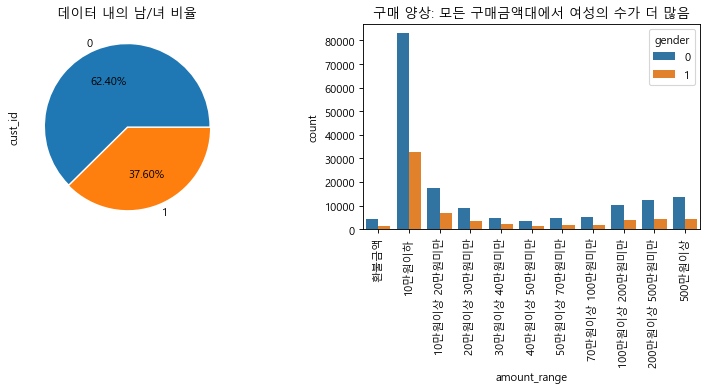

In [7]:
f,ax = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
tr.groupby('gender')['cust_id'].nunique().plot(kind='pie', autopct='%.2f%%', explode=(0,0.02), ax=ax[0])
ax[0].set_title('데이터 내의 남/녀 비율')
sns.countplot(data=tr, x='amount_range', hue='gender', ax=ax[1])
ax[1].set_title('구매 양상: 모든 구매금액대에서 여성의 수가 더 많음')
for item in ax[1].get_xticklabels():
       item.set_rotation(90)
# plt.axis('equal')
plt.tight_layout()
plt.show()

## 1차 생성 features


### 1. 가격적 관점

 만든 피쳐들
   - 년 총 구매금액에 따른 등급, 가격 선호도 
   - 총 구매액,구매건수,최대구매액, 평균 구매액
   - 환불금액, 환불건수, 내점 당 구매액, 구매건수
   

<font color = 'blue'> 년 총 구매금액에 따른 등급 (실제 롯데백화점 등급 기준 적용)

 - 롯데백화점 MVG 조건(2020년 기준)
         - 해당하지 않는 고객들은 silver로 설정 -> 10
         - 400만원 이상: Vip -> 20
         - 800만원 이상: Vip+ -> 30
         - 1800~2000만원이상: MVG-Ace  -> 40
         - 4000만원이상: MVG-Crown -> 50
         - 6000만원이상: MVG-Prestige -> 60
         - 1억이상: LENITH -> 70

In [8]:
# 나누는 함수 정의
def divide_class(x):
    if 4000000<= x < 8000000:
        return 200
    elif 8000000<= x < 18000000:
        return 300
    elif 18000000<= x <40000000:
        return 400
    elif 40000000<= x <60000000:
        return 500
    elif 60000000<= x <100000000:
        return 600
    elif x>= 100000000:
        return 700
    else:
        return 100

for i in trs:
    
    temp_amountdf = i.groupby('cust_id')['amount'].sum().reset_index()

    temp_amountdf['class'] = temp_amountdf['amount'].agg(divide_class)

    f = temp_amountdf[['cust_id', 'class']]

    features.append(f); f

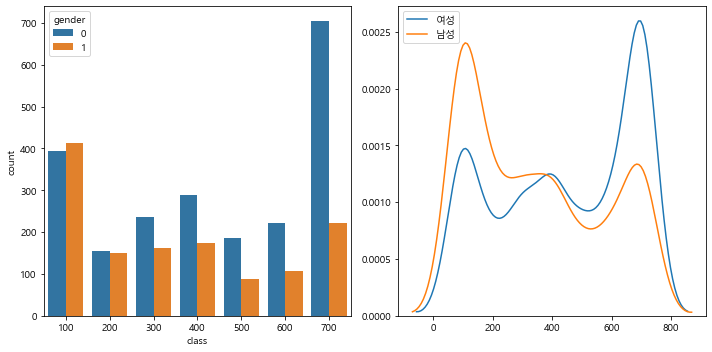

In [9]:
# vip고객을 구분하는 피쳐 생성 
temp_amountdf = tr.groupby('cust_id')['amount'].sum().reset_index()

temp_amountdf['class'] = temp_amountdf['amount'].agg(divide_class)

f = temp_amountdf[['cust_id', 'class']]

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='class', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['class'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['class'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'> 가격 선호도 
    - 채택x

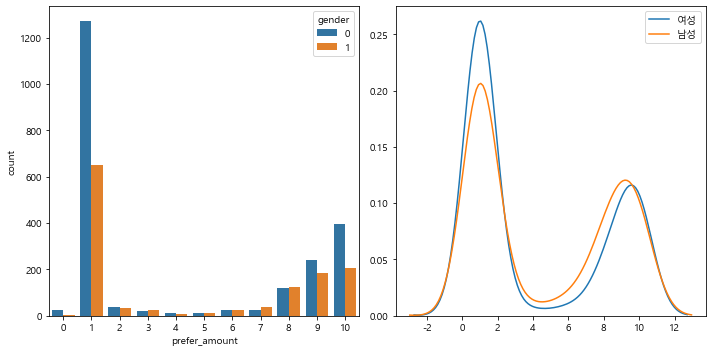

In [10]:
f = tr.groupby('cust_id')['amount_range'].agg([('prefer_amount', lambda x: x.value_counts().index[0])]).reset_index()

f.prefer_amount = f.prefer_amount.map({'환불금액': 0, '10만원이하': 1, '10만원이상 20만원미만':2, '20만원이상 30만원미만':3,'30만원이상 40만원미만':4, '40만원이상 50만원미만':5, '50만원이상 70만원미만': 6, '70만원이상 100만원미만':7, '100만원이상 200만원미만':8, '200만원이상 500만원미만':9, '500만원이상': 10})

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='prefer_amount', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['prefer_amount'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['prefer_amount'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'>

총구매액

In [11]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([('total_amount',np.sum), ]).reset_index()

    bins2 =  [i*10000000 for i in range(235)]
    f['total_amount_range2'] = pd.cut(f.total_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

    f = f.fillna(0)
    f = f.drop('total_amount', axis=1)
    features.append(f); f
    

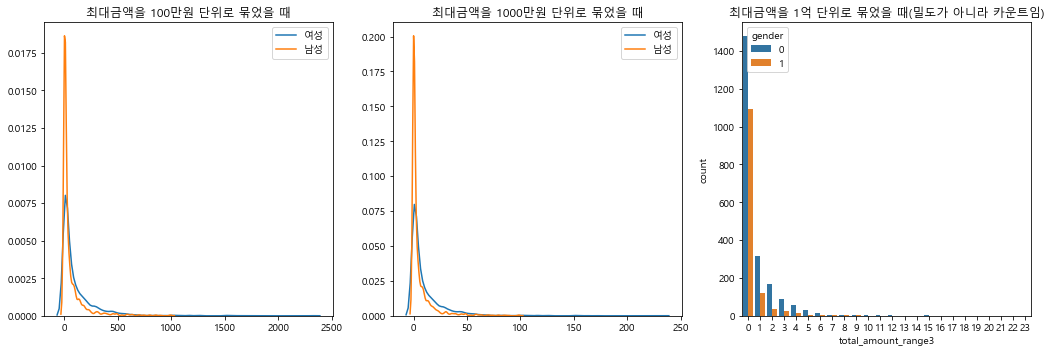

In [12]:
f = tr.groupby('cust_id')['amount'].agg([('total_amount',np.sum)]).reset_index()

f['gender'] = y_train['gender']

bins = [i*1000000 for i in range(2325)]
bins2 =  [i*10000000 for i in range(235)]
bins3 =  [i*100000000 for i in range(25)]

f['total_amount_range1'] = pd.cut(f.total_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_amount_range2'] = pd.cut(f.total_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['total_amount_range3'] = pd.cut(f.total_amount,bins= bins3,labels=[i for i in range(0,len(bins3)-1)])

f = f.fillna(0)

figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['total_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
sns.countplot(data=f, x='total_amount_range3', hue='gender', ax=ax[2])
ax[2].set_title('최대금액을 1억 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>

구매건수

In [13]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([('num_of_purchase', np.size), ]).reset_index()
    
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500]
    f['purchase_count'] = pd.cut(f.num_of_purchase,bins= bins,labels=[i*10 for i in range(1,len(bins))])
    
    f = f.drop('num_of_purchase', axis=1)
    f = f.fillna(10)
    features.append(f); f  

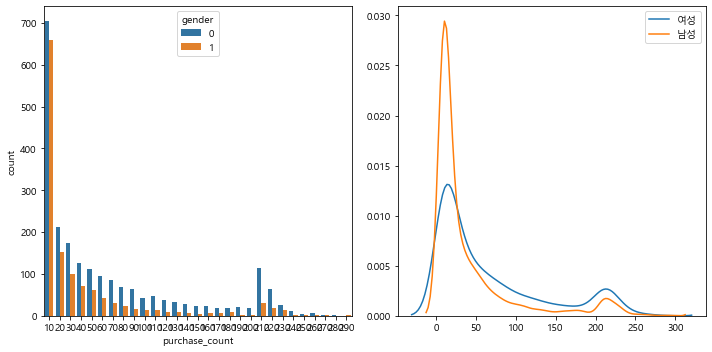

In [14]:
f = tr.groupby('cust_id')['amount'].agg([('num_of_purchase', np.size)]).reset_index()

f['gender'] = y_train['gender']

bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500]

f['purchase_count'] = pd.cut(f.num_of_purchase,bins= bins,labels=[i*10 for i in range(1,len(bins))])

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='purchase_count', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['purchase_count'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['purchase_count'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'>

평균구매액

In [15]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([
        ('total_amount_avg', lambda x: np.round(np.mean(x))),]).reset_index()
    
    f.total_amount_avg = f.total_amount_avg.apply(lambda x: 0 if x<0 else x)

    bins = [i*100000 for i in range(1545)]
    f['total_amount_avg_range1'] = pd.cut(f.total_amount_avg,bins= bins,labels=[i for i in range(0,len(bins)-1)])

    
    f = f.drop('total_amount_avg', axis=1)
    f = f.fillna(0)
    features.append(f); f  

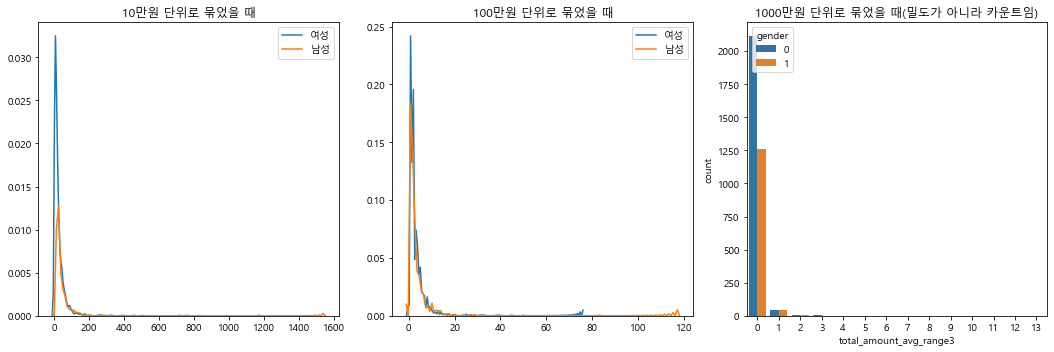

In [16]:
f = tr.groupby('cust_id')['amount'].agg([('total_amount_avg', lambda x: np.round(np.mean(x))),]).reset_index()

f.total_amount_avg = f.total_amount_avg.apply(lambda x: 0 if x<0 else x)

f['gender'] = y_train['gender']

bins = [i*100000 for i in range(1545)]
bins2 =  [i*1000000 for i in range(155)]
bins3 =  [i*10000000 for i in range(15)]

f['total_amount_avg_range1'] = pd.cut(f.total_amount_avg,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_amount_avg_range2'] = pd.cut(f.total_amount_avg,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['total_amount_avg_range3'] = pd.cut(f.total_amount_avg, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])


figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['total_amount_avg_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_avg_range1'], ax=ax[0], label='남성')
ax[0].set_title('10만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_amount_avg_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_avg_range2'], ax=ax[1], label='남성')
ax[1].set_title('100만원 단위로 묶었을 때')
sns.countplot(data=f, x='total_amount_avg_range3', hue='gender', ax=ax[2])
ax[2].set_title('1000만원 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>

 최대구매액

In [17]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([('max_amount', np.max),]).reset_index()
    

    bins2  = [i*10000000 for i in range(71)]
    f['max_amount_range2'] = pd.cut(f.max_amount, bins= bins2,labels=[i for i in range(1,len(bins2))])
    
    
    f = f.drop('max_amount', axis=1)
    f.max_amount_range2 = f['max_amount_range2'].fillna(1)    
    features.append(f); f  

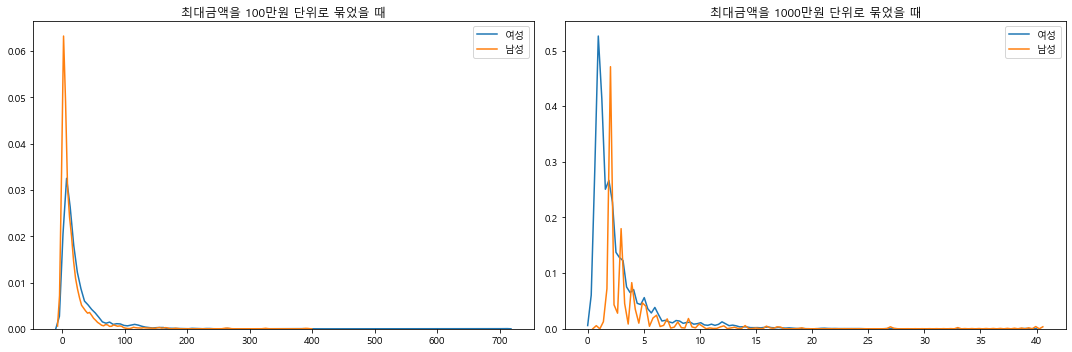

In [18]:
f = tr.groupby('cust_id')['amount'].agg([ ('max_amount', np.max),]).reset_index()

f['gender'] = y_train['gender']


bins = [i*1000000 for i in range(710)]
bins2  = [i*10000000 for i in range(71)]

f['max_amount_range1'] = pd.cut(f.max_amount, bins= bins,labels=[i for i in range(1,len(bins))])
f['max_amount_range2'] = pd.cut(f.max_amount, bins= bins2,labels=[i for i in range(1,len(bins2))])


figure, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['max_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['max_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['max_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['max_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
plt.tight_layout()
plt.show()

<font color = 'blue'>총 환불금액
    - 채택 x

In [19]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([('refund_amount', lambda x: x.sum() * -1),]).reset_index()

f['gender'] = y_train['gender']

In [20]:
bins = [i*200000 for i in range(4358)]
bins2 =  [i*2000000 for i in range(436)]
bins3 =  [i*20000000 for i in range(44)]

f['refund_amount_range1'] = pd.cut(f.refund_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['refund_amount_range2'] = pd.cut(f.refund_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['refund_amount_range3'] = pd.cut(f.refund_amount, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])


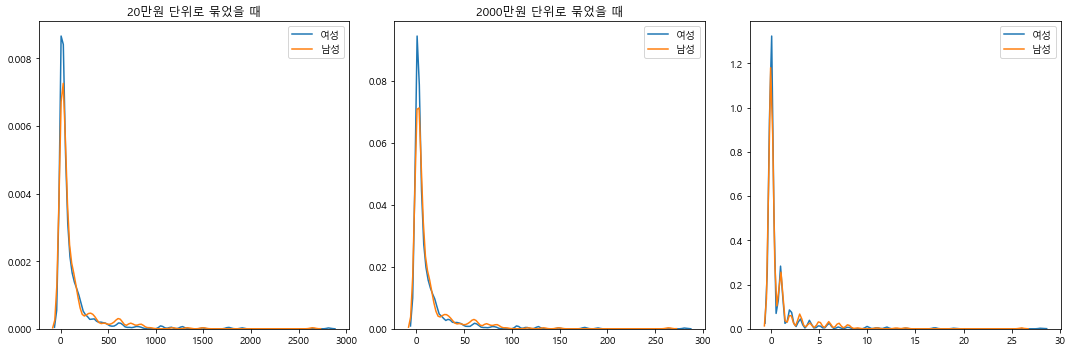

In [21]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['refund_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['refund_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('20만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['refund_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['refund_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('200만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['refund_amount_range3'], ax=ax[2], label='여성')
sns.kdeplot(f.query('gender==1')['refund_amount_range3'], ax=ax[2], label='남성')
ax[1].set_title('2000만원 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'>환불건수
    - 채택 x

In [22]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([('refund_num', np.size)]).reset_index()

f['gender'] = y_train['gender']

In [23]:
bins = [i for i in range(34)]
bins2 =  [i*2 for i in range(17)]

f['refund_num_1'] = pd.cut(f.refund_num,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['refund_num_2'] = pd.cut(f.refund_num,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

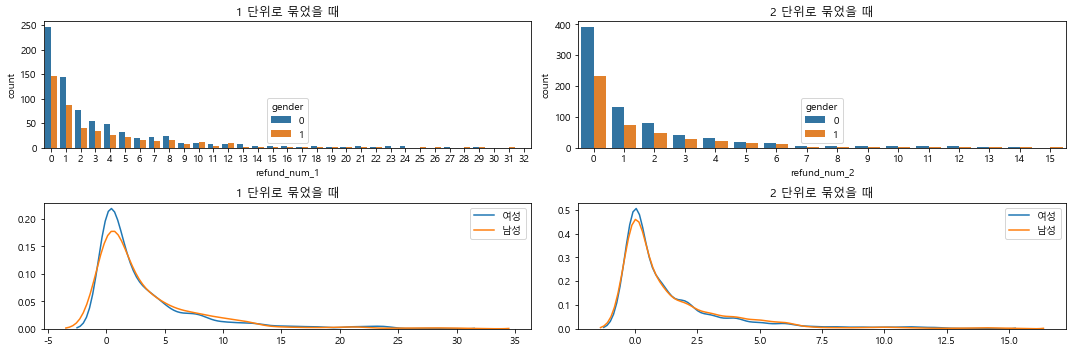

In [24]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='refund_num_1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='refund_num_2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['refund_num_1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['refund_num_1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['refund_num_2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['refund_num_2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'> 내점당 구매금액
    - 채택 x

In [25]:
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "per_visit_amount"})
f.per_visit_amount = f.per_visit_amount.astype(int)
f['gender'] = y_train['gender']

In [26]:
bins = [i*100000 for i in range(1545)]
bins2 =  [i*1000000 for i in range(155)]
bins3 =  [i*10000000 for i in range(15)]

f['per_visit_amount1'] = pd.cut(f.per_visit_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['per_visit_amount2'] = pd.cut(f.per_visit_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['per_visit_amount3'] = pd.cut(f.per_visit_amount,bins= bins3,labels=[i for i in range(0,len(bins3)-1)])


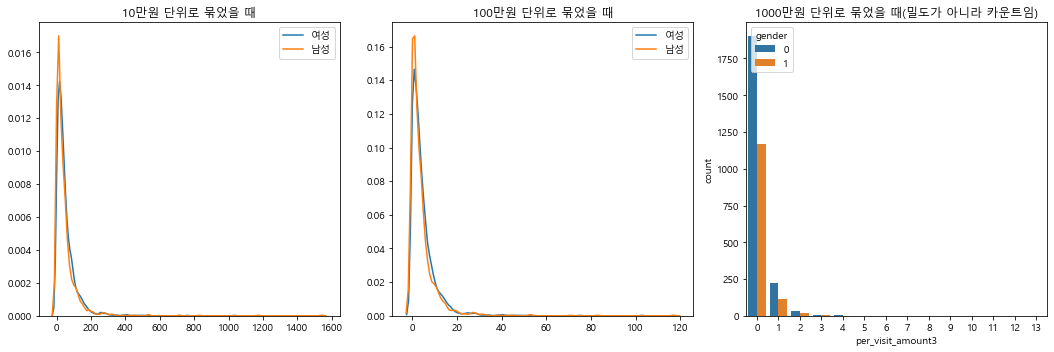

In [27]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['per_visit_amount1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_amount1'], ax=ax[0], label='남성')
ax[0].set_title('10만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per_visit_amount2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_amount2'], ax=ax[1], label='남성')
ax[1].set_title('100만원 단위로 묶었을 때')
sns.countplot(data=f, x='per_visit_amount3', hue='gender', ax=ax[2])
ax[2].set_title('1000만원 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'> 내점당 구매건수

In [28]:
# 내점 당 구매액 = 총구매액 / 내점일수
for i in trs:
    
    visits = i.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수
    
    f = (i.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "per_visit_pur_num"})
    
    f.per_visit_pur_num = f.per_visit_pur_num.apply(lambda x: round(x))
    
    features.append(f); f

In [29]:
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수

f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "per_visit_pur_num"})

f.per_visit_pur_num = f.per_visit_pur_num.apply(lambda x: round(x))

f['gender'] = y_train['gender']

bins = [i for i in range(22)]
bins2 =  [i*2 for i in range(11)]

f['per_visit_pur_num1'] = pd.cut(f.per_visit_pur_num,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['per_visit_pur_num2'] = pd.cut(f.per_visit_pur_num,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

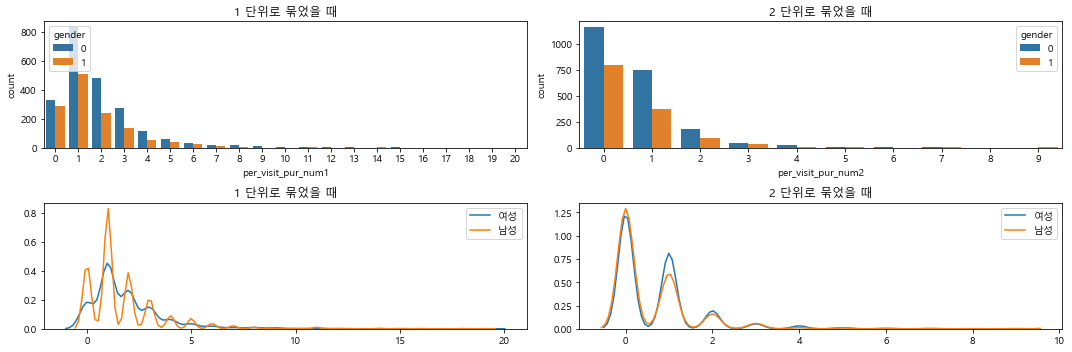

In [30]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='per_visit_pur_num1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='per_visit_pur_num2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['per_visit_pur_num1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_pur_num1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per_visit_pur_num2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_pur_num2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()


## ────────────────────────────────────────────────────────
### 2. 시간적 관점

 만든 피쳐들
   - 내점일수, 구매주기
   - 선호방문계절, 계절별 구매비율(s:3to5, s:6to8, f:9to11, w:12to2)
   - 선호방문월, 방문비율, 구매비율, 구매건수
   - 월초, 월중, 월말 선호 방문때, 방문비율, 구매비율, 구매건수
   - 최근 3개월, 6개월, 12개월 구매금액, 구매건수
   - 선호방문요일, 방문비율, 구매비율, 구매건수
   - 주말방문비율, 고객별 주말구매건수

<font color = 'blue'> 내점일수

In [31]:
for i in trs:
    f = i.groupby('cust_id')['tran_date'].agg([
        ('total_visit',lambda x: x.str[:10].nunique())]).reset_index()
    
    bins2 =  [i*2 for i in range(143)]
    f['total_visit2'] = pd.cut(f.total_visit,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
    
    f = f.drop('total_visit', axis=1)
    f = f.fillna(0)
    features.append(f); f  

In [32]:
f = tr.groupby('cust_id')['tran_date'].agg([('total_visit',lambda x: x.str[:10].nunique()),]).reset_index()

f['gender'] = y_train['gender']

bins = [i for i in range(285)]
bins2 =  [i*2 for i in range(143)]

f['total_visit1'] = pd.cut(f.total_visit,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_visit2'] = pd.cut(f.total_visit,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

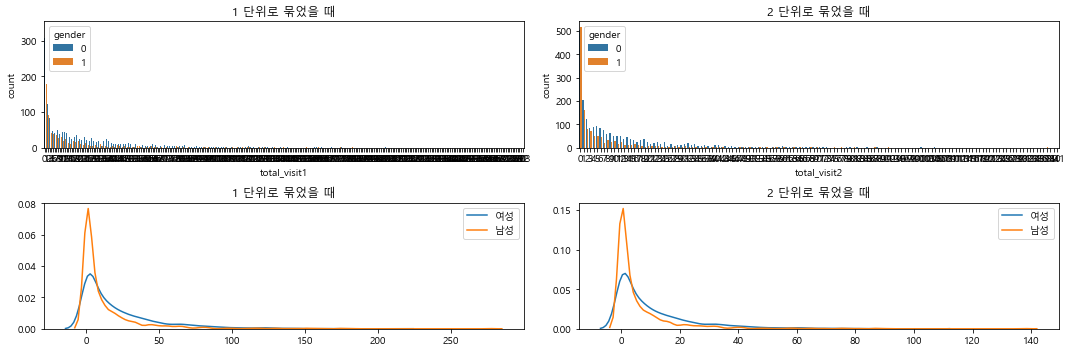

In [33]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='total_visit1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='total_visit2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['total_visit1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['total_visit1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_visit2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['total_visit2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'>
    구매주기

In [34]:
for i in trs:
    f = i.groupby('cust_id')['tran_date'].agg([('buying_cycle', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique()))]).reset_index()

    bins2 =  [i*2 for i in range(78)]
    f['buying_cycle2'] = pd.cut(f.buying_cycle,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])    
    
    f = f.drop('buying_cycle', axis=1) 
    f.buying_cycle2 = f['buying_cycle2'].fillna(0) 
    features.append(f); f  

In [35]:
f = tr.groupby('cust_id')['tran_date'].agg([('buying_cycle', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique()))]).reset_index()

f['gender'] = y_train['gender']

bins = [i for i in range(166)]
bins2 =  [i*2 for i in range(78)]

f['buying_cycle1'] = pd.cut(f.buying_cycle,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['buying_cycle2'] = pd.cut(f.buying_cycle,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

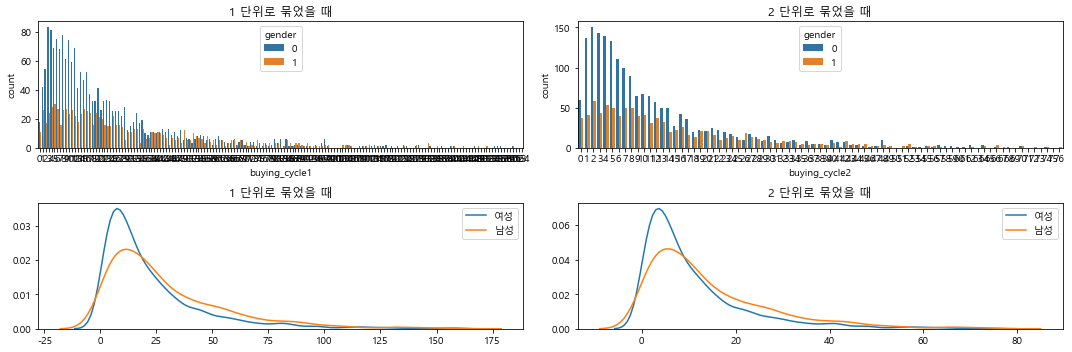

In [36]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='buying_cycle1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='buying_cycle2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['buying_cycle1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['buying_cycle1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['buying_cycle2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['buying_cycle2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'> 선호방문계절

In [37]:
## 고객별 선호방문계절
for i in trs:
    f = i.groupby('cust_id')['season'].agg([
        ('perfer_season', lambda x: x.value_counts().index[0])
    ]).reset_index()

## spring은 0, summer는 1, fall은 2, winter는 3으로 바꿔주기
    f.perfer_season = f.perfer_season.map({'spring': 0, 'summer':1, 'fall':2, 'winter':3})

    features.append(f); f

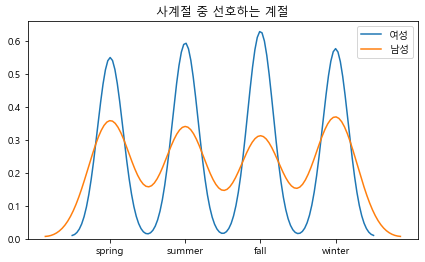

In [38]:
## 고객별 선호방문계절
f = tr.groupby('cust_id')['season'].agg([('prefer_season', lambda x: x.value_counts().index[0])]).reset_index()

## spring은 0, summer는 1, fall은 2, winter는 3으로 바꿔주기
f.prefer_season = f.prefer_season.map({'spring': 0, 'summer':1, 'fall':2, 'winter':3})

f['gender'] = y_train['gender']

plt.figure(figsize=(7,4))
sns.kdeplot(f.query('gender==0').prefer_season, label = '여성')
sns.kdeplot(f.query('gender==1').prefer_season, label = '남성')
plt.xticks([0,1,2,3],['spring','summer','fall','winter'])
plt.title('사계절 중 선호하는 계절')
plt.show()

<font color = 'blue'> 계절별 구매비율(s:3to5, s:6to8, f:9to11, w:12to2)

In [39]:
for i in trs:
    
    f = i.groupby('cust_id')['tran_date'].agg([
        ('spring_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5]))),
        ('summer_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([6,7,8]))),
        ('fall_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11]))),
        ('winter_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2,12])))
    ]).reset_index()
    
    features.append(f); f

In [40]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('spring_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('summer_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('fall_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('winter_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()

f['gender'] = y_train['gender']

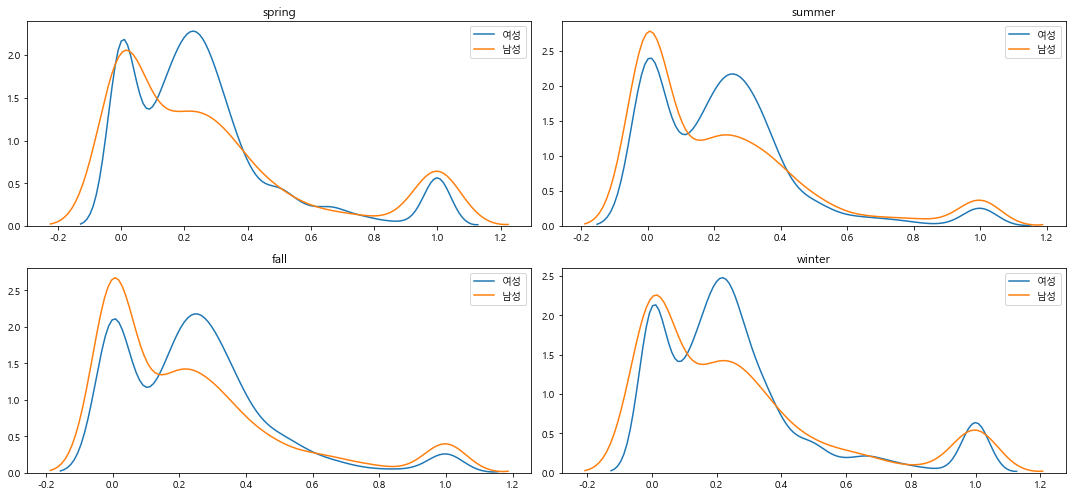

In [41]:
figure, ax = plt.subplots(2, 2, figsize=(15, 7))
sns.kdeplot(f.query('gender==0').spring_pur_ratio, label = '여성', ax=ax[0,0])
sns.kdeplot(f.query('gender==1').spring_pur_ratio, label = '남성', ax=ax[0,0])
ax[0,0].set_title('spring')
ax[0,1].set_title('summer')
sns.kdeplot(f.query('gender==0').summer_pur_ratio, label = '여성', ax=ax[0,1])
sns.kdeplot(f.query('gender==1').summer_pur_ratio, label = '남성', ax=ax[0,1])
ax[1,0].set_title('fall')
sns.kdeplot(f.query('gender==0').fall_pur_ratio, label = '여성', ax=ax[1,0])
sns.kdeplot(f.query('gender==1').fall_pur_ratio, label = '남성', ax=ax[1,0])
ax[1,1].set_title('winter')
sns.kdeplot(f.query('gender==0').winter_pur_ratio, label = '여성', ax=ax[1,1])
sns.kdeplot(f.query('gender==1').winter_pur_ratio, label = '남성', ax=ax[1,1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 선호방문월

In [42]:
## 선호방문월

for i in trs:
    
    f = i.groupby('cust_id')['month'].agg([
        ('prefer_month', lambda x: x.value_counts(1).index[0])
    ]).reset_index()

    features.append(f); f

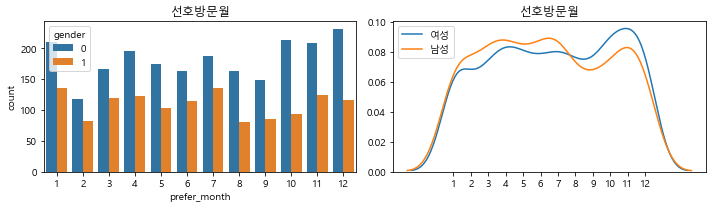

In [43]:
f = tr.groupby('cust_id')['month'].agg([('prefer_month', lambda x: x.value_counts(1).index[0])]).reset_index()

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(data=f, x='prefer_month', hue='gender', ax=ax[0])
ax[0].set_title('선호방문월')

sns.kdeplot(f.query('gender==0').prefer_month, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_month, label = '남성', ax=ax[1])
plt.xticks([i for i in range(1,13)])
plt.title('선호방문월')

plt.tight_layout()
plt.show()

<font color = 'blue'>월별 방문비율
    - 채택 x

In [44]:
# 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
    
# 월별 방문일수
temp_monthpivot = pd.pivot_table(tr, index='cust_id', columns='month', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

## 고객별 월별 방문비율
for i in range(len(temp_monthpivot.columns)):
    
     temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_visits
    
f = temp_monthpivot.reset_index()

f['gender'] = y_train['gender']


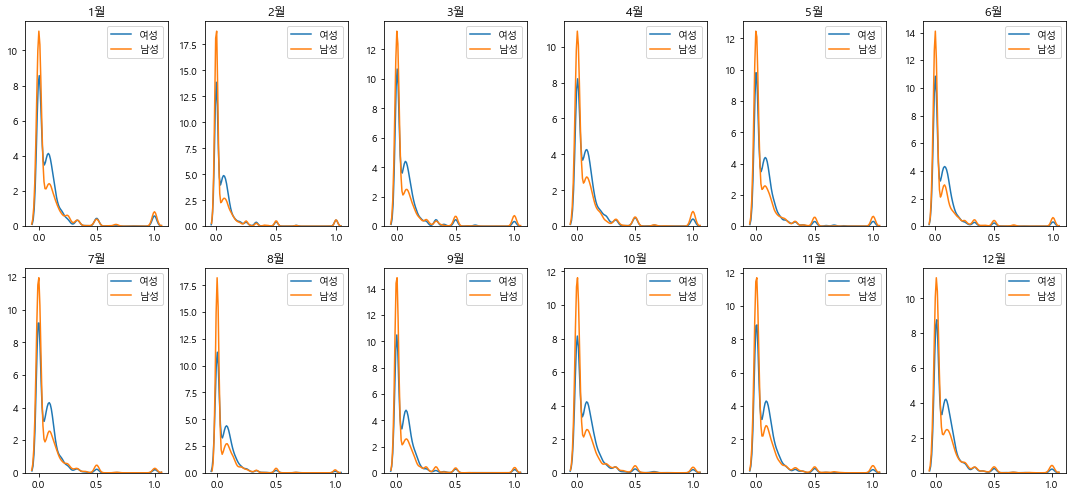

In [45]:
figure, ax = plt.subplots(2, 6, figsize=(15, 7))

for month in range(1,7):
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[0,month-1]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[0,month-1])
    ax[0,month-1].set_title(f'{month}월')

temp = 0
for month in range(7,13):
    
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[1,temp]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[1,temp])
    ax[1,temp].set_title(f'{month}월')
    temp += 1

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매비율
    - 12달 중 1월, 2월 그리고 9월을 피쳐로 채택

In [46]:
## 월별 구매비율
for i in trs:
    
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    
    # 고객별 월별 구매금액
    temp_monthpivot = pd.pivot_table(i, index='cust_id', columns='month', values='amount', aggfunc=sum, fill_value=0)

    # 칼럼명 변경화
    oldname = temp_monthpivot.columns.tolist()
    newname = [str(i)+'_month_amount' for i in oldname]
    temp_monthpivot = temp_monthpivot.rename(columns=dict(zip(oldname, newname)))

    # 고객별 월별 구매금액비율
    for i in range(len(temp_monthpivot.columns)):
    
        temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_amount
    
    f = temp_monthpivot.reset_index()
    f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
    f = f[['cust_id', '1_month_amount', '2_month_amount','9_month_amount']]
    features.append(f); f

In [47]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
    
# 고객별 월별 구매금액
temp_monthpivot = pd.pivot_table(tr, index='cust_id', columns='month', values='amount', aggfunc=sum, fill_value=0)

# 고객별 월별 구매금액비율
for i in range(len(temp_monthpivot.columns)):
    
    temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_amount
    
f = temp_monthpivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

f['gender'] = y_train['gender']


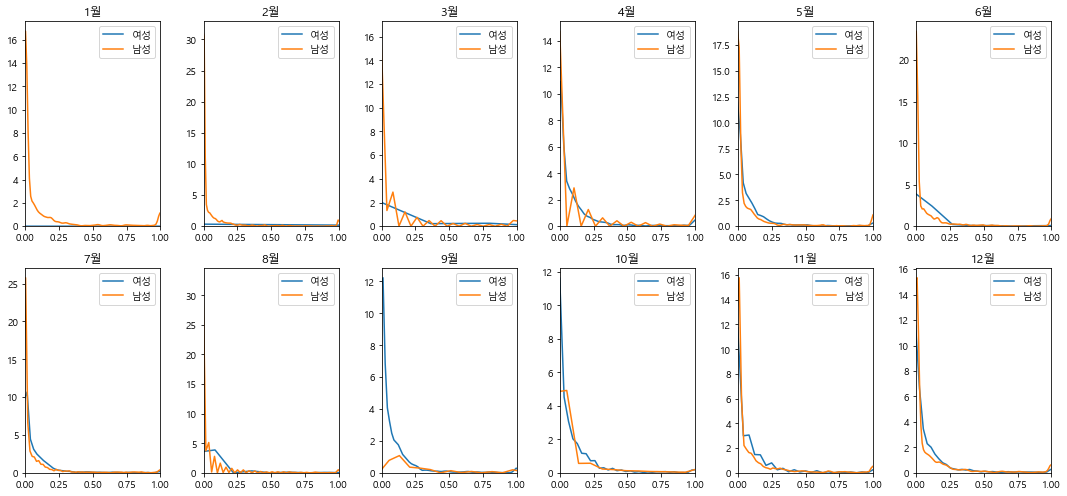

In [48]:
figure, ax = plt.subplots(2, 6, figsize=(15, 7))

for month in range(1,7):
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[0,month-1]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[0,month-1])
    ax[0,month-1].set_xlim(0,1)
    ax[0,month-1].set_title(f'{month}월')

temp = 0
for month in range(7,13):
    
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[1,temp]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[1,temp])
    ax[1,temp].set_xlim(0,1)
    ax[1,temp].set_title(f'{month}월')
    temp += 1

plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 선호 방문때
    - 채택x

In [49]:
f = tr.groupby('cust_id')['month_when'].agg([('prefer_month_when', lambda x: x.value_counts().index[0])]).reset_index()

# 문자를 숫자로 바꿔주기: '0to10':0 ~ '21to31': 2
f.prefer_month_when = f.prefer_month_when.map({'0to10':0, '11to20': 1, '21to31':2})

f['gender'] = y_train['gender']

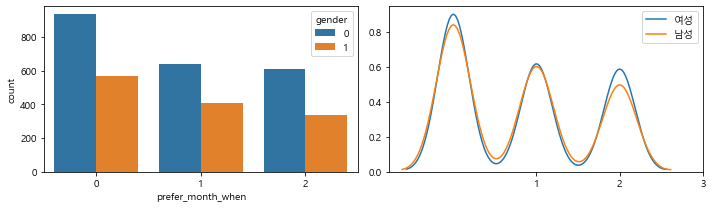

In [50]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(data=f, x='prefer_month_when', hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0').prefer_month_when, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_month_when, label = '남성', ax=ax[1])
plt.xticks([i for i in range(1,4)])


plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 방문비율


In [51]:
## 고객별 월초, 월중, 월말 방문비율

for i in trs:
    
    # 총 방문일수
    total_visits = i.groupby('cust_id')['tran_date'].nunique()
        
    # 고객별 월초, 월중, 월말 방문일수
    temp_monthwhenpivot = pd.pivot_table(i, index='cust_id', columns='month_when', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

    # 칼럼명 변경화
    oldname = temp_monthwhenpivot.columns.tolist()
    newname = [str(i)+'_visits' for i in oldname]
    temp_monthwhenpivot = temp_monthwhenpivot.rename(columns=dict(zip(oldname, newname)))

    # 고객별 월초, 월중, 월말 방문비율

    for i in range(len(temp_monthwhenpivot.columns)):
    
            temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_visits
    
    f = temp_monthwhenpivot.reset_index()

    features.append(f); f

In [52]:
# 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
        
# 고객별 월초, 월중, 월말 방문일수
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 고객별 월초, 월중, 월말 방문비율

for i in range(len(temp_monthwhenpivot.columns)):
    
        temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_visits
    
f = temp_monthwhenpivot.reset_index()

f['gender'] = y_train['gender']


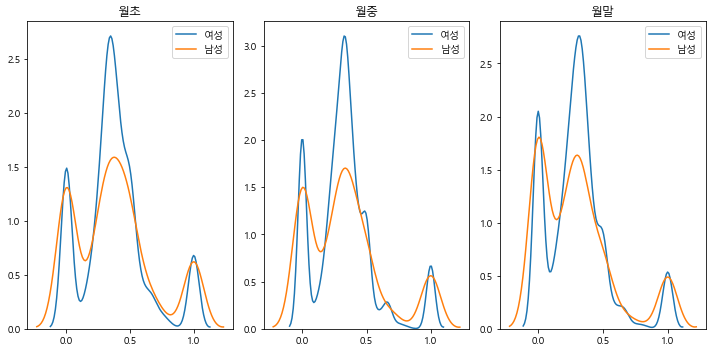

In [53]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.kdeplot(f.query('gender==0')['0to10'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
sns.kdeplot(f.query('gender==0')['11to20'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
sns.kdeplot(f.query('gender==0')['21to31'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31'], label = '남성', ax=ax[2])
ax[2].set_title('월말')

plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 구매비율


In [54]:
##고객별 월초, 월중, 월말 구매비율

for i in trs:
    
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    
    # 고객별 월초, 월중, 월말별 구매금액
    temp_monthwhenpivot = pd.pivot_table(i, index='cust_id', columns='month_when', values='amount', aggfunc=sum, fill_value=0)

    # 칼럼명 변경화
    oldname = temp_monthwhenpivot.columns.tolist()
    newname = [str(i)+'_amount' for i in oldname]
    temp_monthwhenpivot = temp_monthwhenpivot.rename(columns=dict(zip(oldname, newname)))

    # 고객별 월초, 월중, 월말별 구매금액비율
    for i in range(len(temp_monthwhenpivot.columns)):
    
        temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_amount
    
    f = temp_monthwhenpivot.reset_index()
    f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

    features.append(f); f

In [55]:
# 고객별 구매금액 총합
total_amount = tr.groupby('cust_id')['amount'].sum()
    
# 고객별 월초, 월중, 월말별 구매금액
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='amount', aggfunc=sum, fill_value=0)

# 고객별 월초, 월중, 월말별 구매금액비율
for i in range(len(temp_monthwhenpivot.columns)):
    
    temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_amount
    
f = temp_monthwhenpivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

f['gender'] = y_train['gender']

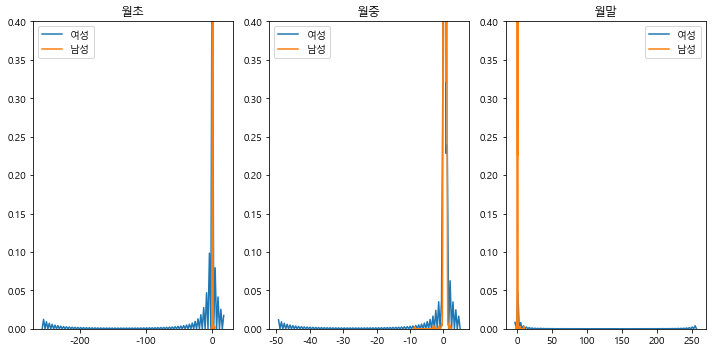

In [56]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.kdeplot(f.query('gender==0')['0to10'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
ax[0].set_ylim(0,0.4)
sns.kdeplot(f.query('gender==0')['11to20'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
ax[1].set_ylim(0,0.4)
sns.kdeplot(f.query('gender==0')['21to31'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31'], label = '남성', ax=ax[2])
ax[2].set_title('월말')
ax[2].set_ylim(0,0.4)
plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 구매건수


In [57]:
## 고객별 월초, 월중, 월말 구매건수

for i in trs:
    
    temp_monthwhenpivot = pd.pivot_table(i, index='cust_id', columns='month_when', values='amount', aggfunc=np.size, fill_value=0)
    
    
    
    # 칼럼명 변경화
    oldname = temp_monthwhenpivot.columns.tolist()
    newname = [str(i)+'_buy' for i in oldname]
    temp_monthwhenpivot = temp_monthwhenpivot.rename(columns=dict(zip(oldname, newname)))

    f = temp_monthwhenpivot.reset_index()
    
    bins = [i*10 for i in range(57)]
    bins2 = [i*10 for i in range(65)]
    bins3 = [i*10 for i in range(67)]
    labels = [i for i in range(len(bins)-1)]
    labels2 = [i for i in range(len(bins2)-1)]
    labels3 = [i for i in range(len(bins3)-1)]
    f['0to10_10unit'] = pd.cut(f['0to10_buy'], bins=bins, labels = labels)
    f['11to20_20unit'] = pd.cut(f['11to20_buy'], bins=bins2, labels = labels2)
    f['21to31_30unit'] = pd.cut(f['21to31_buy'], bins=bins3, labels = labels3)
    f = f.drop('0to10_buy', axis=1) 
    f = f.drop('11to20_buy', axis=1) 
    f = f.drop('21to31_buy', axis=1) 
    f = f.fillna(0)

    features.append(f); f

In [58]:
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='amount', aggfunc=np.size, fill_value=0)

f = temp_monthwhenpivot.reset_index()

f['gender'] = y_train['gender']

In [59]:
bins = [i*10 for i in range(57)]
bins2 = [i*10 for i in range(65)]
bins3 = [i*10 for i in range(67)]
labels = [i for i in range(len(bins)-1)]
labels2 = [i for i in range(len(bins2)-1)]
labels3 = [i for i in range(len(bins3)-1)]
f['0to10_10unit'] = pd.cut(f['0to10'], bins=bins, labels = labels)
f['11to20_20unit'] = pd.cut(f['11to20'], bins=bins2, labels = labels2)
f['21to31_30unit'] = pd.cut(f['21to31'], bins=bins3, labels = labels3)

f = f.fillna(0)

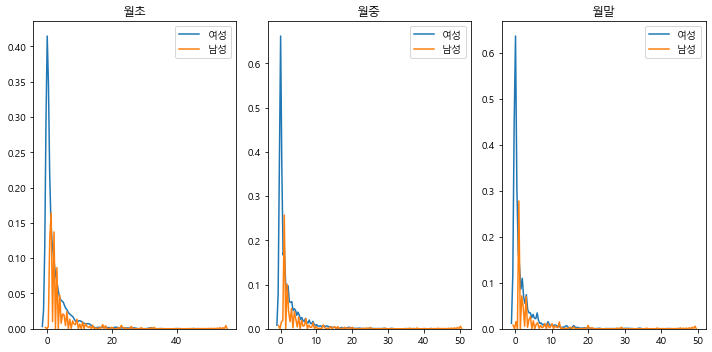

In [60]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5)) 
sns.kdeplot(f.query('gender==0')['0to10_10unit'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10_10unit'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
sns.kdeplot(f.query('gender==0')['11to20_20unit'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20_20unit'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
sns.kdeplot(f.query('gender==0')['21to31_30unit'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31_30unit'], label = '남성', ax=ax[2])
ax[2].set_title('월말')

plt.tight_layout()
plt.show()

<font color = 'blue'>  최근 3개월 구매금액
    - 채택x


In [61]:
start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(3))
f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
    ('per3month_amount_ratio', np.sum), 
    ('per3month_num_of_pur', np.size)
]).reset_index()

f['gender'] = y_train['gender']

In [62]:
bins1 = [i*1000000 for i in range(762)]
bins2 =  [i*10000000 for i in range(77)]
bins3 =  [i*100000000 for i in range(8)]

f['per3month_amount_ratio1'] = pd.cut(f.per3month_amount_ratio, bins= bins1,labels=[i for i in range(0,len(bins1)-1)])
f['per3month_amount_ratio2'] = pd.cut(f.per3month_amount_ratio, bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['per3month_amount_ratio3'] = pd.cut(f.per3month_amount_ratio, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])

f = f.fillna(0)

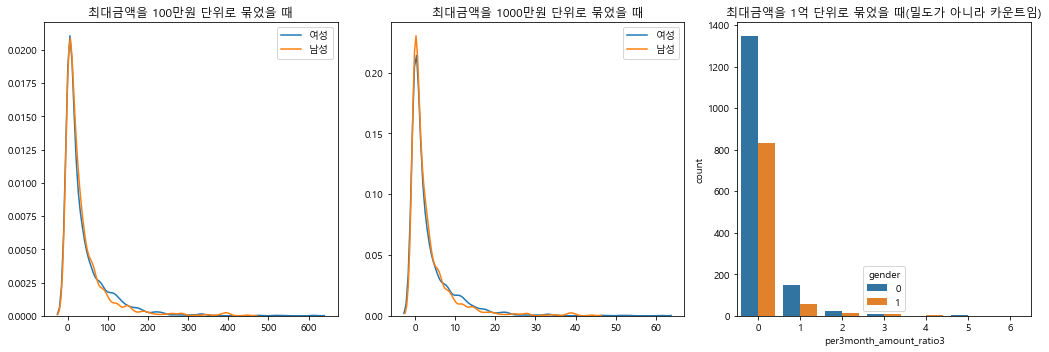

In [63]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['per3month_amount_ratio1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['per3month_amount_ratio1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per3month_amount_ratio2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['per3month_amount_ratio2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
sns.countplot(data=f, x='per3month_amount_ratio3', hue='gender', ax=ax[2])
ax[2].set_title('최대금액을 1억 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>  최근 3개월 구매건수
    - 채택x

In [64]:
bins1 = [i for i in range(528)]
bins2 = [i*2 for i in range(265)]
bins3 = [i*4 for i in range(133)]
bins4 = [i*5 for i in range(106)]

f['per3month_num_of_pur1'] = pd.cut(f.per3month_num_of_pur, bins= bins1,labels=[i for i in range(0,len(bins1)-1)])
f['per3month_num_of_pur2'] = pd.cut(f.per3month_num_of_pur, bins= bins2,labels=[i*2 for i in range(0,len(bins2)-1)])
f['per3month_num_of_pur3'] = pd.cut(f.per3month_num_of_pur, bins= bins3,labels=[i*4 for i in range(0,len(bins3)-1)])
f['per3month_num_of_pur4'] = pd.cut(f.per3month_num_of_pur, bins= bins4,labels=[i*5 for i in range(0,len(bins4)-1)])

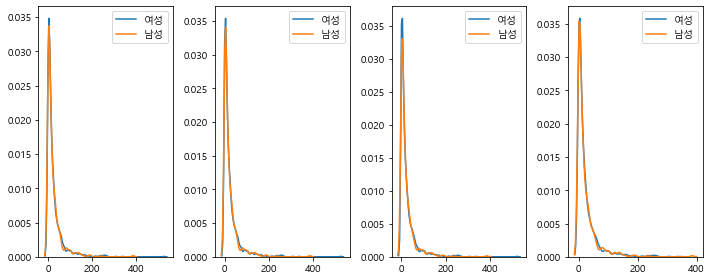

In [65]:
figure, ax = plt.subplots(1, 4, figsize=(10, 4))
for i in range(4):
    sns.kdeplot(f.query('gender==0')[f'per3month_num_of_pur{i+1}'], ax=ax[i], label='여성')
    sns.kdeplot(f.query('gender==1')[f'per3month_num_of_pur{i+1}'], ax=ax[i], label='남성')

    
plt.tight_layout()
plt.show()

<font color = 'blue'>  최근 12개월 구매금액, 구매건수
    - 앞에서 다룬 총 구매 금액과 총 구매건수와 겹치므로 피쳐제거

<font color = 'blue'> 선호방문요일


In [66]:
## 선호방문요일

for i in trs:
    
    f = i.groupby('cust_id')['date'].agg([
        ('prefer_date', lambda x: x.value_counts().index[0])
    ]).reset_index()

    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    f.prefer_date = f.prefer_date.map({'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})


    features.append(f); f

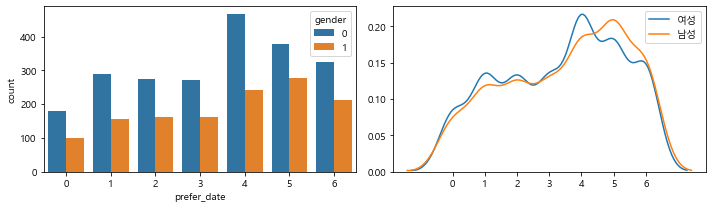

In [67]:
f = tr.groupby('cust_id')['date'].agg([('prefer_date', lambda x: x.value_counts().index[0])]).reset_index()

# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
f.prefer_date = f.prefer_date.map({'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='prefer_date', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').prefer_date, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_date, label = '남성', ax=ax[1])
plt.xticks([i for i in range(7)])

plt.tight_layout()
plt.show()

<font color = 'blue'> 방문비율


In [68]:
## 요일별 방문비율

for i in trs:
    
    # 총 방문일수
    total_visits = i.groupby('cust_id')['tran_date'].nunique()

    # 고객별 요일별 방문일수
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
    # 칼럼명 변경화
    oldname = temp_datepivot.columns.tolist()
    newname = [str(i)+'_visits' for i in oldname]
    temp_datepivot = temp_datepivot.rename(columns=dict(zip(oldname, newname)))
    
    # 고객별 요일별 방문비율
    
    for i in range(len(temp_datepivot.columns)):
        
            temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_visits
        
    f = temp_datepivot.reset_index()
    f = f[['cust_id','0_visits','1_visits','2_visits','3_visits','4_visits', '5_visits']]

    features.append(f); f

In [69]:
 # 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()

# 고객별 요일별 방문일수
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
# 고객별 요일별 방문비율
for i in range(len(temp_datepivot.columns)):
        
    temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_visits
        
f = temp_datepivot.reset_index()
f['gender'] = y_train['gender']

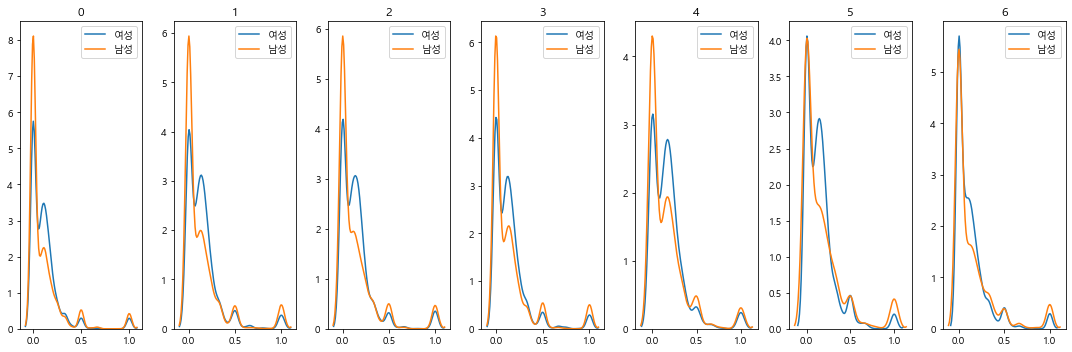

In [70]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매비율


In [71]:
## 고객별 요일별 구매비율

for i in trs:
    
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    # 고객별 요일별구매금액
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='amount', aggfunc=sum, fill_value=0)
    
    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
    # 칼럼명 변경화
    oldname = temp_datepivot.columns.tolist()
    newname = [str(i)+'_amount' for i in oldname]
    temp_datepivot = temp_datepivot.rename(columns=dict(zip(oldname, newname)))
    
    # 고객별 요일별 구매금액비율
    for i in range(len(temp_datepivot.columns)):
        
        temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_amount
        
    f = temp_datepivot.reset_index()
    f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
    features.append(f); f

In [72]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
# 고객별 요일별구매금액
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=sum, fill_value=0)
    
# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
# 고객별 요일별 구매금액비율
for i in range(len(temp_datepivot.columns)):
        
    temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_amount
        
f = temp_datepivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
f['gender'] = y_train['gender']

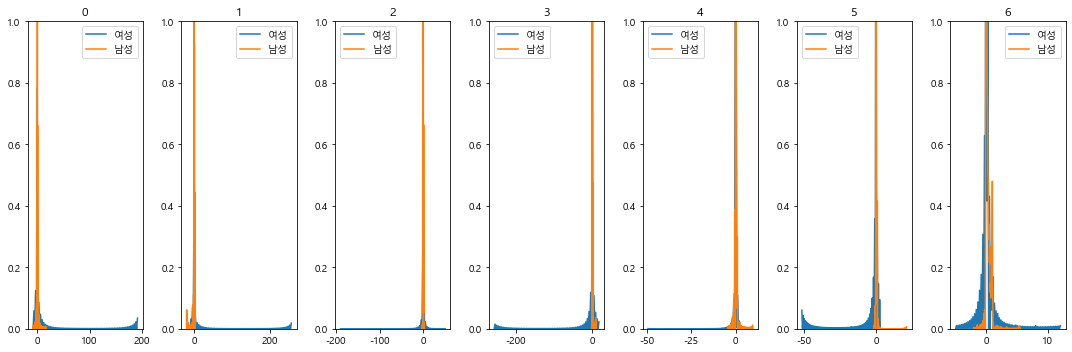

In [73]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')
    ax[date].set_ylim(0,1)

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매건수


In [74]:
## 고객별 요일별 구매건수

for i in trs:
    
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)
    
    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

    ## 칼럼명 변경화
    oldname = temp_datepivot.columns.tolist()
    newname = [str(i)+'_buy' for i in oldname]
    temp_datepivot = temp_datepivot.rename(columns=dict(zip(oldname, newname)))
    
    f = temp_datepivot.reset_index()

    features.append(f); f

In [75]:
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)
    
# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

f = temp_datepivot.reset_index()

f['gender'] = y_train['gender']

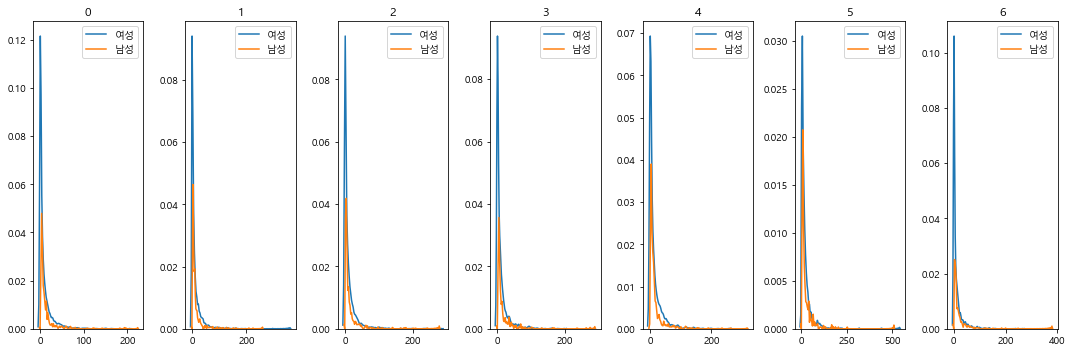

In [76]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')
plt.tight_layout()
plt.show()

<font color = 'blue'> 주말방문비율

In [77]:
## 주말방문비율

for i in trs:
    
    f = i.groupby('cust_id')['tran_date'].agg([
        ('weekend_visit_ratio', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4))
    ]).reset_index()
    features.append(f); f

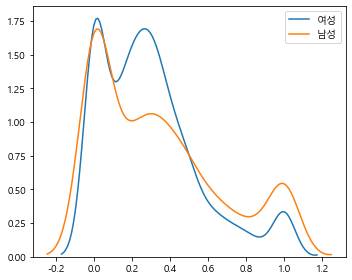

In [78]:
f = tr.groupby('cust_id')['tran_date'].agg([('weekend_visit_ratio', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4))]).reset_index()

f['gender'] = y_train['gender']

plt.figure(figsize= (5,4))
sns.kdeplot(f.query('gender==0').weekend_visit_ratio, label = '여성')
sns.kdeplot(f.query('gender==1').weekend_visit_ratio, label = '남성')

plt.tight_layout()
plt.show()

<font color = 'blue'> 고객별 주말구매건수

In [79]:
## 주말 구매건수

for i in trs:
    
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)

    f = temp_datepivot[['토','일']].sum(axis=1).reset_index().rename(columns={0:'weekend_buy'})
    
    
    bins2 =  [i*10 for i in range(63)]
    f['weekend_buy2'] = pd.cut(f.weekend_buy,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
    f.weekend_buy2 = f.weekend_buy2.fillna(0)
    f = f.drop('weekend_buy', axis=1)
    features.append(f); f

In [80]:
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)

f = temp_datepivot[['토','일']].sum(axis=1).reset_index().rename(columns={0:'weekend_buy'})

f['gender'] = y_train['gender']

In [81]:
bins2 =  [i*10 for i in range(63)]
f['weekend_buy2'] = pd.cut(f.weekend_buy,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f.weekend_buy2 = f.weekend_buy2.fillna(0)

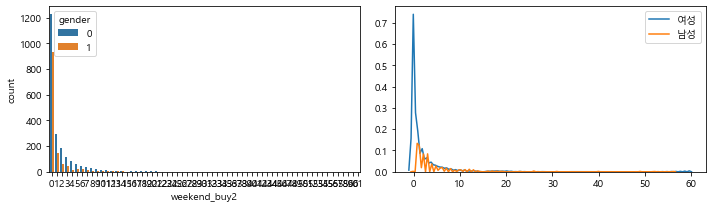

In [82]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='weekend_buy2', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').weekend_buy2, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').weekend_buy2, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

## ────────────────────────────────────────────────────────

### 3. 장소적 관점

만든 피쳐들
   - 주구매지점
   - 방문 지점의 수
   - 많이 방문한 지점들 best-12 순위별 구매금액비율, 구매건수

<font color = 'blue'> 주구매지점
    - 채택x

In [83]:
f = tr.groupby('cust_id')['store_nm'].agg([('main_store', lambda x: x.value_counts().index[0])]).reset_index()

# 지점명 숫자로 바꿔주기
store_name = tr.store_nm.unique().tolist()
store_newname = [i for i in range(len(store_name))]
f.main_store = f.main_store.map(dict(zip(store_name, store_newname)))

f['gender'] = y_train['gender']

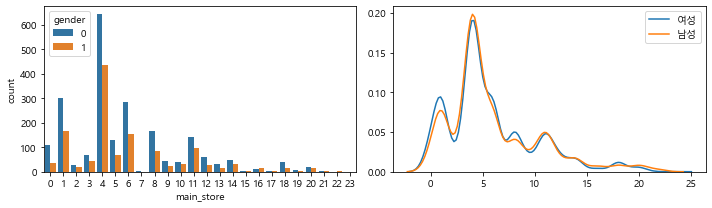

In [84]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='main_store', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').main_store, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_store, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'>  방문 지점의 수

In [85]:
## 고객별 방문 지점의 수

for i in trs:

    f = i.groupby('cust_id')['store_nm'].nunique().reset_index().rename(columns={'store_nm':'stores_count'})

    features.append(f); f

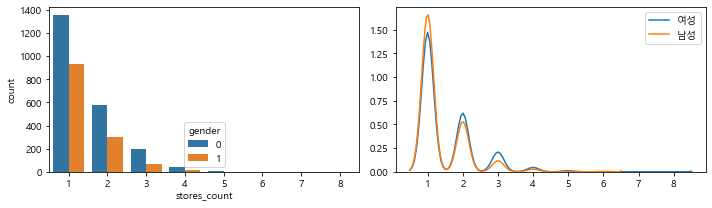

In [86]:
f = tr.groupby('cust_id')['store_nm'].nunique().reset_index().rename(columns={'store_nm':'stores_count'})

f['gender'] = y_train['gender']


figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='stores_count', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').stores_count, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').stores_count, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 방문비율

 - top-12가 전체 24개의 점포중 91% 데이터를 차지한다

In [87]:
## 전체의 90프로를 넘게 차지하는 12개의 점포 데이터

for i in trs:

    print(i.store_nm.value_counts()[:12].sum() / i.store_nm.value_counts().sum())

0.9145704384407165
0.9261790924320424


In [88]:
top12store_all = []

for i in trs:
    
    ## top-12에 해당하는 지점들
    
    top12store = i.store_nm.value_counts()[:12].index.tolist()
    
    top12store_all.append(top12store)
    
top12store_train = top12store_all[0]; print(top12store_train)
top12store_test = top12store_all[1]; print(top12store_test)
print()
intersection_store = list(set(top12store_train).intersection(top12store_test)); print(intersection_store)
print('겹치는 지점 수: ', len(intersection_store))

['본  점', '분당점', '잠실점', '부산본점', '일산점', '노원점', '광주점', '영등포점', '강남점', '부평점', '청량리점', '대전점']
['본  점', '분당점', '잠실점', '일산점', '강남점', '부산본점', '청량리점', '광주점', '영등포점', '미아점', '노원점', '부평점']

['본  점', '잠실점', '노원점', '강남점', '부평점', '분당점', '부산본점', '광주점', '영등포점', '청량리점', '일산점']
겹치는 지점 수:  11


In [89]:
## intersection_store 방문비율

for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})

    # 고객별 전체방문일수
    total_visits = i.groupby('cust_id')['tran_date'].nunique()
    # 고객별 점포별 방문일수
    temp_storepivot = pd.pivot_table(i.query('store_nm in @intersection_store'), index='cust_id', columns='store_nm', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

    
    # 칼럼명 영문화
    engname = temp_storepivot.columns.tolist()
    newname = [str(i*10)+'_visits' for i in range(len(engname))]
    temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

    # 고객별 점포별 방문비율
    for i in range(len(temp_storepivot.columns)):
    
        temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_visits
    
    f = temp_storepivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)
    
    
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = [0, 0.2, 0.4, 0.6, 0.8]

    for i in range(11):
    
        f[f'{i}_visits{i}'] = pd.cut(f[f'{i*10}_visits'], bins= bins, labels = labels)
        f = f.drop(f'{i*10}_visits', axis=1)
    f = f.fillna(0)    
    features.append(f); f

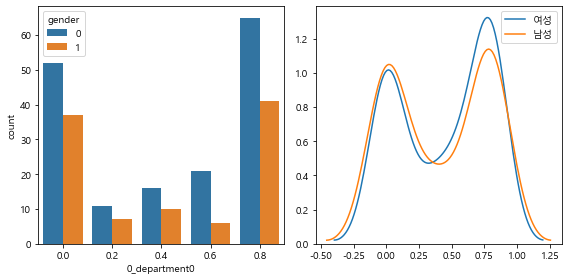

In [90]:
# 고객별 전체방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
# 고객별 점포별 방문일수
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_department' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

# 고객별 점포별 방문비율
for i in range(len(temp_storepivot.columns)):
    
     temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_visits
    
f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']


bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = [0, 0.2, 0.4, 0.6, 0.8]

for i in range(12):
    
    f[f'{i}_department{i}'] = pd.cut(f[f'{i*10}_department'], bins= bins, labels = labels)
    
    
figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_department0'], hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0')['0_department0'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_department0'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()    
    
    

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 구매금액비율

In [91]:
## intersection_store 구매금액비율

for i in trs:
    
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
        
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    # 고객별 점포별 구매금액
    temp_storepivot = pd.pivot_table(i.query('store_nm in @intersection_store'), index='cust_id', columns='store_nm', values='amount', aggfunc=sum, fill_value=0)

    # 칼럼명 영문화
    engname = temp_storepivot.columns.tolist()
    newname = [str(i*10)+'_amount_ratio' for i in range(len(engname))]
    temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

    # 고객별 점포별 구매금액비율
    for i in range(len(temp_storepivot.columns)):
    
        temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_amount
    
    f = temp_storepivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)
    
    
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    for i in range(11):
    
        f[f'{i}_amount_ratio{i}'] = pd.cut(f[f'{i*10}_amount_ratio'], bins= bins, labels = labels)
        f = f.drop(f'{i*10}_amount_ratio', axis=1)
    f = f.fillna(0)    
    features.append(f); f

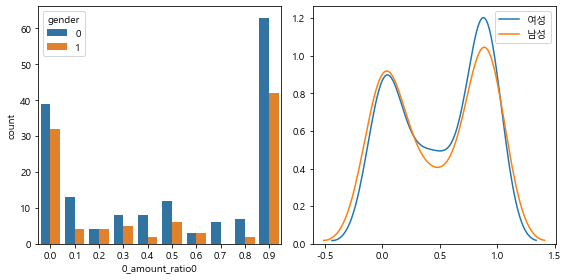

In [92]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
# 고객별 점포별 구매금액
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='amount', aggfunc=sum, fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_amount_ratio' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

# 고객별 점포별 구매금액비율
for i in range(len(temp_storepivot.columns)):
    
    temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_amount
    
f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(12):
    
    f[f'{i}_amount_ratio{i}'] = pd.cut(f[f'{i*10}_amount_ratio'], bins= bins, labels = labels)

figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_amount_ratio0'], hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0')['0_amount_ratio0'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_amount_ratio0'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 구매건수
    - 채택x

In [93]:
# 고객별 점포별 구매건수
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='amount', aggfunc=np.size, fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_num_of_pur' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']

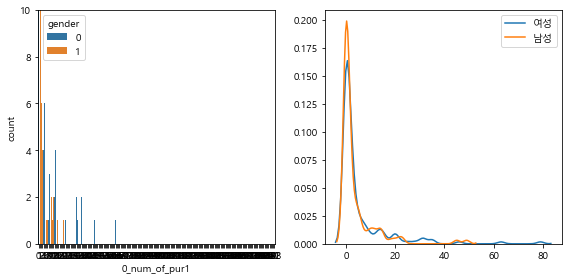

In [94]:
bins1 = [i*5 for i in range(195)]
bins2 = [i*10 for i in range(98)]
labels1 = [i for i in range(194)]
labels2 = [i for i in range(97)]
f[f'0_num_of_pur1'] = pd.cut(f['0_num_of_pur'], bins= bins1, labels = labels1)
f[f'0_num_of_pur2'] = pd.cut(f['0_num_of_pur'], bins= bins2, labels = labels2)

figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_num_of_pur1'], hue='gender', ax=ax[0])
ax[0].set_ylim(0, 10)
sns.kdeplot(f.query('gender==0')['0_num_of_pur1'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_num_of_pur1'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()

## ────────────────────────────────────────────────────────

### 4.  제품적 관점

   - 구매추세 패턴1
        - 주구매 상품1: goods_id
        - 주구매 상품2: gds_grp_nm
        - 주구매 상품3: gds_grp_mclas_nm
   - 구매추세 패턴2
        - 상반기, 하반기 총 구매금액 비교해서 상승세, 하락세 나누기
   - 상품별 구매순서 -> 가장 먼저 방문하는 상품대분류명군
   - 구매상품종류1(goods_id), 구매상품종류2(gds_grp_nm), 구매상품종류3(gds_grp_mclas_nm)
   - Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부
   - 많이 구매한 상품소분류별 best-x 구매금액비율, 구매건수비율(3471 중 x)
   - 많이 구매한 상품중분류별 best-y 구매금액비율, 구매건수비율(324 중 y)
   - 많이 구매한 상품대분류별 best-z 구매금액비율, 구매건수비율(49 중 z)

구매추세패턴1

 <font color = 'blue'> 주구매상품1

->  주구매 상품: 가장 많이 구매한 상품(goods_id)
     - 총 3471개 물품 중 3500명이 가장 많이 사는 물품들은 850개정도로 겹치는 물품들이 있다

In [95]:
## goods_id 구매한 물품 중 가장 많이 구매한 물품

for i in trs:
    
    f = i.groupby('cust_id')['goods_id'].agg([
        ('main_product_goods', lambda x: x.value_counts().index[0])
    ]).reset_index()
    features.append(f); f

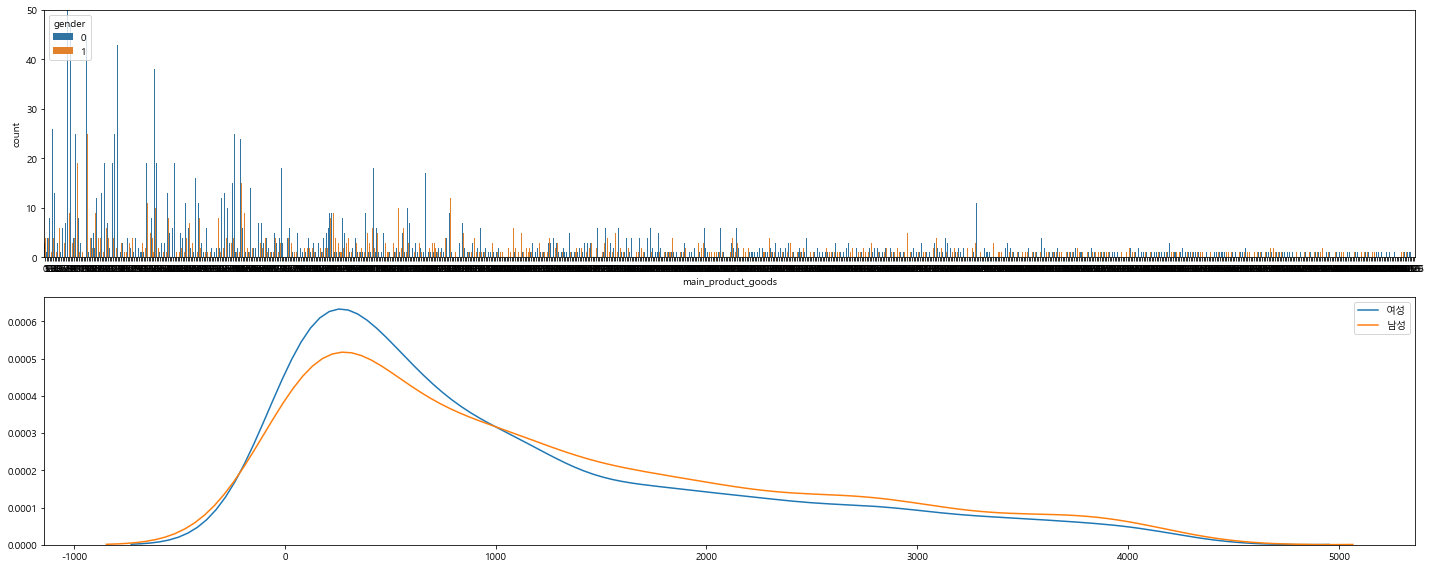

In [96]:
f = tr.groupby('cust_id')['goods_id'].agg([
    ('main_product_goods', lambda x: x.value_counts().index[0])
]).reset_index()

str_name = f.main_product_goods.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.main_product_goods = f.main_product_goods.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_goods', hue='gender', ax=ax[0])
ax[0].set_ylim(0,50)
sns.kdeplot(f.query('gender==0').main_product_goods, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_goods, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 주구매상품2
    - 총 324개 중 203개로 겹치는 gds_grp_nm이 존재한다
    - 겹치면서 많이 구매한 물품들에 있어서 남/녀를 구분할 수 있는 제품들이 있기 때문에 피쳐로 채택

In [97]:
for i in trs:
    
    f = i.groupby('cust_id')['gds_grp_nm'].agg([
        ('main_product_nm', lambda x: x.value_counts().index[0])
    ]).reset_index()
    
    # 주구매상품중분류 문자를 숫자로 바꿔주기
    str_name = f.main_product_nm.unique().tolist()
    num_name = [i for i in range(len(str_name))]
    f.main_product_nm = f.main_product_nm.map(dict(zip(str_name, num_name)))
    
    features.append(f); f

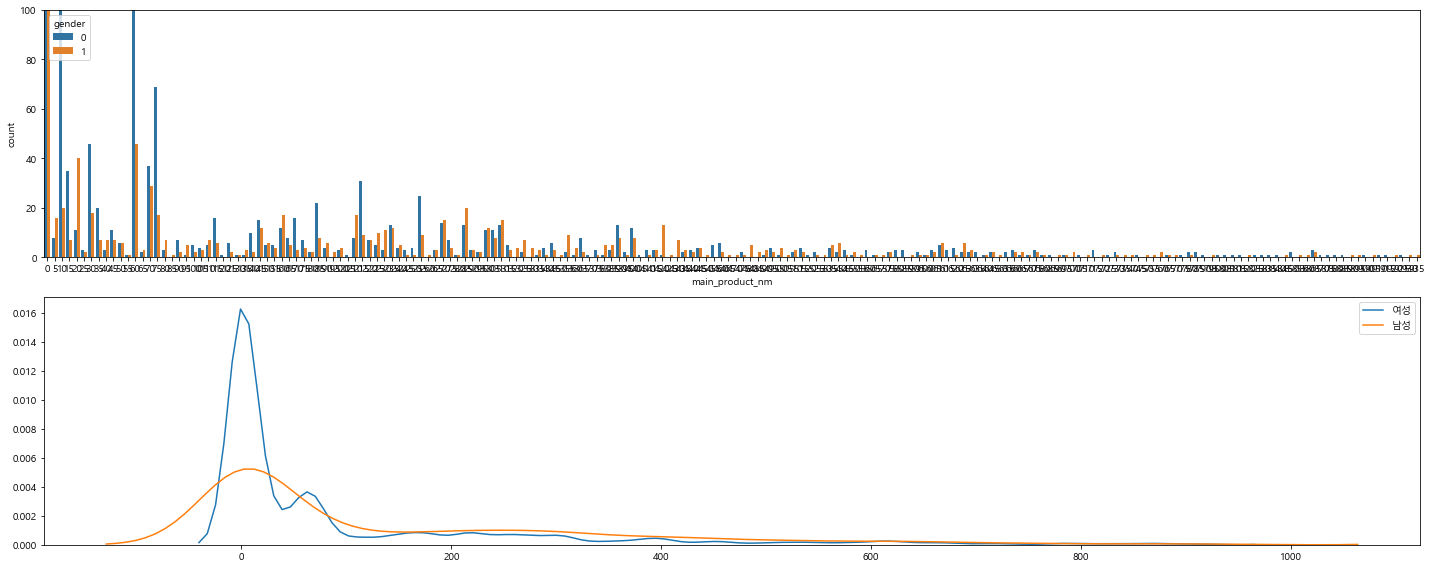

In [98]:
f = tr.groupby('cust_id')['gds_grp_nm'].agg([('main_product_nm', lambda x: x.value_counts().index[0])]).reset_index()

str_name = f.main_product_nm.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.main_product_nm = f.main_product_nm.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_nm', hue='gender', ax=ax[0])
ax[0].set_ylim(0,100)
sns.kdeplot(f.query('gender==0').main_product_nm, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_nm, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 주구매상품3
    - 총 49개 중 42개로 겹치는 gds_grp_mclas_nm이 존재한다
    - 겹치면서 많이 구매한 물품들에 있어서 남/녀를 구분할 수 있는 제품들이 있기 때문에 피쳐로 채택

가장 많이 구매한 상품(gds_grp_mclas_nm)


In [99]:
for i in trs:

    f = i.groupby('cust_id')['gds_grp_mclas_nm'].agg([
        ('main_product_mclas', lambda x: x.value_counts().index[0])
    ]).reset_index()
    
    # 주구매상품대분류 문자를 숫자로 바꿔주기
    str_name = f.main_product_mclas.unique().tolist()
    num_name = [i for i in range(len(str_name))]
    f.main_product_mclas = f.main_product_mclas.map(dict(zip(str_name, num_name)))

    features.append(f); f

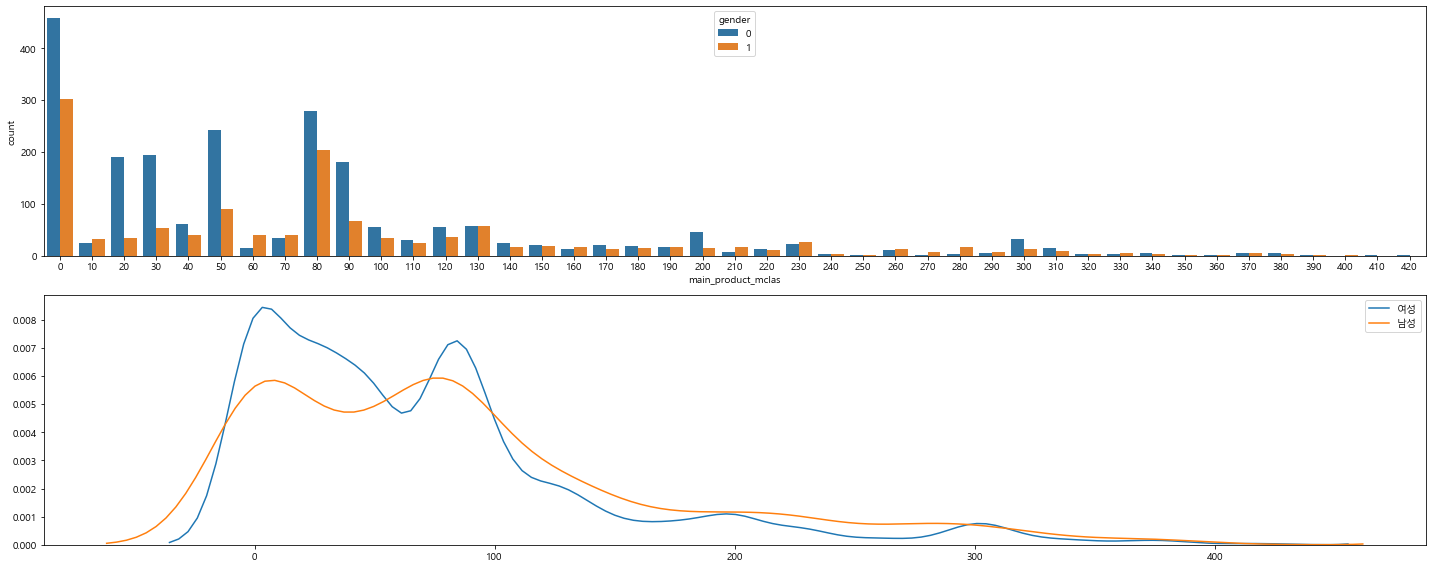

In [100]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([('main_product_mclas', lambda x: x.value_counts().index[0])]).reset_index()

# 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.main_product_mclas.unique().tolist()
num_name = [i*10 for i in range(len(str_name))]
f.main_product_mclas = f.main_product_mclas.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_mclas', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').main_product_mclas, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_mclas, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()


구매추세패턴2

In [101]:
# 상반기,하반기 총 구매금액 비교해서 상승세(1), 하락세(0)으로 나누기.
for i in trs:
    
    start = str(pd.to_datetime(i.tran_date.max()) - pd.offsets.MonthBegin(6))
    f1 = i.query('tran_date < @start').groupby('cust_id')['amount'].agg([
        (f'상반기_구매금액', np.sum)
    ]).reset_index()
    f2 = i.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'하반기_구매금액', np.sum)
    ]).reset_index()
    f = pd.merge(f1,f2, on='cust_id', how ='outer')
    f = f.fillna(0)
    f['purchase_pattern'] = np.where(f['상반기_구매금액'] <= f['하반기_구매금액'], 1, 0)
    f = f[['cust_id', 'purchase_pattern']]

    features.append(f)

<font color = 'blue'> 상품별 구매순서

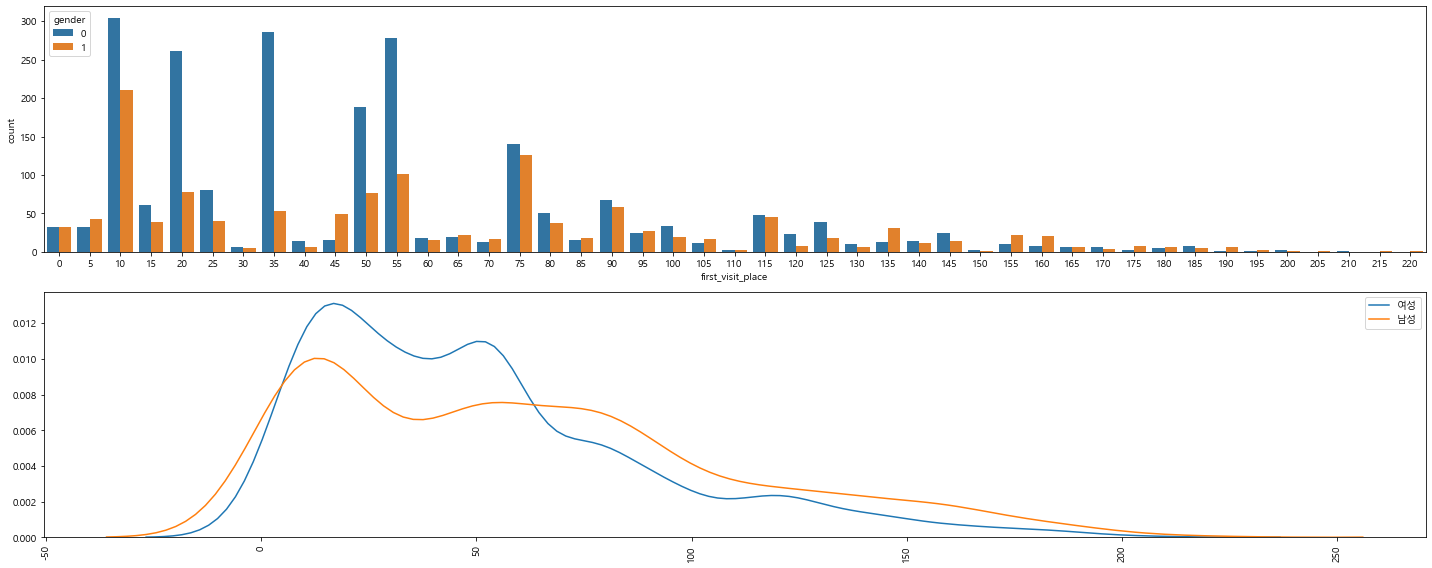

In [102]:
temp_lst = []
for i in range(3500):
    temp_lst.append(tr.query(f'cust_id == {i}').drop_duplicates('tran_date')['gds_grp_mclas_nm'].value_counts().index[0])

f = pd.DataFrame({'cust_id': np.arange(3500)})
f['first_visit_place'] = temp_lst

# 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.first_visit_place.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.first_visit_place = f.first_visit_place.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='first_visit_place', hue='gender', ax=ax[0])
plt.xticks(rotation=90)
sns.kdeplot(f.query('gender==0').first_visit_place, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').first_visit_place, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매상품종류1(goods_id), 구매상품종류2(gds_grp_nm), 구매상품종류3(gds_grp_mclas_nm)

In [103]:
for i in trs:
    
    f = i.groupby('cust_id').agg({
        'goods_id': [('num_pur_type1', lambda x: x.nunique())],
        'gds_grp_nm': [('num_pur_type2', lambda x: x.nunique())],
        'gds_grp_mclas_nm': [('num_pur_type3', lambda x: x.nunique())]
    })

    f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
    f=f.reset_index()
    features.append(f); f

In [104]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('num_pur_type1', lambda x: x.nunique())],
    'gds_grp_nm': [('num_pur_type2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('num_pur_type3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()

f['gender'] = y_train['gender']

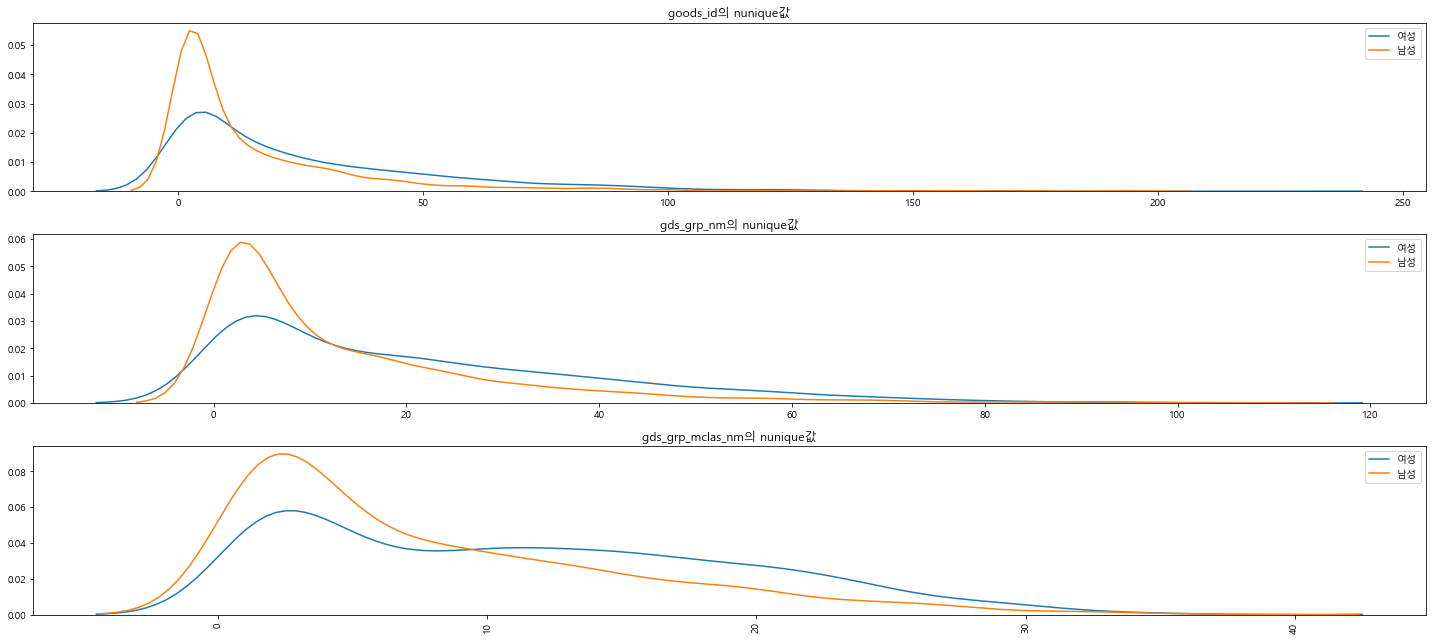

In [105]:
figure , ax = plt.subplots(3, 1, figsize=(20,9))

for i in range(3):
    sns.kdeplot(f.query('gender==0')[f'num_pur_type{i+1}'], label='여성', ax=ax[i])
    sns.kdeplot(f.query('gender==1')[f'num_pur_type{i+1}'], label='남성', ax=ax[i])
ax[0].set_title('goods_id의 nunique값')
ax[1].set_title('gds_grp_nm의 nunique값')
ax[2].set_title('gds_grp_mclas_nm의 nunique값')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 상품 분류별  top-x 구매금액비율 , 구매건수
 - 상품분류별 중 90퍼센트 이상을 차지하는 상품들의 구매금액비율과 구매건수를 구한다
 - train과 test에서 겹치는 부분을 뽑아내기 때문에 칼럼 수가 줄어든다.
        - goods_id(상품소분류별) top550 구매금액비율, 구매건수
        - gds_grp_nm(상품중분류별) top75 구매금액비율, 구매건수
        - gds_grp_mclas_nm(상품대분류별) top25 구매금액비율, 구매건수
        
###The ratio of top-x purchases by product classification , the number of purchases
- Obtain the purchase price ratio and the number of purchases of goods that account for more than 90 percent of each product category.
- The number of columns is reduced because overlapping parts are extracted from the train and test.
- goods_id (by product category) top550 purchase amount ratio, number of purchases
- Gds_grp_nm (by product division) top75 purchase price ratio and number of purchases
- Gds_grp_mclas_nm(by product large category) Top25 purchase price ratio, number of purchases

<font color = 'blue'> 많이 구매한 상품소분류별 best-x 구매금액비율, 구매건수(3471 중 x)

In [106]:
top550goods_all = []

for i in trs:

    ## 전체 구매금액
    total = i.amount.sum()

    ## 전체 구매금액 중 goods_id top550이 전체의 90퍼센트 정도를 차지한다.

    top550 = i.groupby('goods_id')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:550]

    top550sum = top550['amount'].sum()

    top550goods = top550['goods_id'].tolist()

    top550goods_all.append(top550goods)

    print(top550sum / total)

0.9034186144204891
0.910431874144973


In [107]:
## 교차항목 뽑아내기

train_top550 = top550goods_all[0]; print(len(train_top550))
test_top550 = top550goods_all[1]; print(len(test_top550))
print()
intersection550 = list(set(train_top550).intersection(test_top550)); print('겹치는 항목:',len(intersection550))

550
550

겹치는 항목: 483


In [108]:
for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
    
    # 고객별 전체 구매금액
    totalsum = i.groupby('cust_id')['amount'].sum()

    temp_goodsdf = i.query('goods_id in @intersection550')
    
## intersection550 구매금액비율    
    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='goods_id', values='amount', aggfunc=sum, fill_value=0)
    
    for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

    f = temp_goodspivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)

## intersection550 구매금액건수

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

    # 변수명이 겹치는 것을 막기 위해서 변수명을 다르게 바꿔주는 과정
    oldname = temp_goodspivot.columns.tolist()
    newname = [(str(i)+'_buy') for i in oldname]
    temp_goodspivot = temp_goodspivot.rename(columns = dict(zip(oldname, newname)))

    f2 = temp_goodspivot.reset_index() # 3258행
    f = pd.merge(f, f2, how='outer').fillna(0)

    features.append(f); f

<font color = 'blue'> 많이 구매한 상품중분류별 best-y 구매금액비율, 구매건수비율(324 중 y)

In [109]:
top75goods_all = []

for i in trs:
    
    ## 전체 구매금액
    total = i.amount.sum()

    ## 전체 구매금액 중 gds_grp_nm top75이 전체의 90퍼센트 정도를 차지한다.

    top75 = i.groupby('gds_grp_nm')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:75]

    top75sum = top75['amount'].sum()

    top75goods = top75['gds_grp_nm'].tolist()
    
    top75goods_all.append(top75goods)

    print(top75sum / total)

0.9099637919037719
0.9127326259610689


In [110]:
## 교차항목 뽑아내기

train_top75 = top75goods_all[0]; print(len(train_top75))
test_top75 = top75goods_all[1]; print(len(test_top75))
print()
intersection75 = list(set(train_top75).intersection(test_top75)); print('겹치는 항목:',len(intersection75))

75
75

겹치는 항목: 72


In [111]:
for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
        
    # 고객별 전체 구매금액
    totalsum = i.groupby('cust_id')['amount'].sum()

## intersection75 구매금액비율
    temp_goodsdf = i.query('gds_grp_nm in @intersection75')

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_nm', values='amount', aggfunc=sum, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'grp_nm' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))    
    
    for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

    f = temp_goodspivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)


## intersection75 구매금액건수

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_nm', values='amount', aggfunc=np.size, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'grp_nm_buy' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))  

    f2 = temp_goodspivot.reset_index()
    f = pd.merge(f, f2, how='outer').fillna(0)

    features.append(f); f


<font color = 'blue'> 많이 구매한 상품대분류별 best-z 구매금액비율, 구매건수비율(49 중 z)

In [112]:
top25goods_all = []

for i in trs:
    
    ## 전체 구매금액
    total = i.amount.sum()

    ## 전체 구매금액 중 gds_grp_mclas_nm top25이 전체의 90퍼센트 정도를 차지한다.
    top25 = i.groupby('gds_grp_mclas_nm')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:25]
    
    top25sum = top25['amount'].sum()
    
    top25goods = top25['gds_grp_mclas_nm'].tolist()
    
    top25goods_all.append(top25goods)

    print(top25sum / total)

0.9232754143371885
0.9259379619745215


In [113]:
## 교차항목 뽑아내기

train_top25 = top25goods_all[0]; print(len(train_top25))
test_top25 = top25goods_all[1]; print(len(test_top25))
print()
intersection25 = list(set(train_top25).intersection(test_top25)); print('겹치는 항목:',len(intersection25))

25
25

겹치는 항목: 24


In [114]:
for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})

    # 고객별 전체 구매금액
    totalsum = i.groupby('cust_id')['amount'].sum()
    
## intersection25 구매금액비율
    temp_goodsdf = i.query('gds_grp_mclas_nm in @intersection25')

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_mclas_nm', values='amount', aggfunc=sum, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'mclas_nm' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))   
    
    for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

    f = temp_goodspivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)

## intersection25 구매건수

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_mclas_nm', values='amount', aggfunc=np.size, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'mclas_nm_buy' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname))) 

    f2 = temp_goodspivot.reset_index()
    f = pd.merge(f, f2, how='outer').fillna(0)

    features.append(f); f

## ────────────────────────────────────────────────────────

### 5.  기타적 관점

<font color = 'blue'> 휴면(또는 이탈) 여부1
    - 채택x

In [115]:
## 총 방문일수가 2일 이하인 고객들
f = tr.groupby('cust_id')['tran_date'].nunique().reset_index().query('tran_date in [1, 2]')

f['leave_risk'] = [5 for i in range(len(f.tran_date))]

f = f[['cust_id', 'leave_risk']]

f['gender'] = y_train['gender']

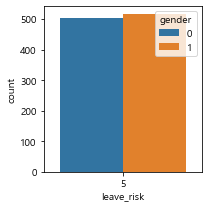

In [116]:
plt.figure(figsize=(3,3))
sns.countplot(data=f, x='leave_risk', hue='gender')

plt.tight_layout()
plt.show()

<font color = 'blue'> 휴면(또는 이탈) 여부2

In [117]:
# 마지막 상품을 구매하고 현재(2008-01-01)까지 기간(휴면기간)이 100일 보다 크면 
# 휴면 상태(0), 아니면 정상상태(1)
for i in trs:
    
    today = '2008-01-01'
    today = datetime.datetime.strptime(today, "%Y-%m-%d").date()
    today = pd.Timestamp(today)
    f = i.groupby('cust_id')['tran_date'].agg([
        ('휴면기간', lambda x: int((today - x.astype('datetime64').max()).days))
    ]).reset_index()
    f['isleave'] = np.where(f['휴면기간'] >= 100, 0, 1)
    f = f[['cust_id', 'isleave']]

    features.append(f)

## 남녀가 어떤 상품들을 구매하는지, 상품으로써 남녀를 구분하는 피쳐를 생성하고자 한다

 ### process
  #### ch.1 -> 남성경향제품 구매여부(조건: 남성이 여성보다 구매수가 많으면서 남성이 적어도 3번이상 구매한 제품)
    
    - 1. 상품대분류명 살펴보기(gds_grp_mclas_nm)
    - 2. 상품중분류명 살펴보기(gds_grp_nm)
    - 3. 상품소분류명 살펴보기(goods_id)
    - 4. goods_id에서 남성이 여성보다 더 많이 구매한 물품목록 뽑아내기
    - 5. 뽑아낸 물품목록으로 피쳐 생성하기
    
 ***
  #### ch.2 -> 여성경향제품 구매여부(조건: 여성만 구매 & 여성이 최소 해당 물품 3회이상 구매 & 여성 최소 3명이 해당 물품구매)
              -> (or 이 아니라 and로 모두 해당 조건을 모두 만족하는 물품만 뽑았다)
    - 1. 남성만 혹은 여성만 구매하는 제품을 조사
    - 2. 여성만 구매한 제품목록 뽑아내기
    - 3. 뽑아낸 물품목록으로 피쳐 생성하기
 ***
    -> 뽑아낸 피쳐 저장: train_eda_gender_tendency, test_eda_gender_tendency

## ch.1
### 1. countplot으로 상품대분류명 grp_mclas_nm 살펴보기

상품대분류명들을 다시 한번 관련있는 상품들끼리 묶어서 all_mclas에 넣었다   
그리고 다음과 같이 모든 상품대분류명을 시각화하여 보았더니 모든 대분류명 상품군에 있어서 여성의 구매수가 더 많았다

 - 이는 데이터의 불균형때문에 일어난 것으로 보이며
 - 대분류명에서는 남성이 더 많이 구매한 물품을 찾아볼 수 없었으므로 더 구체적으로 상품중중분류명(gds_grp_nm)을 살펴보기로 하였다
 
     -> 데이터 내에서 남성을 구분할 수 있는 상품군을 찾아내야 할 것 같다

In [118]:
clothes =['시티웨어', '디자이너', '셔츠', '란제리/내의', '섬유잡화', '캐주얼', '구두', '피혁잡화', '모피/피혁']

clothes2 = ['남성정장', '남성 캐주얼', '남성 트랜디', '커리어', '기타의류']

cosmos = ['화장품', '액세서리']

luxury = ['명품', '준보석/시계', '보석']

sports = ['스포츠','골프', '트래디셔널']

foods = ['축산가공', '건강식품','육류', '수산품', '젓갈/반찬', '가공식품', '농산물', '차/커피' ]

furniture = ['가구', '악기']

etc = ['기타', '침구/수예', '일용잡화', '주방용품', '식기', '주류', '생활잡화']

electronics = ['주방가전', '소형가전', '대형가전', '통신/컴퓨터', '전자/전기']

kids = ['아동', '교복', '문구/팬시']

ambiguous = ['웨딩', '멀티(아울렛)']

all_mclas = [clothes, clothes2, cosmos, luxury, sports, foods, furniture, etc, electronics, kids, ambiguous]

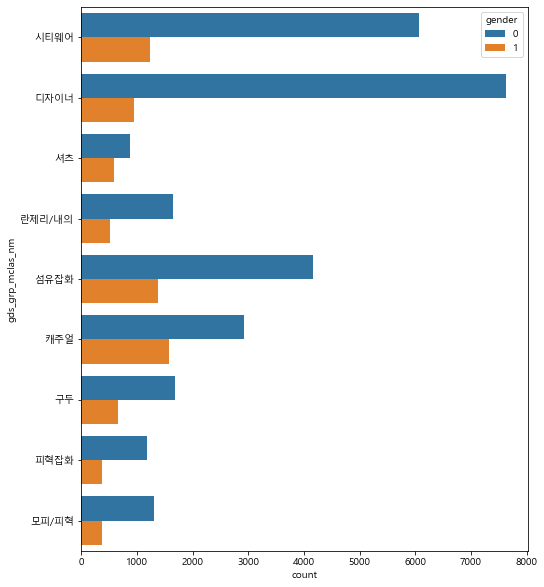

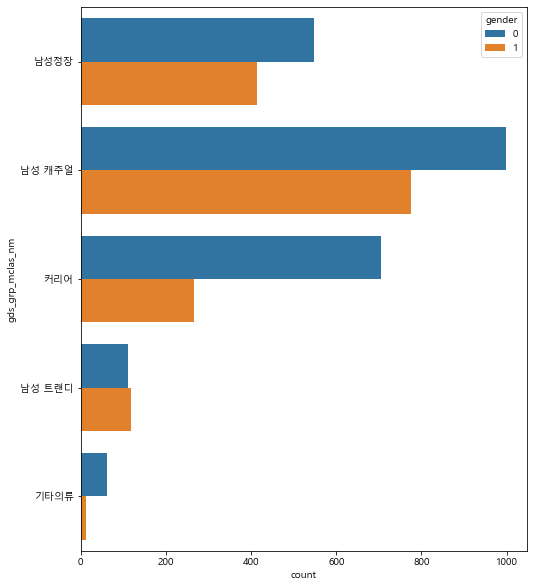

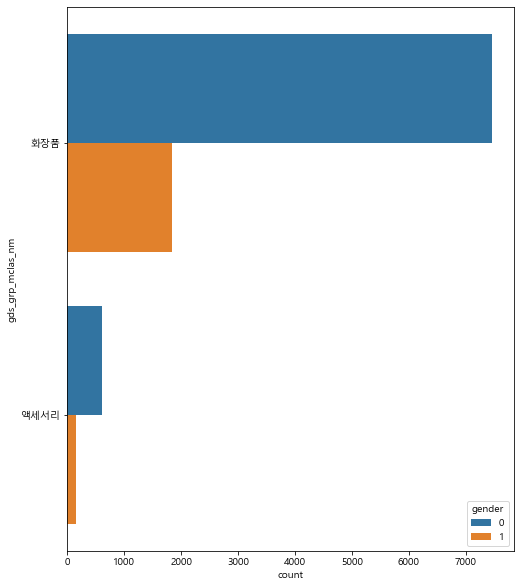

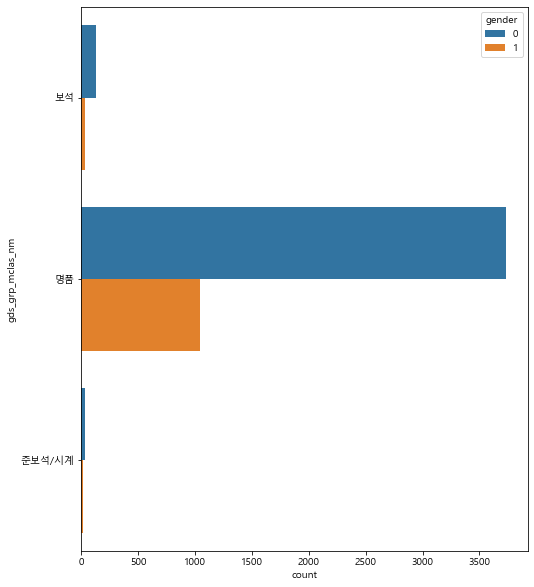

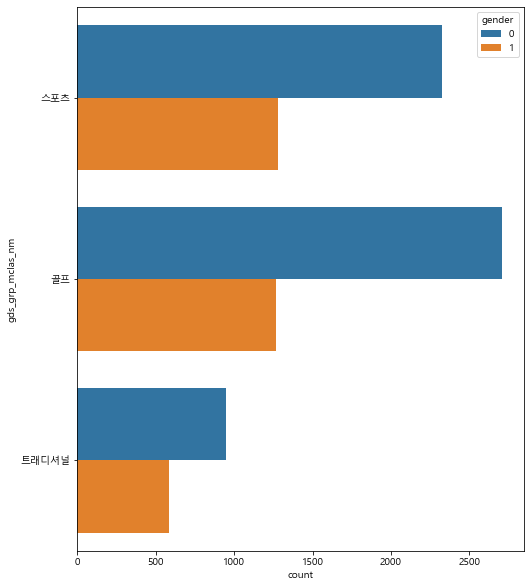

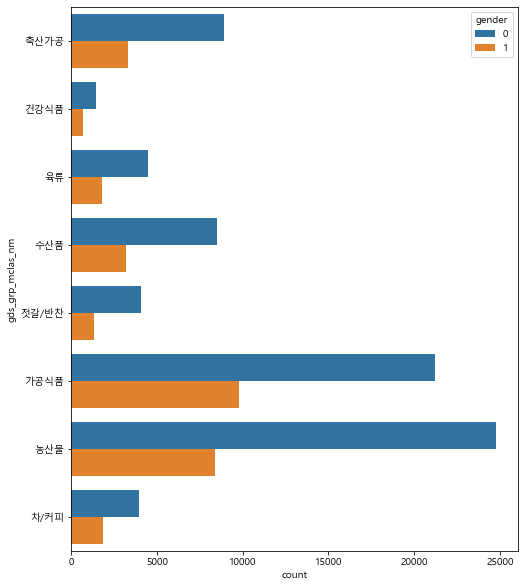

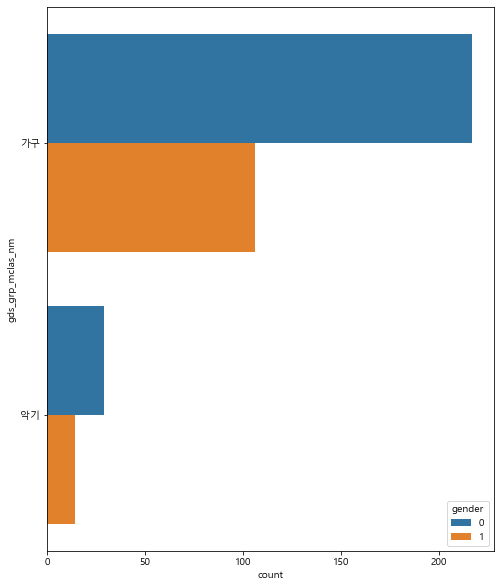

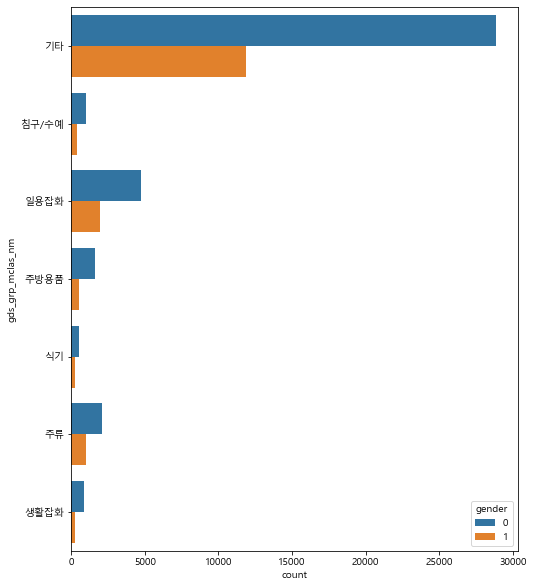

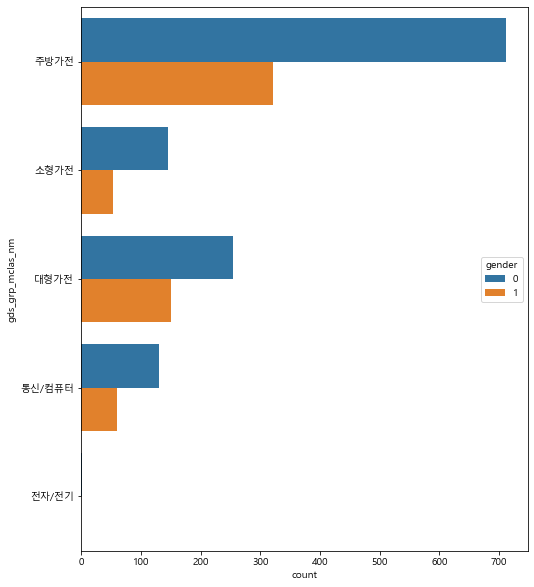

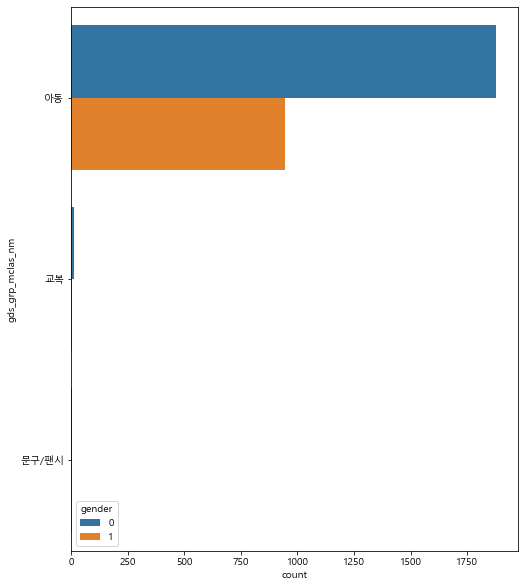

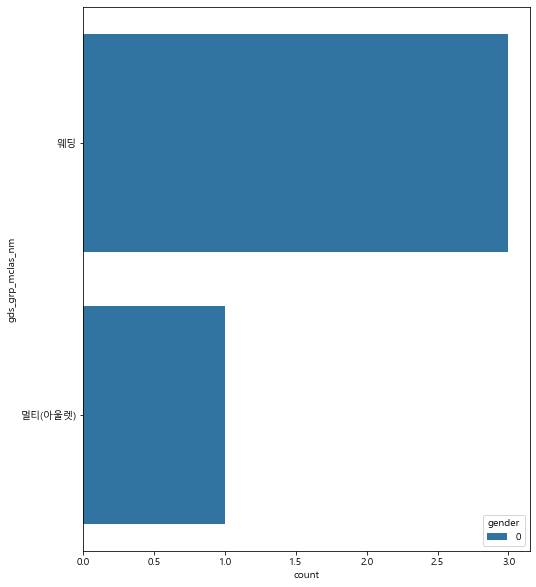

In [119]:
plt.rcParams['figure.figsize'] = [8, 10] # [width, height] (inches)
for mclas in all_mclas:
    
    display(sns.countplot(data=tr.query(f'gds_grp_mclas_nm in {mclas}'), y='gds_grp_mclas_nm', hue='gender'))
    plt.show()

### 2. countplot 으로 상품중분류명 grp_nm 살펴보기

 - 상품중분류명을 countplot으로 살펴본 결과 여성보다 남성이 구매수가 더 많은 상품들이 있다
     - 트랜디, 명품남성, 유아용품 이 이에 해당한다
 - 명품남성 같은 경우에는 남여 예측에 좋은 구분이 되겠지만, 다른 남성코너에서는 실제로 여성의 구매가 더 많았으므로 이는 남녀를 구분하기에 아직 정보가 부족하다고 생각되어서 상품소분류명까지 보기로 하였다

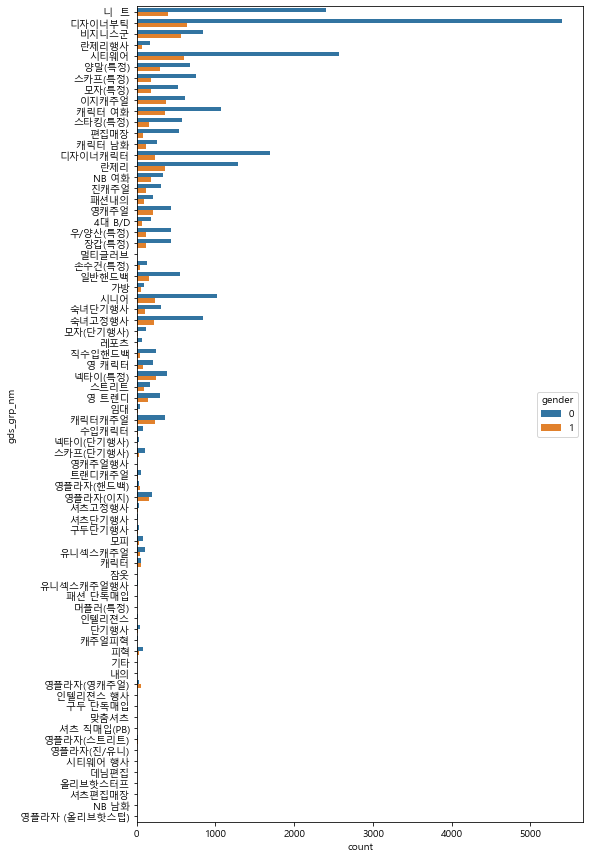

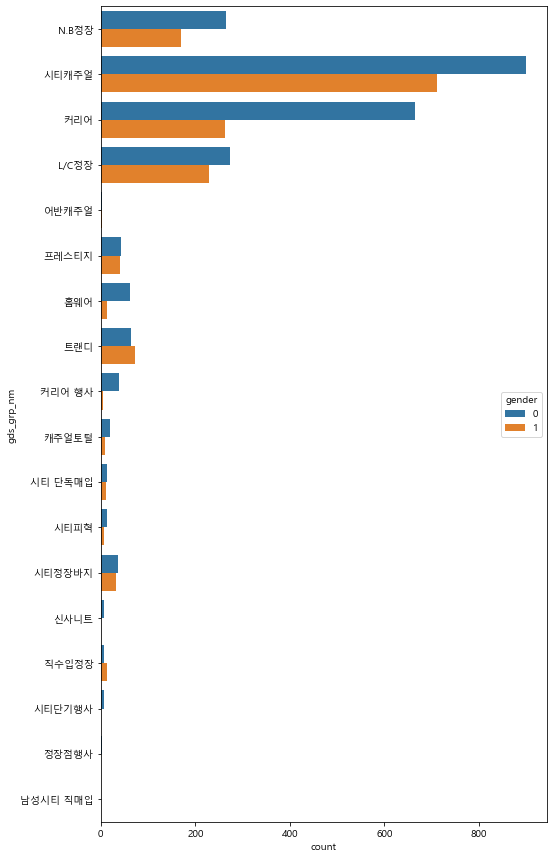

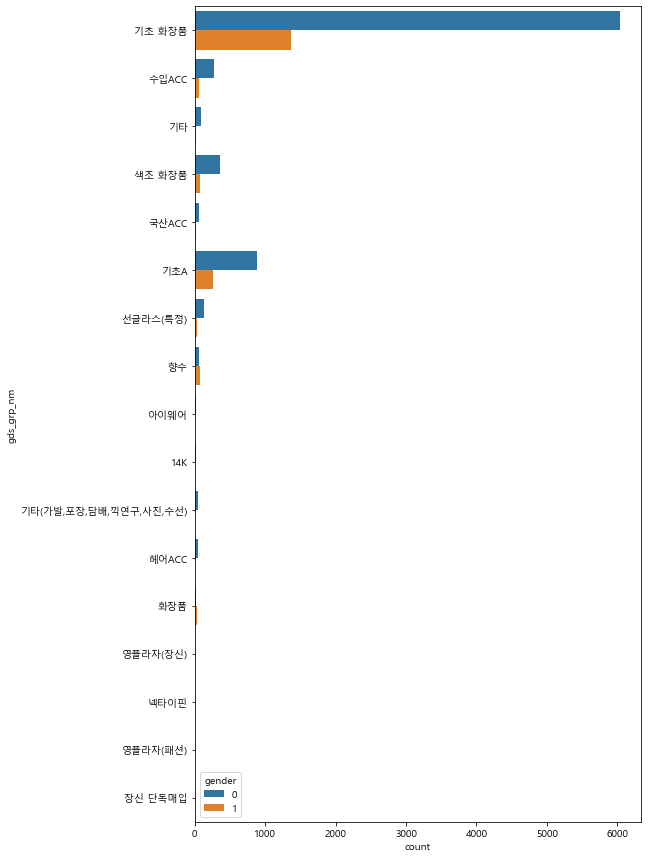

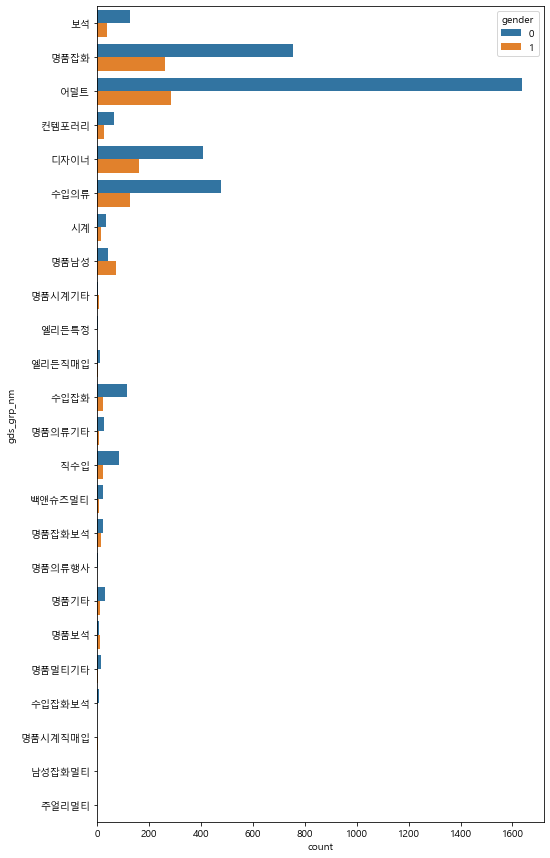

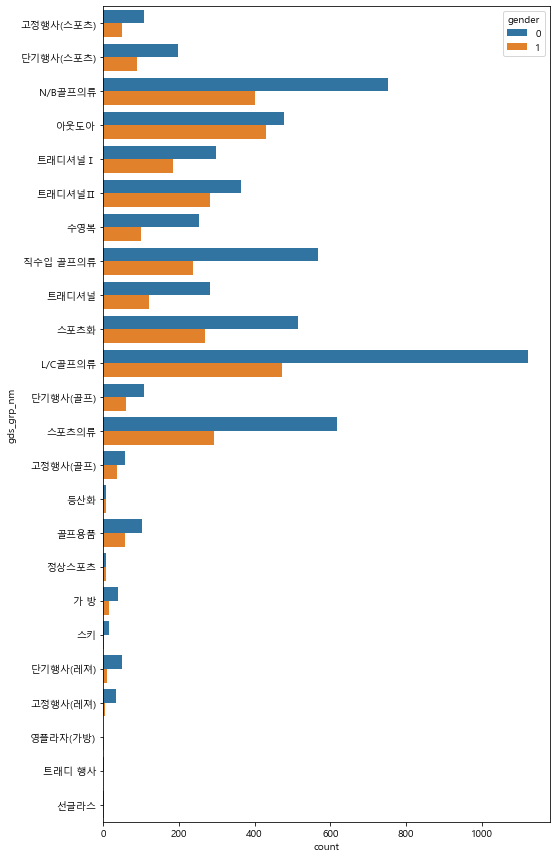

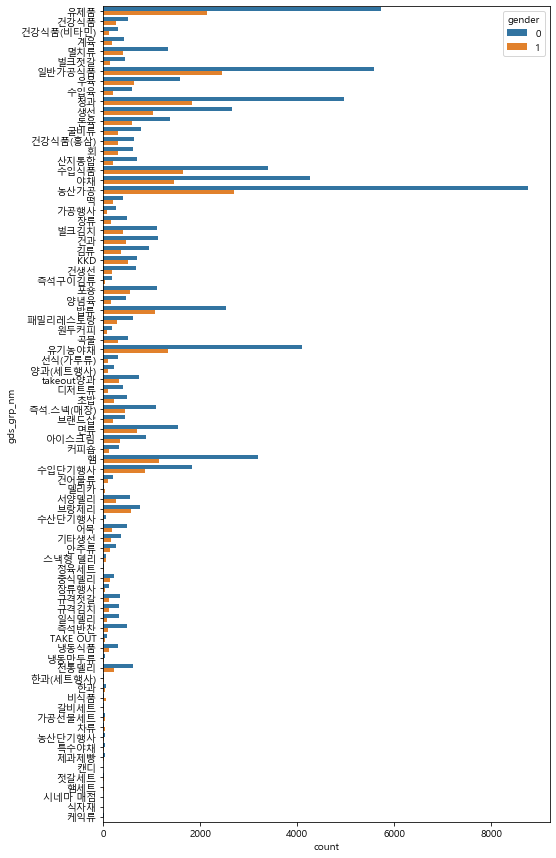

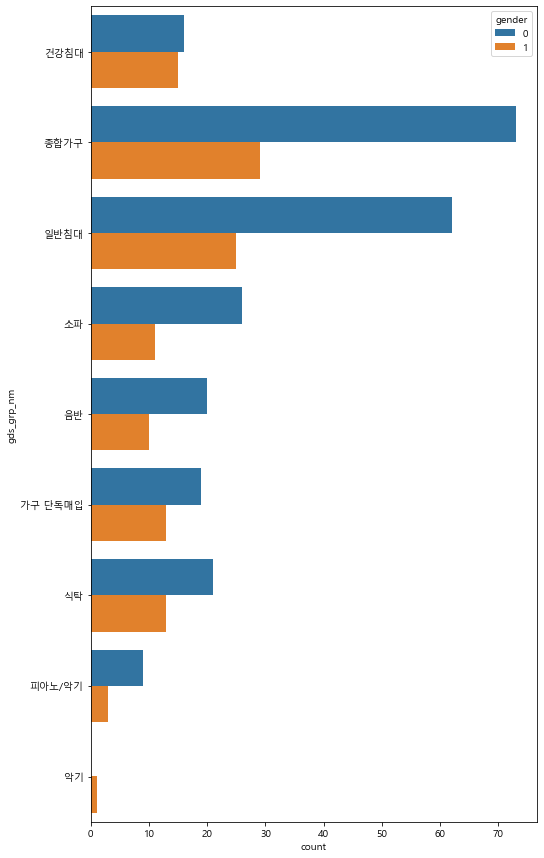

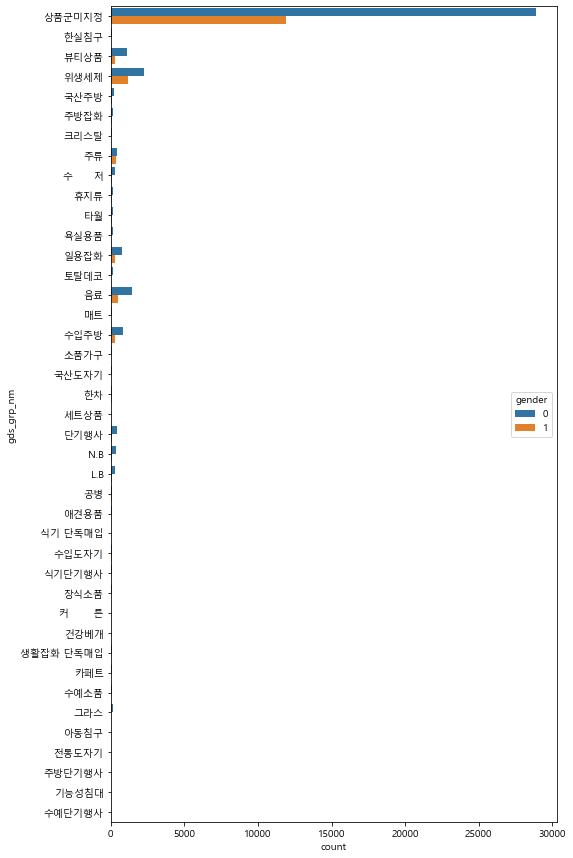

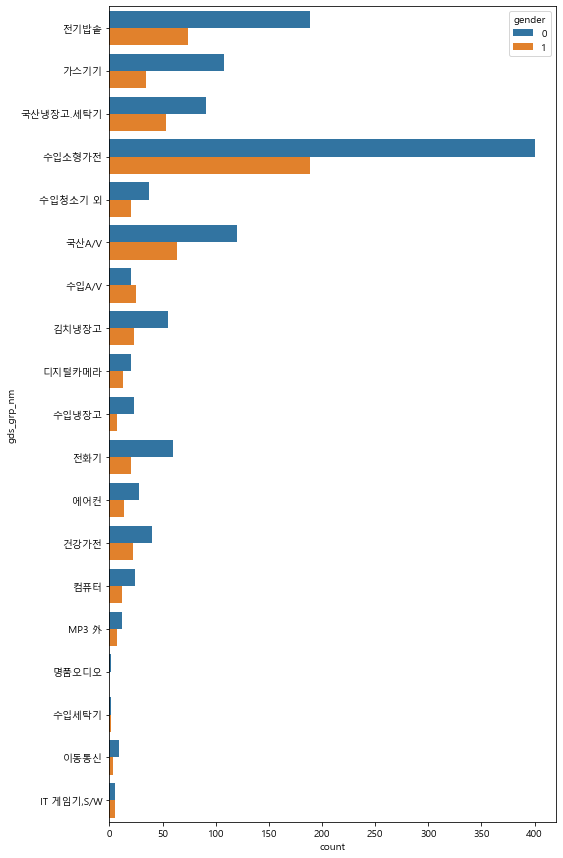

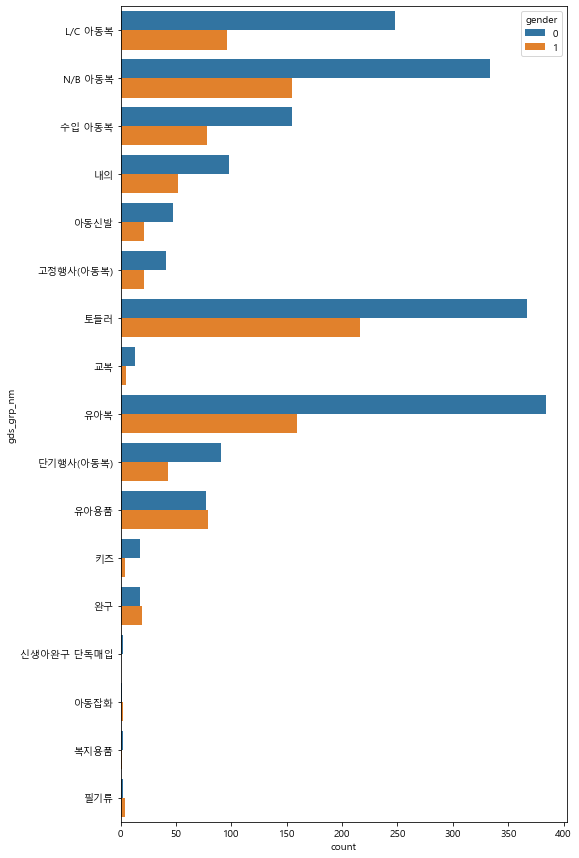

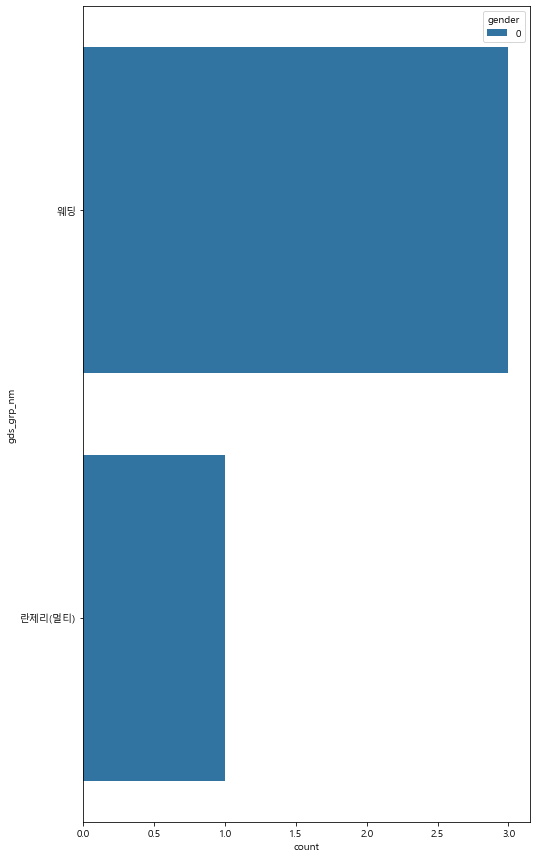

In [120]:
plt.rcParams['figure.figsize'] = [8, 15] # [width, height] (inches)
for mclas in all_mclas:
    
    display(sns.countplot(data=tr.query(f'gds_grp_mclas_nm in {mclas}'), y='gds_grp_nm', hue='gender'))
    plt.show()

### 3. countplot 으로 상품소분류명 살펴보기

 - 물품이 너무 많아 잘 보이지는 않지만 남성 전용의 물품인지 남성경향의 물품인지 확실히 남성들이 더 많이 구매하는 물품들이 보인다
 - 이에 그러한 goods_id 물품들을 모두 뽑아내기로 하였다

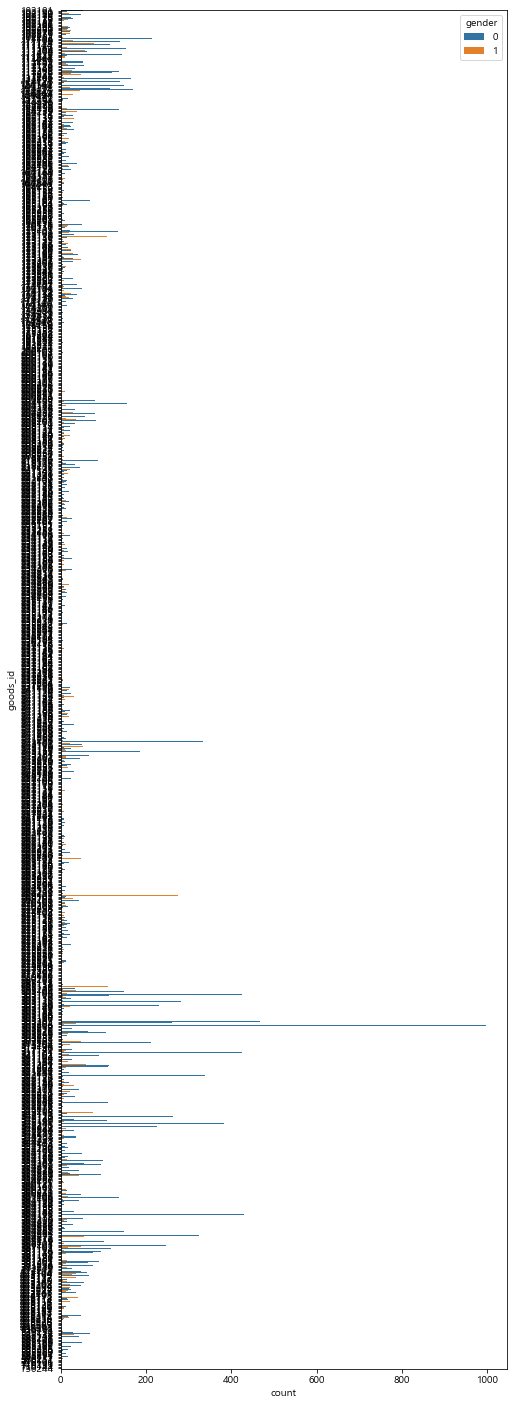

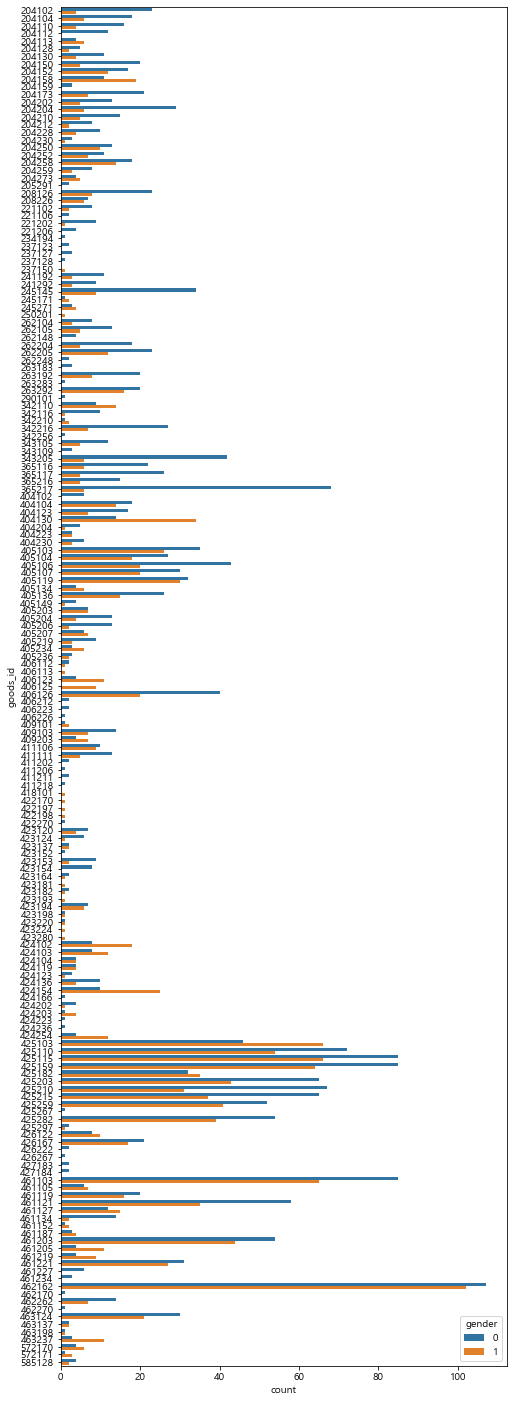

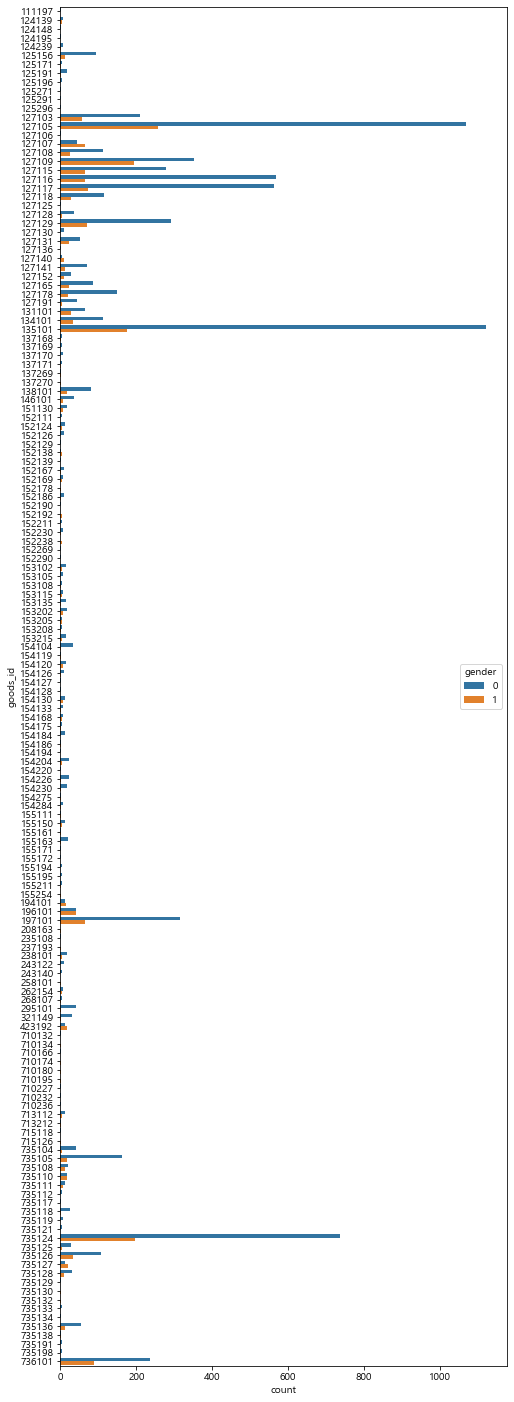

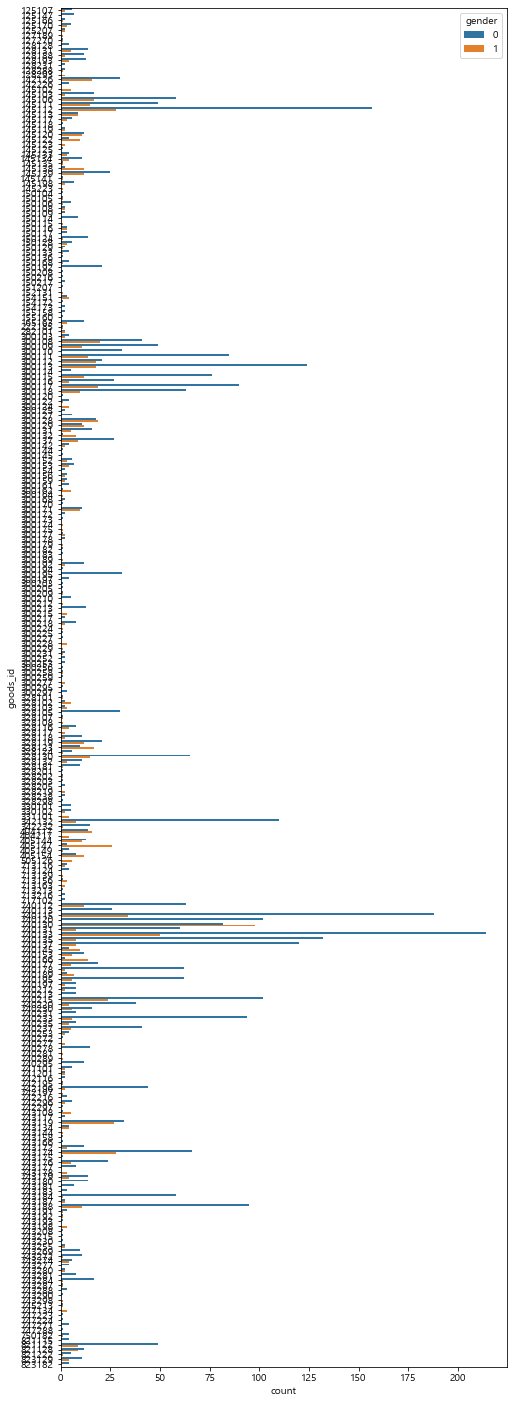

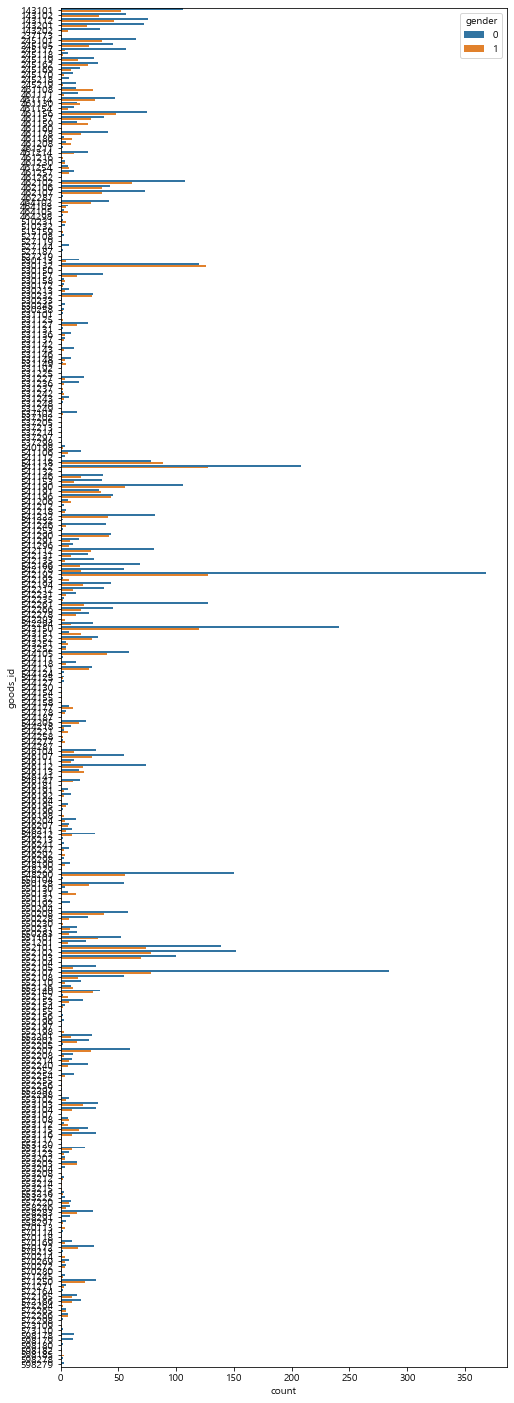

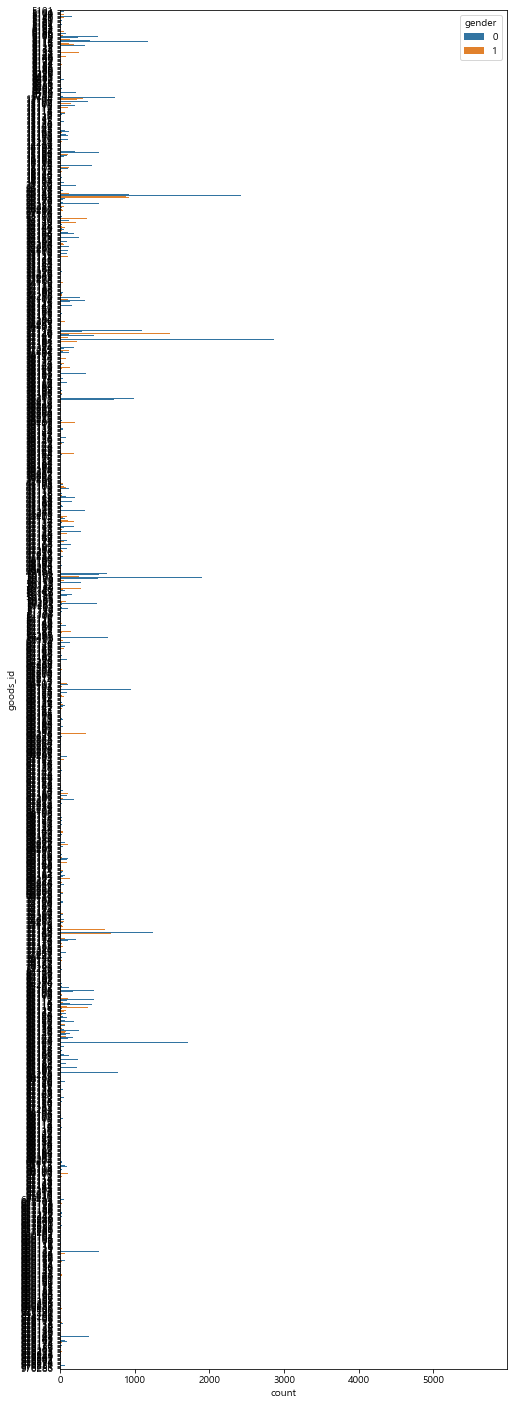

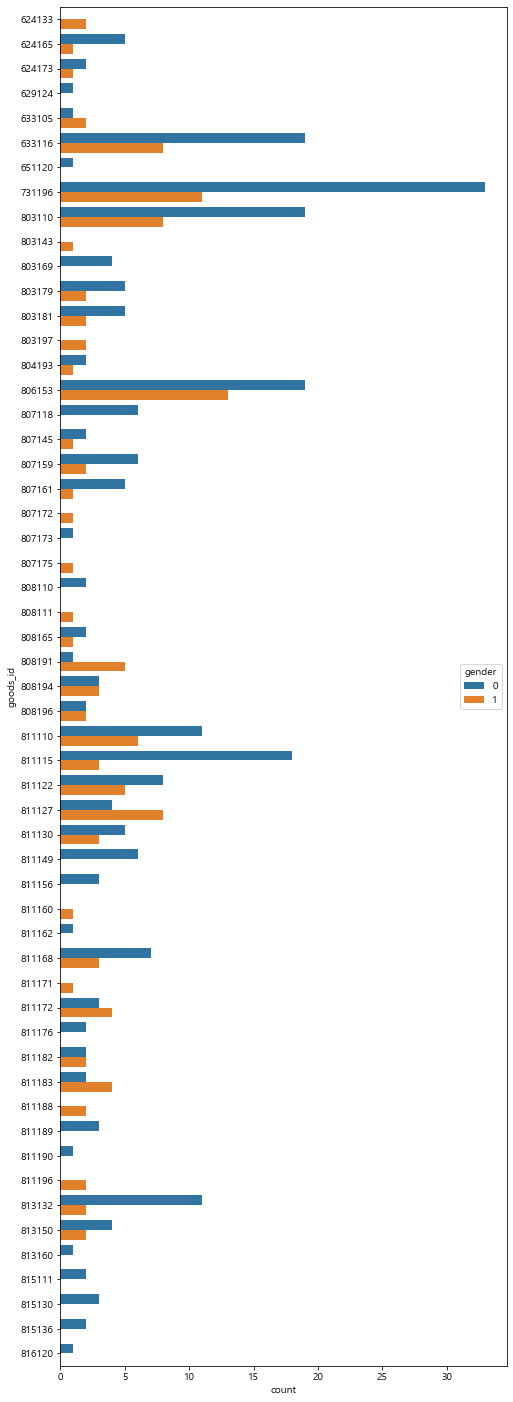

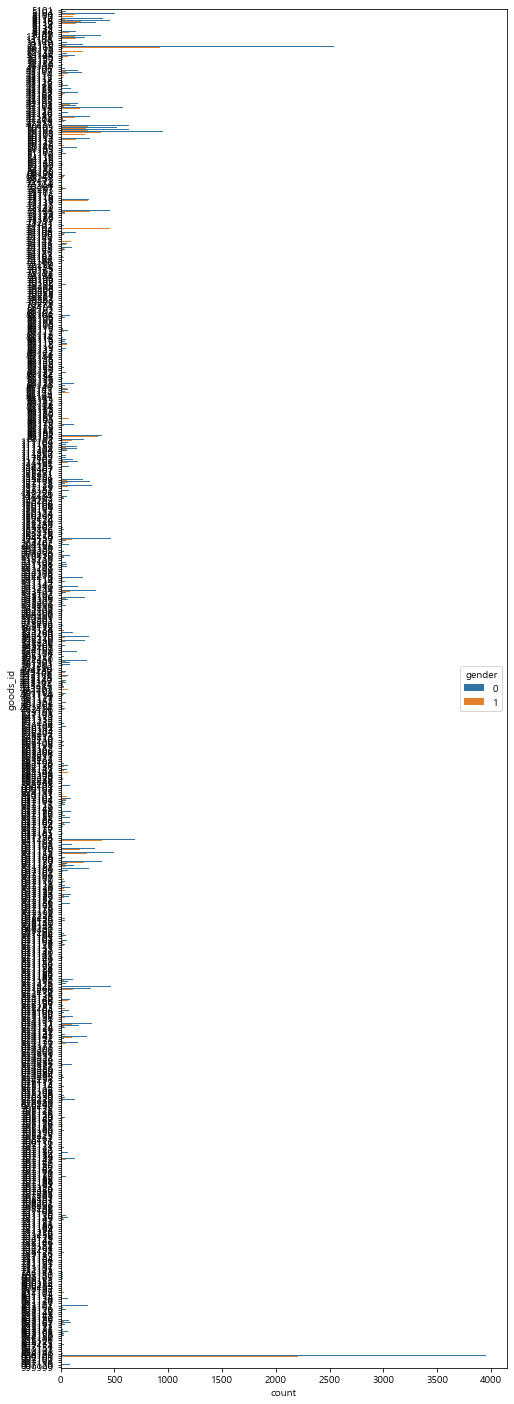

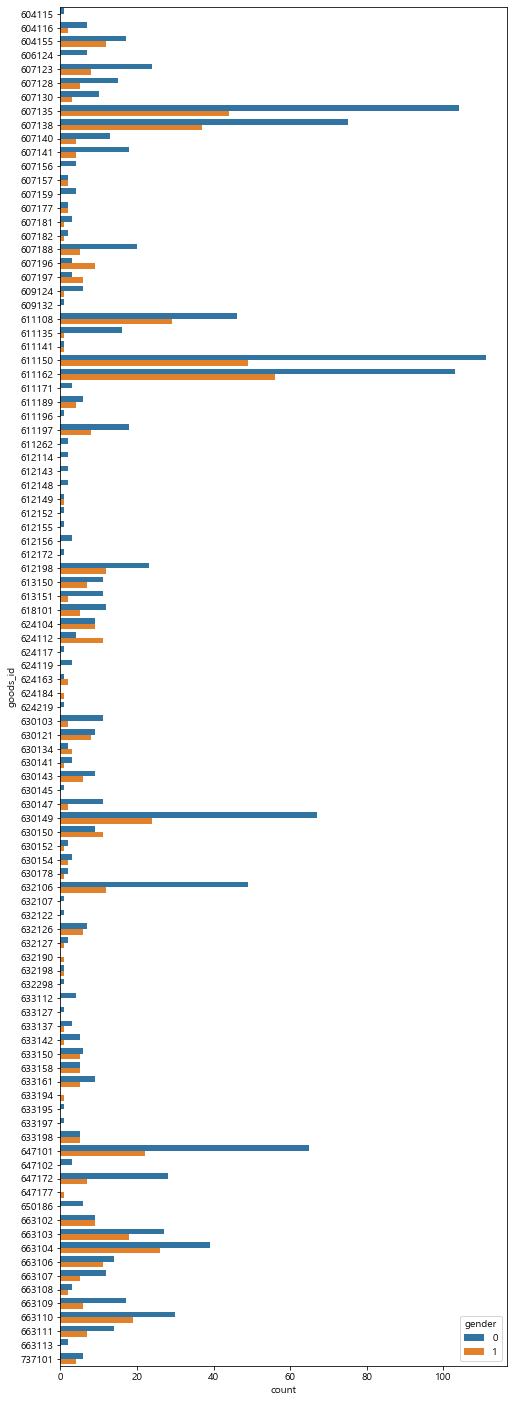

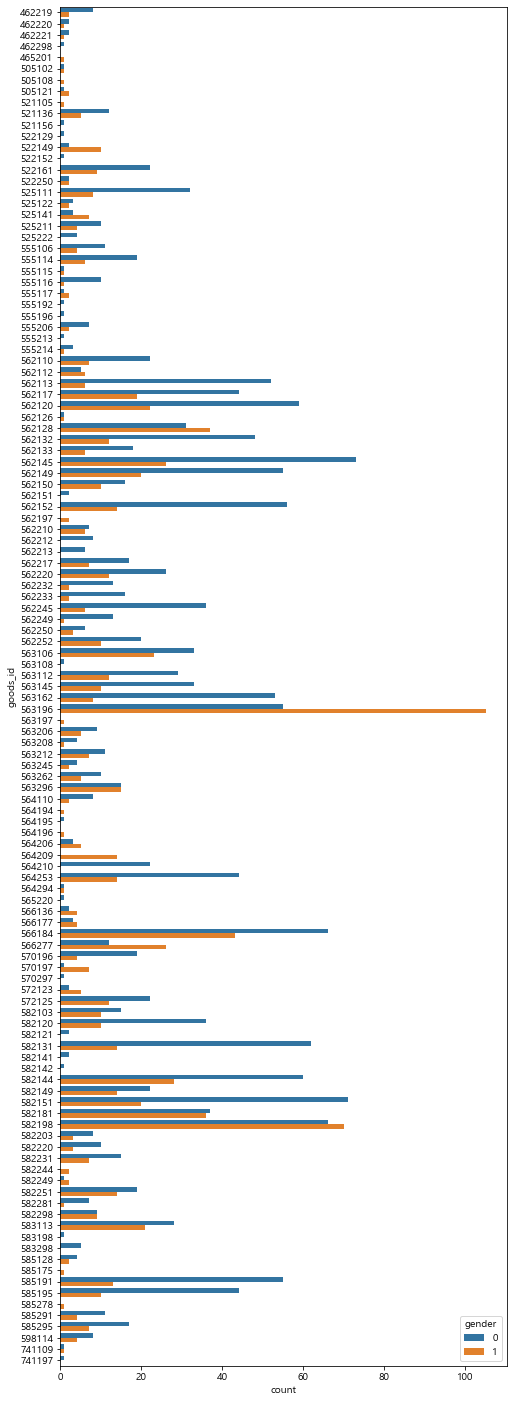

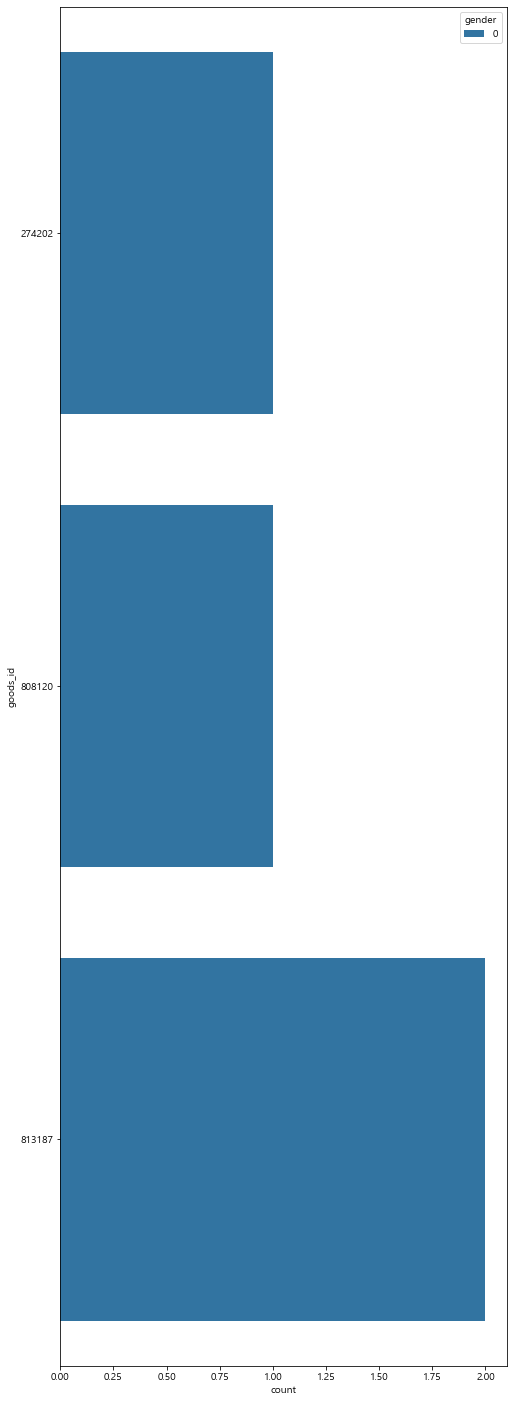

In [121]:
plt.rcParams['figure.figsize'] = [8, 25] # [width, height] (inches)
for mclas in all_mclas:
    
    display(sns.countplot(data=tr.query(f'gds_grp_mclas_nm in {mclas}'), y='goods_id', hue='gender'))
    plt.show()

### 4. goods_id에서 남성이 여성보다 더 많이 구매한 물품목록 뽑아내기

   - 남성이 여성보다 구매를 더 많이하면서, 남성이 3회이상 구매한 물품목록을 뽑아내었다
        - 위 조건에 해당하는 goods_id는 313개의 물품이 나왔다

In [122]:
temp_goodsdf = pd.pivot_table(tr, index = 'goods_id', columns='gender', values='amount', aggfunc=np.size, fill_value=0)

temp_goodsdf = temp_goodsdf.rename(columns={0:'women',1:'men'})

temp_goodsdf.query('men > women and men > 2')[:15]

gender    women  men
goods_id            
5130         26   52
6163          2    3
6188          0    8
8134          4    8
8144          6   12
8190         13   36
8290          0    3
13109         0   20
13114         7   12
14198         5    8
26285        37   49
26290        30   34
33142         0    4
33288         1    3
34112         2    3

In [123]:
# 남성이 더 구매경향을 보이는 goods_id 상품들을 리스트로 뽑아내었다

men_tendency_product = temp_goodsdf.query('men > women and men > 2').index.tolist()

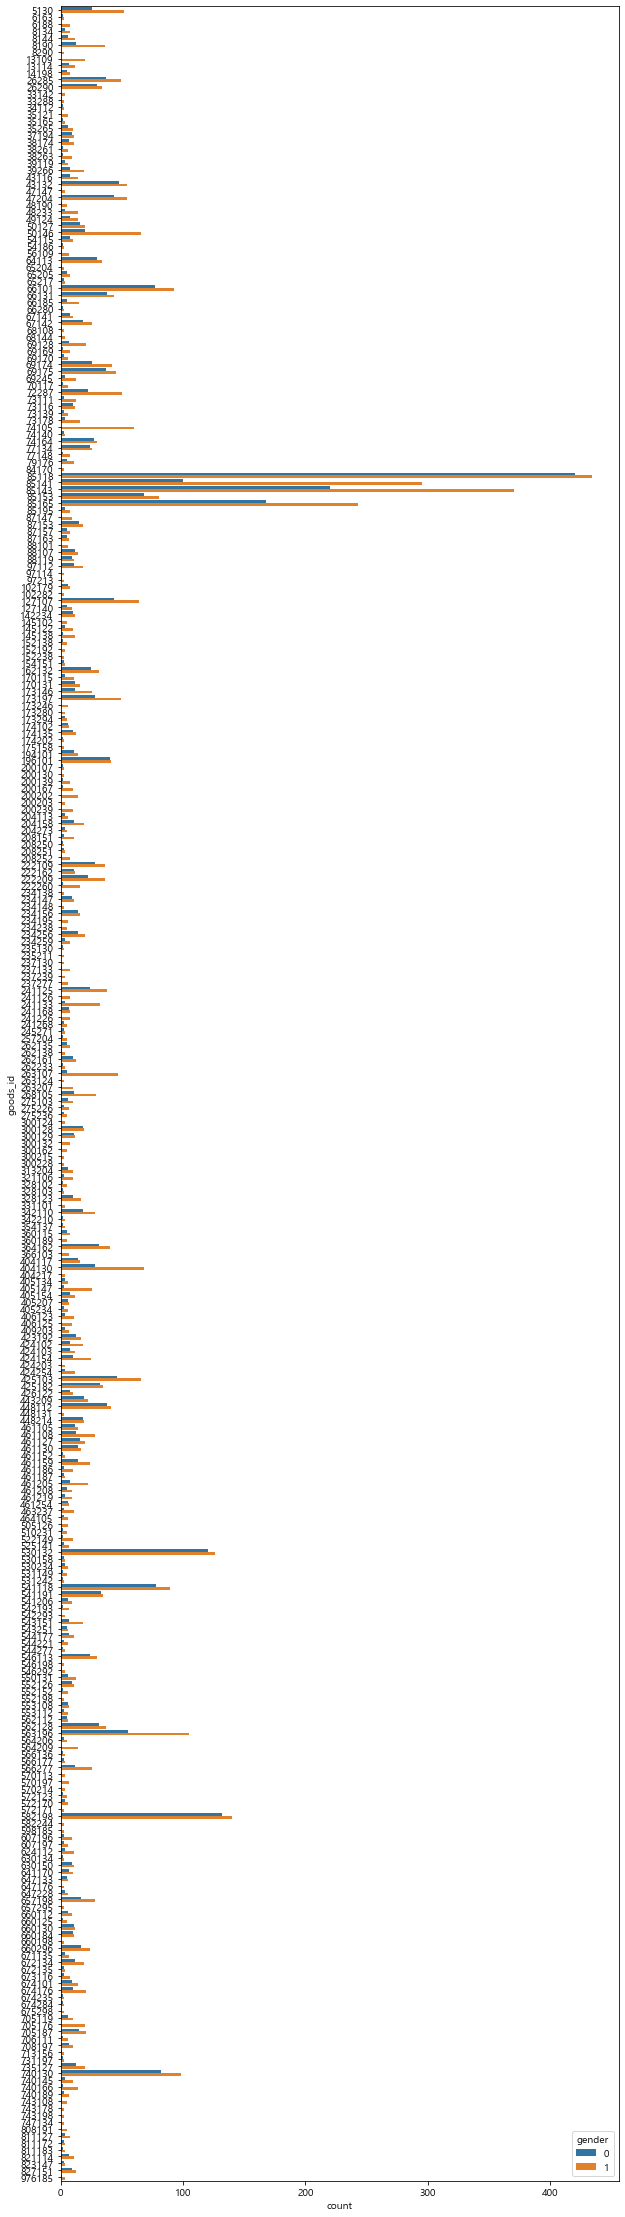

In [124]:
plt.rcParams['figure.figsize'] = [10, 40] # [width, height] (inches)
sns.countplot(data=tr.query('goods_id in @men_tendency_product'), y='goods_id', hue='gender')
plt.show()

### 5. 뽑아낸 물품목록으로 피쳐 생성하기

    - 0. tr2에서도 이에 해당하는 물품들을 뽑아내고 교집합물품들을 뽑아낸다 -> men_tendency_intersection
    - 1. men_tendency_product에 해당하는 goods_id를 구매하였는지 구매여부
    - 2. men_tendency_product의 구매건수

0. tr2에서도 조건에 해당하는 물품을 뽑아서 교집합하기

In [125]:
men_tendency_product2 = []

for goods_id in men_tendency_product:
    
    if goods_id in tr2.goods_id.unique():
        
        men_tendency_product2.append(goods_id)

In [126]:
# 교집합 품목을 뽑아낸다.
men_tendency_intersection = list(set(men_tendency_product).intersection(men_tendency_product2))

print('교집합 갯수: ', len(men_tendency_intersection))

교집합 갯수:  278


1. 구매여부 -> 구매하였을 경우 10을 주었다

In [127]:
for i in trs:

    temp_goodsdf = pd.pivot_table(i.query('goods_id in @men_tendency_intersection'), index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

# 모든 원소에 대해서 만약 원소가 0보다 크다면 10을 주었다 -> (구매안함: 0, 구매함: 10)
    temp_goodsdf = temp_goodsdf = temp_goodsdf.applymap(lambda x : 10 if x>0 else 0)

# 칼럼명 변경(겹치지 않도록)
    origin_name = temp_goodsdf.columns.tolist()
    new_name = [str(i)+'_M_tenden_isbuy' for i in origin_name]
    temp_goodsdf = temp_goodsdf.rename(columns=dict(zip(origin_name, new_name)))
    
    temp_goodsdf = temp_goodsdf.reset_index()

# nan값 제거    
    if len(i) == 232004:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500)]})
    else:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500, 5982)]})
    f = pd.merge(merge_temp, temp_goodsdf, how='outer').fillna(0).astype(int)
    features.append(f); f

## ch.2

### 1. 남성만 혹은 여성만 구매하는 제품을 조사

   - 남성들만 혹은 여성들만 구매한 제품군들이 있음을 확인
        - 데이터 불균형을 해소하고자 남성을 구분할 수 있도록 남성들만 쓰는 제품들을 살펴보았으나 goods_id까지 봤지만 데이터가 600여개로 너무 적었음
        - 이에 차라리 데이터가 많은 여성측에서 여성경향이 강한 제품들로 여성을 구분하고자 함

In [128]:
print("---- 전체 ----")

print('대분류: ', tr.gds_grp_mclas_nm.nunique())

print('중분류: ', tr.gds_grp_nm.nunique())

print('소분류: ', tr.goods_id.nunique())

print('\n\n---- 남성 ----')

print('대분류: ', tr.query('gender == 1').gds_grp_mclas_nm.nunique())

print('중분류: ', tr.query('gender == 1').gds_grp_nm.nunique())

print('소분류: ', tr.query('gender == 1').goods_id.nunique())

print('\n\n---- 여성 ----')

print('대분류: ', tr.query('gender == 0').gds_grp_mclas_nm.nunique())

print('중분류: ',tr.query('gender == 0').gds_grp_nm.nunique())

print('소분류: ',tr.query('gender == 0').goods_id.nunique())

---- 전체 ----
대분류:  49
중분류:  324
소분류:  3471


---- 남성 ----
대분류:  46
중분류:  308
소분류:  2618


---- 여성 ----
대분류:  49
중분류:  315
소분류:  3200


## 2. 여성만 쓰는 제품목록 뽑아내기

 - 여성들만 구매하는 제품목록을 대분류 -> 중분류 -> 소분류 순으로 살펴본 결과 대분류, 중분류만으로는 데이터가 너무 적어 구분하기 어렵다고 판단
 - 여성들만 구매하는 소분류(goods_id)제품들을 리스트로 뽑아내었음
     - 조건1: 여성들만 구매
     - 조건2: 여성들이 적어도 3회 이상 구매
     - 조건3: 여성들이 적어도 3명 이상 구매
 - 조건을 모두 만족시키는 제품군을 뽑아서 여성을 구분하는 피쳐를 만들고자 함

조건1

In [129]:
w_use_goods = tr.query('gender == 0').goods_id.unique().tolist()

m_use_goods = tr.query('gender == 1').goods_id.unique().tolist()

all_use_goods = tr.goods_id.unique().tolist()

In [130]:
w_goods = []
for goods in all_use_goods:
     if goods not in m_use_goods:
            w_goods.append(goods)

print('\n여성의 수: ',tr.query('gender == 0').cust_id.nunique())
print('\n여성경향 물품을 구매한 여성 수: ', tr.query('goods_id in @w_goods')['cust_id'].nunique())
print(f'\n여성경향 물품을 구매한 여성 비율: {788 / 2184:.4}')

print('\n여성들만 쓰는 제품수: ', len(w_goods))


여성의 수:  2184

여성경향 물품을 구매한 여성 수:  788

여성경향 물품을 구매한 여성 비율: 0.3608

여성들만 쓰는 제품수:  853


조건2 와 조건3

In [131]:
w_buymorethan3df = tr.query('gender == 0').groupby('cust_id')['goods_id'].value_counts().rename().reset_index().rename(columns={0:'count'})

w_buymorethan3lst = w_buymorethan3df.query('count >= 3').goods_id.unique().tolist()

print('여성들이 3회이상 구매한 물품 목록 수: ', len(w_buymorethan3lst))

w_goodsdf = tr.query('gender == 0').goods_id.value_counts().reset_index().query('goods_id>=3').rename(columns={'index':'goods_id','goods_id':'count'})

w_morethan3pplbuy = w_goodsdf.goods_id.unique().tolist()

print('\n여성들이 3명이상 구매한 물품 목록 수: ', len(w_morethan3pplbuy))

여성들이 3회이상 구매한 물품 목록 수:  1511

여성들이 3명이상 구매한 물품 목록 수:  2367


조건 1,2,3을 모두 만족하는 물품목록(여성만 구매, 여성이 3회이상 구매, 여성이 3명이상 구매)

In [132]:
# 조건1과 조건2 교집합
con1AndCon2 = set(w_goods).intersection(w_buymorethan3lst)

# 교집합된 목록과 조건3의 교집합
w_tendency_product = list(con1AndCon2.intersection(w_morethan3pplbuy))

print('교집합된 물품 목록 수: ', len(w_tendency_product))

교집합된 물품 목록 수:  155


##  3. 뽑아낸 물품목록으로 피쳐 생성하기

 - test데이터도 같은 과정을 거쳐 피쳐를 생성해야하나 gender가 없기 때문에 test데이터의 goods_id와 교집합
 - 둘다 만족하는 최종 w_tendency_product를 토대로 피쳐생성
     - 1. 여성경향 물품 구매건수
     - 2. 여성경향 물품 구매여부

In [133]:
# test데이터의 goods_id 목록
tr2_goodslst = tr2.goods_id.unique().tolist()

# test데이터에도 존재하는 여성경향 몰품 목록 찾기
final_w_tendency_product = []
for product in w_tendency_product:
    
    if product in tr2_goodslst:
        
        final_w_tendency_product.append(product)

# 최종 여성경향 물품목록 추출
print(final_w_tendency_product)
print()
print('개수: ', len(final_w_tendency_product))

[262148, 72204, 221206, 47127, 731171, 562212, 5160, 262189, 303153, 303158, 88120, 88123, 152126, 26179, 67148, 300110, 322128, 641106, 300114, 66136, 87132, 300127, 150114, 257124, 67173, 364135, 43126, 303225, 64124, 364158, 85119, 342143, 322176, 404102, 66186, 85131, 660108, 660106, 85134, 175257, 300195, 85155, 342181, 85160, 300213, 85181, 173245, 303295, 233152, 85187, 807118, 275156, 321247, 84192, 637155, 235243, 423154, 550130, 976118, 43267, 38151, 743177, 191242, 743180, 743181, 740113, 234262, 740120, 274202, 84279, 34106, 16195, 204112, 35152, 674137, 54106, 54110, 38245, 33126, 743281, 354167, 823159, 77178, 821115, 33150, 352130, 54146, 821126, 976263, 740231, 32138, 248198, 165260, 73102, 38287, 676240, 164252, 74147, 546213, 671146, 79273, 461227, 33198, 35247, 671152, 243122, 461234, 740278, 243140, 8135, 740295, 222154, 650186, 35287, 564210, 8183, 8186]

개수:  117


이러한 물품을 구매한 여성의 비율

In [134]:
print('전체 여성 수:', tr.query('gender == 0').cust_id.nunique())

print('\n여성 경향 물품을 구매한 여성 수:', tr.query('goods_id in @final_w_tendency_product').cust_id.nunique())

print(f'\n여성 경향 물품을 구매한 여성의 비율: {350/2184:.4}')

전체 여성 수: 2184

여성 경향 물품을 구매한 여성 수: 350

여성 경향 물품을 구매한 여성의 비율: 0.1603


2. 여성경향 물품 구매여부

In [135]:
for i in trs:

    w_tempdf = pd.pivot_table(i.query('goods_id in @final_w_tendency_product'), index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

# 구매여부 조건: 샀을경우 20 아니면 0
    w_tempdf = w_tempdf.applymap(lambda x: 20 if x > 0 else 0)

    origin = w_tempdf.columns.tolist()
    new_name = [str(i)+'_w_ten_isbuy' for i in range(len(origin))]
    w_tempdf = w_tempdf.rename(columns=dict(zip(origin, new_name)))

    if len(i) == 232004:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500)]})
    else:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500,5982)]})

    w_tempdf = w_tempdf.reset_index()

    f = pd.merge(merge_temp, w_tempdf, how='outer').fillna(0)
    features.append(f); f

### Merge & Save Features


In [136]:
for i in features:
    if len(i) == 3500:
        features1.append(i)
    else:
        features2.append(i)
print(len(features1))
print(len(features2))

both_features = [features1, features2]

35
35


In [137]:
data = pd.DataFrame({'cust_id': tr.cust_id.unique()})
for f in features1 :
    data = pd.merge(data, f, how='left')
display(data)
data.to_csv('X_train_after_eda.csv', index=False, encoding='cp949')
data.info()

cust_id  class total_amount_range2 purchase_count  \
0           0    600                   6             80   
1           1    100                   0             10   
2           2    100                   0             10   
3           3    300                   1             50   
4           4    400                   2             10   
...       ...    ...                 ...            ...   
3495     3495    100                   0             10   
3496     3496    400                   2             20   
3497     3497    100                   0             10   
3498     3498    100                   0             10   
3499     3499    700                  26            100   

     total_amount_avg_range1 max_amount_range2  per_visit_pur_num  \
0                          9                 2                  4   
1                          7                 1                  2   
2                          7                 1                  2   
3                          3                 1                  2   
4                         96                 3                  2   
...                      ...               ...                ...   
3495                      15                 1                  2   
3496                      22                 1                  2   
3497                       0                 1                  1   
3498                       9                 1                  1   
3499                      28                 4                  2   

     total_visit2 buying_cycle2  perfer_season  spring_pur_ratio  \
0               9             8              1          0.094595   
1               0             0              2          0.000000   
2               0             0              3          0.000000   
3               8             7              0          0.590909   
4               0            42              2          0.333333   
...           ...           ...            ...               ...   
3495            0             0              1          0.000000   
3496            3            19              2          0.076923   
3497            0             0              3          0.000000   
3498            0            19              3          0.500000   
3499           18             3              1          0.271739   

      summer_pur_ratio  fall_pur_ratio  winter_pur_ratio  prefer_month  \
0             0.391892        0.378378          0.135135            10   
1             0.000000        1.000000          0.000000            10   
2             0.000000        0.000000          1.000000             1   
3             0.159091        0.113636          0.136364             3   
4             0.000000        0.666667          0.000000            11   
...                ...             ...               ...           ...   
3495          1.000000        0.000000          0.000000             6   
3496          0.076923        0.461538          0.384615            12   
3497          0.000000        0.000000          1.000000             1   
3498          0.000000        0.000000          0.500000             1   
3499          0.326087        0.260870          0.141304             6   

      1_month_amount  2_month_amount  9_month_amount  0to10_visits  \
0           0.012448        0.000000        0.027163      0.421053   
1           0.000000        0.000000        0.000000      0.000000   
2           1.000000        0.000000        0.000000      1.000000   
3           0.000000        0.309934        0.028831      0.333333   
4           0.000000        0.000000        0.000000      0.000000   
...              ...             ...             ...           ...   
3495        0.000000        0.000000        0.000000      0.000000   
3496        0.000000        0.243008        0.060836      0.500000   
3497        1.000000        0.000000        0.000000      1.000000   
3498        0.466667        0.000000        0.000000      0.50

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 3499
Columns: 1634 entries, cust_id to 116_w_ten_isbuy
dtypes: category(32), float64(1302), int32(280), int64(20)
memory usage: 39.3 MB


In [138]:
data = pd.DataFrame({'cust_id': tr2.cust_id.unique()})
for f in features2 :
    data = pd.merge(data, f, how='left')
display(data)
data.to_csv('X_test_after_eda.csv', index=False, encoding='cp949')
data.info()

cust_id  class total_amount_range2 purchase_count  \
0        3500    600                   7             20   
1        3501    700                  31            210   
2        3502    700                  30            290   
3        3503    200                   0             10   
4        3504    100                   0             10   
...       ...    ...                 ...            ...   
2477     5977    600                   8             20   
2478     5978    100                   0             10   
2479     5979    700                  26             80   
2480     5980    600                   8             20   
2481     5981    100                   0             10   

     total_amount_avg_range1 max_amount_range2  per_visit_pur_num  \
0                         37                 3                  1   
1                         14                 4                  2   
2                          2                 2                 15   
3                          7                 1                  2   
4                          2                 1                  3   
...                      ...               ...                ...   
2477                      58                 3                  2   
2478                       4                 1                  1   
2479                      36                 3                  4   
2480                      49                 2                  4   
2481                       0                 1                  5   

     total_visit2 buying_cycle2  perfer_season  spring_pur_ratio  \
0               6            12              3          0.210526   
1              44             1              2          0.091324   
2              50             1              1          0.233582   
3               2            23              3          0.100000   
4               1             3              3          0.000000   
...           ...           ...            ...               ...   
2477            3            19              3          0.071429   
2478            0             0              3          0.000000   
2479            9             8              3          0.154930   
2480            2            29              3          0.277778   
2481            0            15              3          0.100000   

      summer_pur_ratio  fall_pur_ratio  winter_pur_ratio  prefer_month  \
0             0.052632        0.157895          0.578947            12   
1             0.356164        0.410959          0.141553            11   
2             0.283683        0.243737          0.238998             1   
3             0.100000        0.000000          0.800000             1   
4             0.000000        0.000000          1.000000             1   
...                ...             ...               ...           ...   
2477          0.285714        0.285714          0.357143             1   
2478          0.000000        0.000000          1.000000             1   
2479          0.225352        0.154930          0.464789             1   
2480          0.166667        0.277778          0.277778             9   
2481          0.000000        0.000000          0.900000             1   

      1_month_amount  2_month_amount  9_month_amount  0to10_visits  \
0           0.044287        0.000000        0.047272      0.307692   
1           0.000000        0.000000        0.106956      0.377778   
2           0.136482        0.043475        0.090551      0.366337   
3           0.959969        0.000000        0.000000      0.600000   
4           0.214162        0.785838        0.000000      0.333333   
...              ...             ...             ...           ...   
2477        0.314211        0.000000        0.000000      0.750000   
2478        1.000000        0.000000        0.000000      0.000000   
2479        0.206069        0.005192        0.105641      0.263158   
2480        0.000000        0.349863        0.205803      0.60

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Columns: 1634 entries, cust_id to 116_w_ten_isbuy
dtypes: category(32), float64(1302), int32(280), int64(20)
memory usage: 27.9 MB


## ────────────────────────────────────────────────────────

###  피쳐 상관관계

#### 1차 피쳐 상관관계

<font color = 'blue'> EDA 이후 채택되지 않은 피쳐들 제거

가격: 가격 선호도, 환불금액, 환불건수, 내점 당 구매액,      
시간: 월별 방문비율, 월별 구매건수, 월초, 월중, 월말 선호 방문때, 최근 3개월, 6개월, 12개월 구매금&구매건수   
장소: 주구매지점   
제품: Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부(겹쳐서)   
기타: 휴면(또는 이탈)여부 

<font color = 'blue'> 같은 관점의 피쳐끼리 상관관계
    - 같은 관점끼리 히트맵을 그려 상관관계가 0.7이상인 칼럼들을 모두 제거하였다
    - 밑의 히트맵은 상관관계가 높았던 칼럼들의 제거 이후에 그린 히트맵이다

상관관계가 0.7이상으로 높아서 삭제한 칼럼들   


가격: none   
시간: 월초, 월중, 월말 구매건수&구매비율, 요일별 구매건수, 주말 구매건수, 1월 구매비율, 수목금 구매비율   
장소: top12 방문비율   
제품: 소중대분류에서 상관관계 높은 상품 162개   
기타: none


In [139]:
df = pd.read_csv('X_train_after_eda.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_eda.csv', encoding='cp949')

In [140]:
high_corr_cols = []

delCol1 = ['0to10_10unit', '11to20_20unit', '21to31_30unit','4_buy', '3_buy', '2_buy','0_buy','6_buy','5_buy','1_buy','weekend_buy2', '1_month_amount','2_month_amount','0to10_amount','0to10_amount','11to20_20unit','21to31_amount','3_amount','2_amount','4_amount']

delCol2 = ['0_visits0','1_visits1','2_visits2','3_visits3','4_visits4','5_visits5','6_visits6','7_visits7','8_visits8','9_visits9','10_visits10']

delCol3 = ['num_pur_type2', 'num_pur_type3']

delCol4 = ['241192', '262241', '263107', '542166', '740195', '742196', '241125_buy', '241133_buy', '241192_buy', '262141_buy', '262241_buy', '263107_buy', '342111_buy', '342132_buy', '562128_buy', '563196_buy', '740195_buy', '742196_buy', '96grp_nm_buy', '141grp_nm_buy', '165grp_nm_buy', '189grp_nm_buy', '195grp_nm_buy', '18mclas_nm_buy', '48mclas_nm_buy', '63mclas_nm_buy', '56108', '607138', '811110', '66123_buy', '77152_buy', '303126_buy', '321103_buy', '542192_buy', '607138_buy', '39grp_nm', '45grp_nm', '192grp_nm', '12grp_nm_buy', '15grp_nm_buy', '36grp_nm_buy', '45grp_nm_buy', '111grp_nm_buy', '3mclas_nm', '15mclas_nm', '15mclas_nm_buy', '21mclas_nm_buy', '45mclas_nm_buy', '26165', '66123', '68273', '73119', '125156', '127118', '127128', '127131', '127141', '128128', '128131', '173197', '204125', '204128', '204152', '204162', '206101', '208102', '208110', '208121', '208140', '222102', '245105', '245117', '245140', '261188', '275131','303125', '303140', '321106', '322103', '322154', '322158', '331101', '342150', '361106', '361206', '365219', '530157', '530232', '541153', '542266', '552110', '562117', '562132', '563112', '611150', '611162', '611189', '613151', '624165', '630134', '647101','663102', '663106', '663108', '663110', '663111', '735105', '735124', '737101', '740112', '740120', '740130', '740131', '740153', '740177', '740178', '740215', '808194', '811115', '811127', '811156', '813150', '823165', '37140_buy', '56108_buy', '73151_buy', '127109_buy', '262161_buy', '303109_buy', '303110_buy', '303146_buy', '303209_buy', '303246_buy', '322111_buy', '322211_buy', '562113_buy', '611150_buy', '618101_buy', '647101_buy', '663106_buy', '731196_buy', '735124_buy', '9grp_nm', '42grp_nm', '54grp_nm', '72grp_nm', '78grp_nm', '93grp_nm', '135grp_nm', '198grp_nm', '42grp_nm_buy', '54grp_nm_buy', '72grp_nm_buy', '78grp_nm_buy', '93grp_nm_buy', '108grp_nm_buy', '117grp_nm_buy', '135grp_nm_buy', '138grp_nm_buy', '171grp_nm_buy', '192grp_nm_buy', '198grp_nm_buy']

delCol5 = ['8134_M_tenden_isbuy', '13109_M_tenden_isbuy', '87147_M_tenden_isbuy', '200202_M_tenden_isbuy', '200239_M_tenden_isbuy', '263107_M_tenden_isbuy', '263207_M_tenden_isbuy', '300215_M_tenden_isbuy', '300228_M_tenden_isbuy', '598185_M_tenden_isbuy', '647176_M_tenden_isbuy', '705176_M_tenden_isbuy', '713156_M_tenden_isbuy']

delCol6 = ['9_w_ten_isbuy', '14_w_ten_isbuy', '39_w_ten_isbuy', '56_w_ten_isbuy', '90_w_ten_isbuy']

high_corr_cols = delCol1 + delCol2 + delCol3 + delCol4 + delCol5 + delCol6

print('1차 상관관계 높은 칼럼 제거 개수: ', len(high_corr_cols))

df2 = df.drop(columns=high_corr_cols)

1차 상관관계 높은 칼럼 제거 개수:  213


In [141]:
df = df.drop('cust_id', axis=1)

price_df = df.iloc[:, :6]

time_df = df.loc[:,'total_visit2':'weekend_buy2']
time_df = time_df.drop(columns=delCol1)

store_df = df.loc[:,'stores_count':'10_amount_ratio10']
store_df = store_df.drop(columns=delCol2)

product_df = df.loc[:,'main_product_goods':'num_pur_type3']
product_df = product_df.drop(columns=delCol3)

product_df2 = df.loc[:,'13104':'isleave']
product_df2 = product_df2.drop(columns=delCol4)

M_product = df.loc[:,'5130_M_tenden_isbuy':'976185_M_tenden_isbuy']
M_product = M_product.drop(columns=delCol5)

W_product = df.loc[:,'0_w_ten_isbuy':]
W_product = W_product.drop(columns=delCol6)

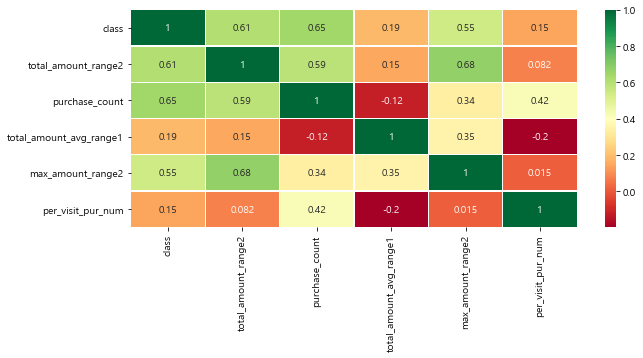

In [142]:
plt.figure(figsize=(10,4))
sns.heatmap(price_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

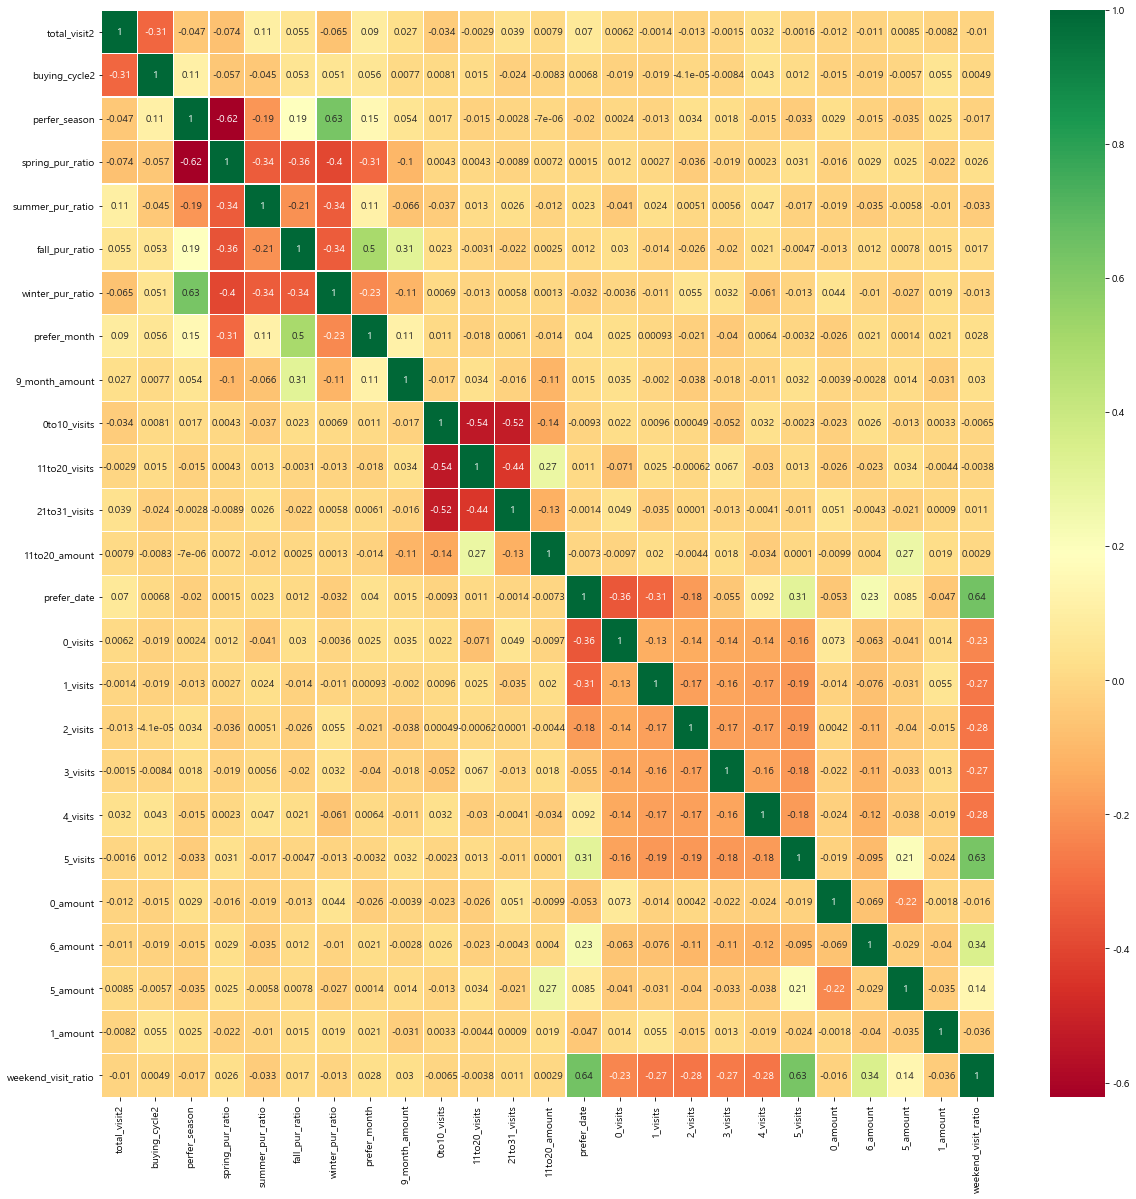

In [143]:
plt.figure(figsize=(20,20))
sns.heatmap(time_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

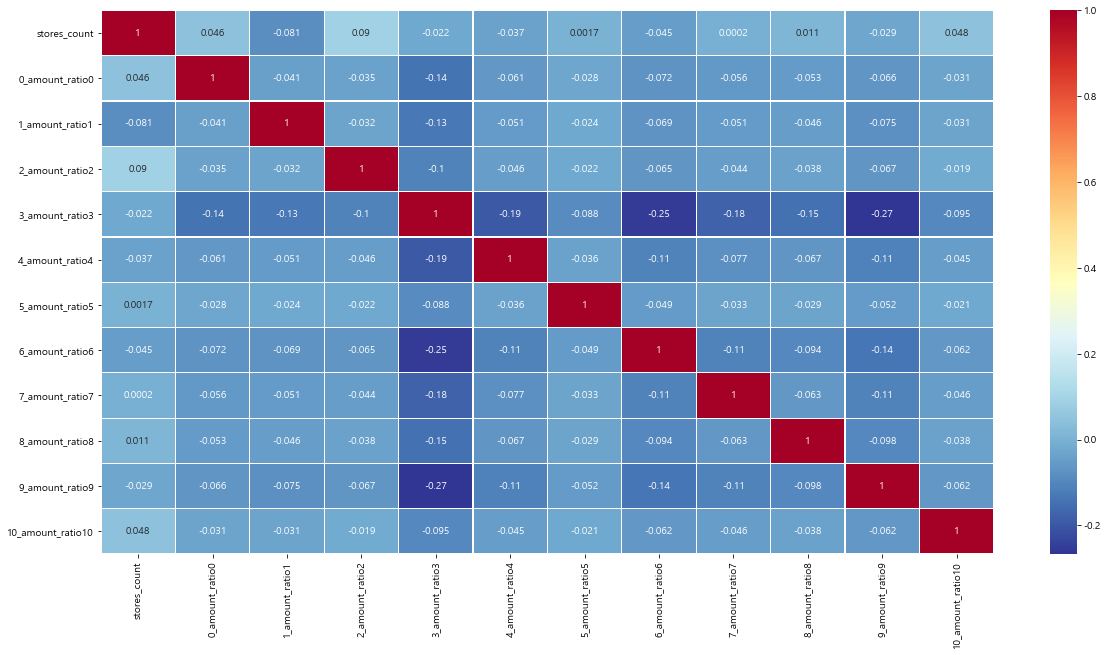

In [144]:
plt.figure(figsize=(20,10))
sns.heatmap(store_df.corr(), annot=True, cmap='RdYlBu_r', linewidths=0.2)
plt.show()

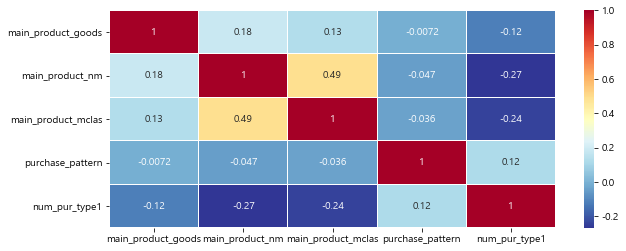

In [145]:
plt.figure(figsize=(10,4))
sns.heatmap(product_df.corr(), annot=True, cmap='RdYlBu_r', linewidths=0.2)
plt.show()

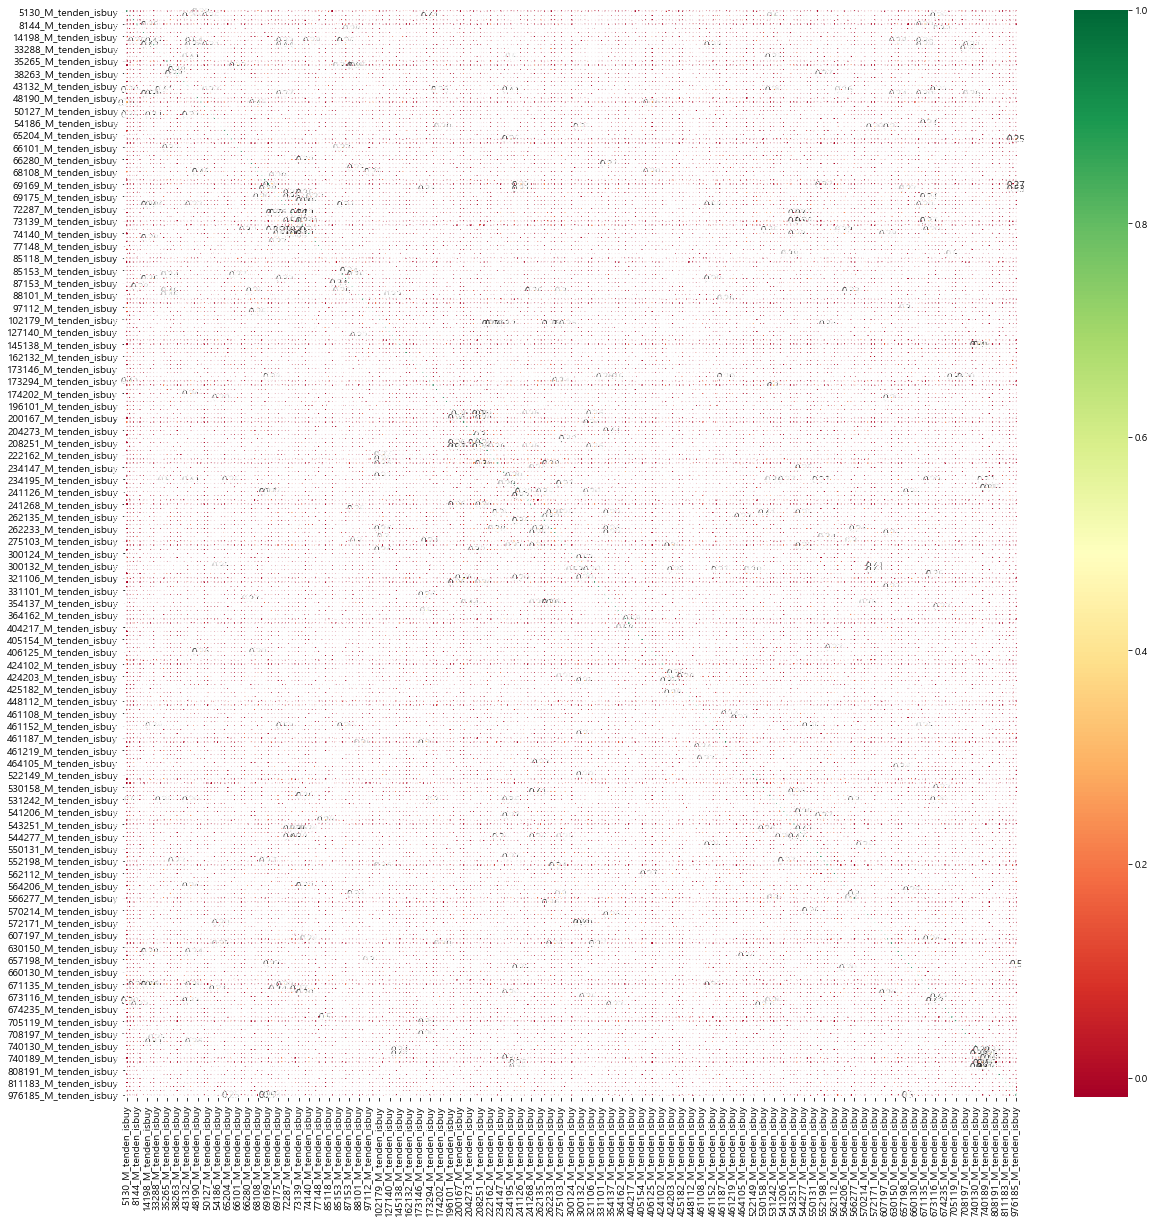

In [146]:
plt.figure(figsize=(20,20))
sns.heatmap(M_product.corr(), annot=True, cmap='RdYlGn', linewidths=0.02)
plt.show()

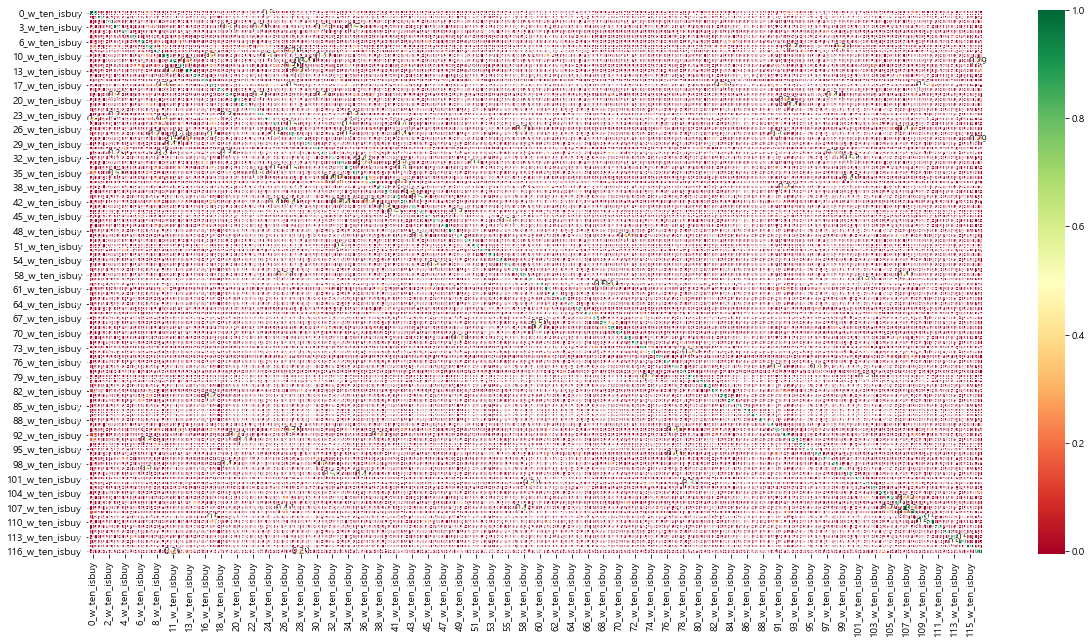

In [147]:
plt.figure(figsize=(20,10))
sns.heatmap(W_product.corr(), annot=True, cmap='RdYlGn', linewidths=0.02)
plt.show()

<font color = 'blue'> 모든 피쳐끼리 상관관계 
    - 마지막으로 모든 피쳐중 높은 상관관계를 갖는 것으로 보이는 칼럼제거
    - 칼럼 제거이후 1000개가 넘는 피쳐끼리 상관관계가 0.7이상으로 높은 피쳐는 없었음

In [148]:
highcorr = ['purchase_count','total_visit2', '13114_M_tenden_isbuy', '68144_M_tenden_isbuy', '196101_M_tenden_isbuy', '222109_M_tenden_isbuy', '241133_M_tenden_isbuy', '321106_M_tenden_isbuy', '331101_M_tenden_isbuy', '342110_M_tenden_isbuy', '404130_M_tenden_isbuy', '425103_M_tenden_isbuy', '425182_M_tenden_isbuy', '448112_M_tenden_isbuy', '461108_M_tenden_isbuy', '541118_M_tenden_isbuy', '541191_M_tenden_isbuy', '630134_M_tenden_isbuy', '630150_M_tenden_isbuy', '811127_M_tenden_isbuy', '62_w_ten_isbuy', '114_w_ten_isbuy']


df3 = df2.drop(columns=highcorr)


In [149]:
corrdf = (df3.corr() >= 0.7).sum().reset_index().rename(columns={'index':'cols',0:'corrCount'})

corrlst = corrdf.query('corrCount > 1')['cols'].unique().tolist()

In [150]:
len(corrlst)

0

In [151]:
cols = df3.columns.tolist()
X_test = X_test[cols]

In [152]:
df3.to_csv('X_train_after_corr.csv',index=False, encoding='cp949')
X_test.to_csv('X_test_after_corr.csv', index=False, encoding='cp949')

## ────────────────────────────────────────────────────────

###  피쳐 전처리

#### 피쳐 전처리
 - 이상치 제거
 - 로그변환
 - MinMaxScaling
 - PCA
 - Select Features

In [153]:
# 추가 라이브러리
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LogisticRegression
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler

In [154]:
train = pd.read_csv('X_train_after_corr.csv',encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
test = pd.read_csv('X_test_after_corr.csv', encoding='cp949')

train_test = pd.concat([train, test], ignore_index=True)


<font color = 'blue'> 이상치 제거

In [155]:
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

<font color = 'blue'> 로그변환

In [156]:
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

<font color = 'blue'> MinMaxScaling

In [157]:
X_train = train_test[:3500]
X_test = train_test[3500:]

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

train_test = pd.concat([X_train, X_test], ignore_index=True)

<font color = 'blue'> PCA

In [158]:
max_col = train_test.shape[1]
pca = PCA(n_components=max_col, random_state=0).fit(train_test)

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_col = np.argmax(cumsum >= 0.99) + 1

# num_col 이 1이었기 때문에 num_col은 max_col이 되었다

if num_col == 1:
    num_col = max_col

pca = PCA(n_components = num_col, random_state=0).fit_transform(train_test)
train_test = pd.DataFrame(pca)

In [159]:
X_train = train_test[:3500]
X_test = train_test[3500:]

<font color = 'blue'> Select Features
    - 여러 모델을 사용하여 가장 잘나온 p를 선택

In [160]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
extra = ExtraTreesClassifier(random_state=0, n_jobs=-1)
gbm = GradientBoostingClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0 ,n_jobs=-1)
xgb = XGBClassifier(random_state=0 ,n_jobs=-1)

models = [logreg, rf, extra, gbm, lgbm, xgb]

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:05<00:00,  1.15it/s]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

LogisticRegression (34, 0.7702754414551767)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:51<00:00,  3.09s/it]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

RandomForestClassifier (40, 0.7396412880137336)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [02:38<00:00,  2.11s/it]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

ExtraTreesClassifier (9, 0.7432790440089441)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [34:57<00:00, 27.96s/it]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

GradientBoostingClassifier (15, 0.746971410158106)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [05:30<00:00,  4.41s/it]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

LGBMClassifier (36, 0.739642227380523)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:14<00:00,  2.59s/it]
No handles with labels found to put in legend.


XGBClassifier (11, 0.7471875039330207)


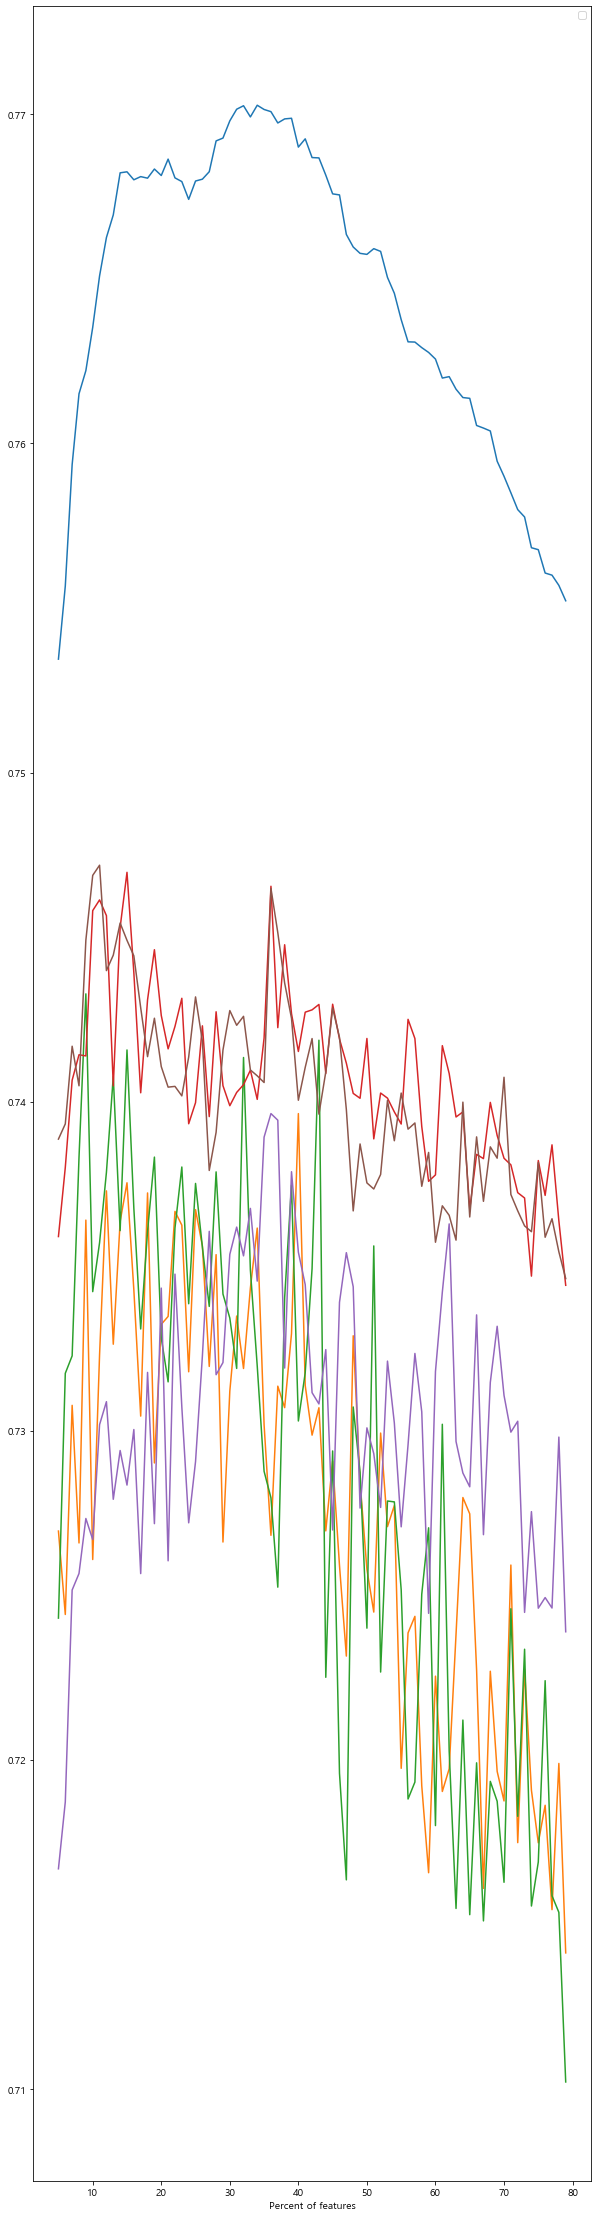

In [161]:
# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임
for model in models:
    
    cv_scores = []
    
    # 퍼센타일을 5~100프로 모두 살피기
    for percentile in tqdm(range(5,80)):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train,y_train)
       
        # cross_val_score 5번의 평균값
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
        
        cv_scores.append((percentile, cv_score))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

 17%|██████████████                                                                      | 1/6 [00:03<00:16,  3.37s/it]

[0.76304043 0.74162759 0.77943288 0.75691502 0.77004274] 0.7622117315698917


 33%|████████████████████████████                                                        | 2/6 [00:04<00:11,  2.84s/it]

[0.77390782 0.74216704 0.78971731 0.7677041  0.76969523] 0.7686383007627884


 50%|██████████████████████████████████████████                                          | 3/6 [00:05<00:06,  2.22s/it]

[0.77227206 0.73897382 0.79351959 0.77675301 0.76978211] 0.7702601172789832


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:06<00:03,  1.78s/it]

[0.77322045 0.73859968 0.79322376 0.77543048 0.77090284] 0.7702754414551767


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.51s/it]

[0.7746996  0.7407488  0.78574971 0.77437767 0.76780129] 0.7686754145989424


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.48s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.76612924 0.72986401 0.77851058 0.76363209 0.76376147] 0.7603794785846378
LogisticRegression (34, 0.7702754414551767)


 17%|██████████████                                                                      | 1/6 [00:02<00:11,  2.25s/it]

[0.73053832 0.70508392 0.77062759 0.72265098 0.75312761] 0.7364056850181473


 33%|████████████████████████████                                                        | 2/6 [00:04<00:09,  2.38s/it]

[0.72325569 0.70196901 0.77451253 0.72847187 0.73918804] 0.7334794276031962


 50%|██████████████████████████████████████████                                          | 3/6 [00:08<00:07,  2.60s/it]

[0.73954808 0.69266342 0.76757359 0.72158948 0.7381151 ] 0.7318979319564034


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:11<00:05,  2.78s/it]

[0.71710853 0.7023649  0.79499004 0.73064273 0.73571292] 0.7361638229281139


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:14<00:03,  3.03s/it]

[0.72017123 0.69608722 0.77446033 0.73856053 0.72424503] 0.7307048674591006


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  3.11s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.70733745 0.6919282  0.76300128 0.70538845 0.74584723] 0.722700521928029
RandomForestClassifier (9, 0.7364056850181473)


 17%|██████████████                                                                      | 1/6 [00:01<00:09,  1.86s/it]

[0.74481646 0.71572509 0.77624836 0.73116044 0.74844488] 0.7432790440089441


 33%|████████████████████████████                                                        | 2/6 [00:03<00:07,  1.89s/it]

[0.7208586  0.72489146 0.7667122  0.72316868 0.72182548] 0.7314912846699934


 50%|██████████████████████████████████████████                                          | 3/6 [00:05<00:05,  1.94s/it]

[0.73752077 0.72092821 0.78259999 0.73447982 0.73119961] 0.7413456812649918


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:08<00:04,  2.03s/it]

[0.72697097 0.70544066 0.77655289 0.72672299 0.72417118] 0.7319717367552924


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:10<00:02,  2.11s/it]

[0.7327788  0.71884435 0.76886132 0.75327805 0.73559129] 0.7418707619469


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.12s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.69653531 0.70978674 0.75847683 0.73006413 0.70190871] 0.7193543426810942
ExtraTreesClassifier (9, 0.7432790440089441)


 17%|██████████████                                                                      | 1/6 [00:06<00:34,  6.92s/it]

[0.75192942 0.71259277 0.76995763 0.73101252 0.74147727] 0.7413939223217725


 33%|████████████████████████████                                                        | 2/6 [00:21<00:37,  9.27s/it]

[0.75513134 0.71147036 0.7706711  0.73591981 0.73484848] 0.741608219213478


 50%|██████████████████████████████████████████                                          | 3/6 [00:43<00:39, 13.03s/it]

[0.75456578 0.70906892 0.76697323 0.73364018 0.73834967] 0.7405195560949


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:06<00:32, 16.04s/it]

[0.7527473  0.70893841 0.77045358 0.72992491 0.73830623] 0.7400740844900987


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:34<00:19, 19.75s/it]

[0.75131166 0.70908632 0.77026216 0.74004403 0.74408361] 0.7429575545940393


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:21<00:00, 23.60s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.74096632 0.70944306 0.76629456 0.73312683 0.75007819] 0.7399817916368997
GradientBoostingClassifier (43, 0.7429575545940393)


 17%|██████████████                                                                      | 1/6 [00:01<00:05,  1.03s/it]

[0.72620094 0.70516223 0.7586813  0.71850937 0.72815019] 0.727340804511112


 33%|████████████████████████████                                                        | 2/6 [00:02<00:04,  1.24s/it]

[0.73208273 0.70115113 0.76297083 0.70731134 0.72676015] 0.7260552340004164


 50%|██████████████████████████████████████████                                          | 3/6 [00:05<00:05,  1.68s/it]

[0.74221054 0.70174278 0.76177011 0.73297022 0.73790659] 0.7353200479594426


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:08<00:04,  2.07s/it]

[0.75333896 0.68963987 0.77224596 0.72046706 0.73707256] 0.73455288207192


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:12<00:02,  2.58s/it]

[0.75838547 0.67177698 0.75540107 0.73460598 0.73393627] 0.7308211518666405


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  3.14s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.73171729 0.69359877 0.76357989 0.72487841 0.74360578] 0.7314760268328142
LGBMClassifier (32, 0.7353200479594426)


 17%|██████████████                                                                      | 1/6 [00:00<00:04,  1.10it/s]

[0.74670889 0.71360207 0.77602214 0.74041816 0.7477933 ] 0.7449089136248789


 33%|████████████████████████████                                                        | 2/6 [00:02<00:04,  1.06s/it]

[0.74917124 0.71079169 0.76762579 0.73260478 0.74203329] 0.7404453598081417


 50%|██████████████████████████████████████████                                          | 3/6 [00:04<00:04,  1.34s/it]

[0.75830716 0.70548416 0.76838277 0.73993092 0.74087781] 0.7425965633954836


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:06<00:03,  1.55s/it]

[0.75345207 0.70266508 0.77153248 0.73752947 0.73876668] 0.7407891576063237


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:08<00:01,  1.86s/it]

[0.74914514 0.70603232 0.76392792 0.73919569 0.73982225] 0.7396246630607004


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]
No handles with labels found to put in legend.


[0.74368099 0.70303921 0.76329276 0.73721624 0.74592542] 0.7386309262107772
XGBClassifier (9, 0.7449089136248789)


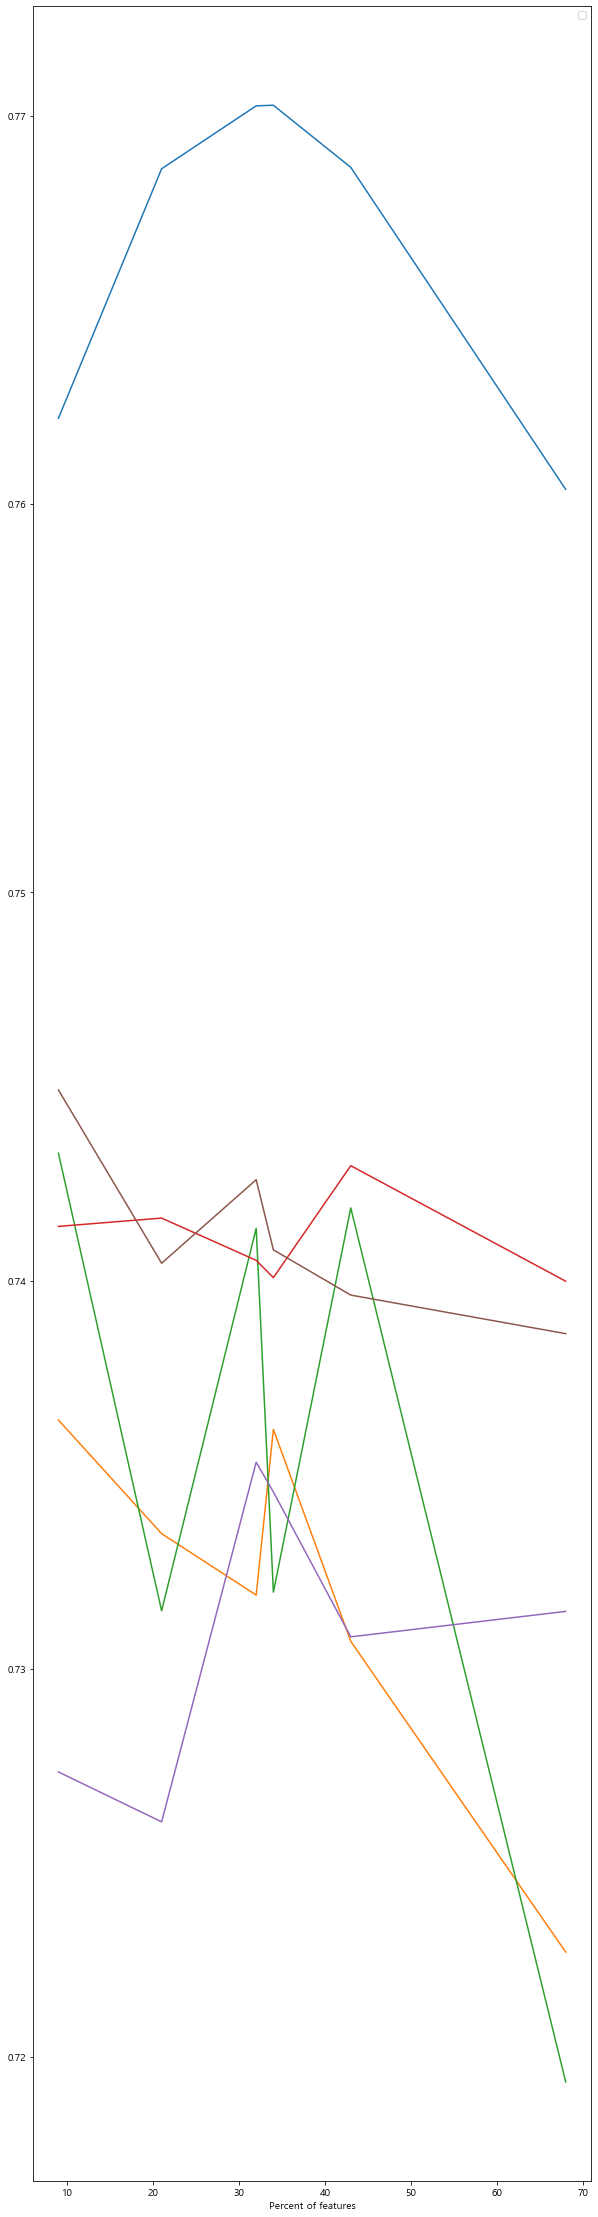

In [162]:
# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임

new_range = [9, 21, 32, 34, 43, 68]

for model in models:
    
    cv_scores_mean = []
    
    
    # 퍼센타일을 5~100프로 모두 살피기
    for percentile in tqdm(new_range):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train,y_train)
       
        # cross_val_score 5번의 평균값
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5)
        
        cv_scores_mean.append((percentile, cv_score.mean()))
        
        print(cv_score, cv_score.mean())
        
        # 베스트 percentile과 점수 출력
    best_score = cv_scores_mean[np.argmax([score for _, score in cv_scores_mean])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores_mean], [score for _, score in cv_scores_mean])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

In [163]:
select_p = SelectPercentile(percentile = 32).fit(X_train, y_train)
X_train = select_p.transform(X_train)
X_test = select_p.transform(X_test)

In [164]:
pd.DataFrame(X_train).to_csv('X_train_after_preprocessing.csv', index=False, encoding='cp949')
pd.DataFrame(X_test).to_csv('X_test_after_preprocessing.csv', index=False,  encoding='cp949')

<br><font color='green'>
## ch.3 modeling

In [165]:


X_train = pd.read_csv('X_train_after_preprocessing.csv',encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_preprocessing.csv', encoding='cp949')

y_train.drop(columns='cust_id', inplace=True)

### Basic models predictions with Stratied KFold



In [166]:
X_train

0         1         2         3         4         5         6  \
0     1.065708 -1.108290  0.513177  0.458800 -0.747350 -0.428893 -0.539247   
1    -1.118512 -0.283965 -0.807377 -0.227990  0.499381  0.517660  0.216804   
2    -1.621164  0.359342 -0.009075  0.264630  0.613557  0.340367  0.289711   
3     0.109638 -0.011408 -0.158151 -0.152665  0.118723  0.108297  0.011834   
4    -0.947410 -0.471158  0.001532 -0.062487  0.147821  0.392181  0.105615   
...        ...       ...       ...       ...       ...       ...       ...   
3495 -1.464698  0.756092 -0.190608  0.345714 -0.504831 -0.024720 -0.562073   
3496 -0.637022 -1.259685 -0.407535 -0.201414 -0.656503 -0.238687 -0.388249   
3497 -1.917122  0.586596  0.176672 -0.022940  0.887222  0.212659  0.248100   
3498 -1.613797  0.677287  0.720803 -0.153151  0.455676 -0.145414  0.168945   
3499  1.958360 -0.180292  0.674883  0.694555 -0.852054 -0.690859  1.048080   

             7         8         9        10        11        12        13  \
0    -0.731433  0.076911  0.021530  0.380154 -0.263381  0.657783  0.343924   
1    -0.090451  0.025904 -0.353093  0.416460  0.480265  0.037461 -0.570086   
2    -0.087876  0.157243  0.587353  0.580692  0.871480  0.162102 -0.315106   
3     0.964645  0.056170 -0.055947  0.597547 -0.147843  0.235257 -0.150636   
4     0.027790 -0.491372 -0.168841 -0.259138 -0.220020  0.090226 -0.034241   
...        ...       ...       ...       ...       ...       ...       ...   
3495  0.120787  0.344116 -0.068355  0.447804 -0.129889 -0.027220 -0.310888   
3496  0.293272  0.295465  0.261209 -0.498390  0.036562 -0.097433  0.038680   
3497 -0.033524  0.439044  0.662337  0.186030  0.497668 -0.128635  0.318197   
3498 -0.336686 -0.307792  1.001812 -0.480202 -0.221852 -0.080391  0.245013   
3499 -0.055430  0.400252  1.064487  0.904218 -1.113878 -0.024172  0.028277   

            14        15        16        17        18        19        20  \
0    -0.677908  0.134552 -0.607887 -0.334236  0.466818 -0.817238  0.558181   
1     0.212827  0.011924  0.040916 -0.268571 -0.034933  0.243135 -0.195723   
2    -0.068214 -0.652528 -0.038627  0.186056 -0.026710 -0.328323  0.371399   
3     0.213735 -0.034673  0.823885  0.240318  0.884381  0.176382 -0.551570   
4    -0.098235 -0.214728  0.092175 -0.072373  0.120374  0.242469 -0.157868   
...        ...       ...       ...       ...       ...       ...       ...   
3495 -0.073142 -0.218104 -0.186719 -0.221529 -0.206925  0.204931 -0.031708   
3496 -0.586363 -0.139540  0.219526 -0.165092  0.121742  0.418840  0.075656   
3497 -0.089296 -0.026757  0.106860 -0.033486  0.024258 -0.069452  0.176857   
3498  0.237754  0.004130  0.074067 -0.150251  0.260882 -0.153897  0.261670   
3499 -0.063458 -0.095410  0.170574 -0.497563 -0.584600  0.224927  0.096305   

            21        22        23        24  ...        36        37  \
0     0.384880 -0.501892 -0.391397  0.231977  ...  0.061941 -0.115564   
1     0.069680  0.123329  0.333959  0.324653  ...  0.017571  0.090054   
2    -0.085577  0.343442 -0.189036 -0.328772  ...  0.106546  0.050239   
3     0.296521 -0.502003 -0.279106 -0.226484  ...  0.323809  0.024949   
4     0.016628  0.012838  0.141537 -0.007924  ...  0.060836  0.160578   
...        ...       ...       ...       ...  ...       ...       ...   
3495  0.034346 -0.153010  0.165919 -0.275033  ... -0.010581  0.005894   
3496 -0.350422  0.372626 -0.125887  0.089546  ... -0.018598 -0.020421   
3497  0.094409 -0.082355 -0.122724 -0.153241  ... -0.004116 -0.009658   
3498 -0.411538 -0.324810 -0.121051 -0.252062  ... -0.113954 -0.083104   
3499  0.629398  0.140038  0.276127 -0.091016  ...  0.581725  0.038005   

            38        39        40        41        42        43        44  \
0    -0.234307 -0.376520 -0.105457 -0.036715  0.191605 -0.087796  0.890069   
1     0.043179  0.059346 -0.109441  0.016787  0.290277 -0.061630 -0.010334   
2     0.024050 -0.087877  0.104295  0.094274  0.064416  0.084969 -0.135912   
3    -0.40711

In [167]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
extra = ExtraTreesClassifier(random_state=0, n_jobs=-1)
gbm = GradientBoostingClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0, n_jobs=-1)
xgb = XGBClassifier(random_state=0, n_jobs=-1)

models = [logreg, rf, extra, gbm, lgbm, xgb]

In [168]:
# 모델별로 총 12개의 모델을 평균내어 예측한다

for model in models:
    
    lucky_seed = [2533,5066,9538]
    
    cv_scores = []
    
    for rs in lucky_seed:
        
        skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=rs)
        
        scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv = skf)
        
        cv_scores.append(scores)
        
    print(f'{model.__class__.__name__}, \ncv성능들: {cv_scores}\n최고성능: {max([score for scoreArr in cv_scores for score in scoreArr])}\n평균성능: {np.mean(cv_scores)}\n')

LogisticRegression, 
cv성능들: [array([0.77148535, 0.74915105, 0.7869056 , 0.76957035]), array([0.77148535, 0.74915105, 0.7869056 , 0.76957035]), array([0.77148535, 0.74915105, 0.7869056 , 0.76957035])]
최고성능: 0.7869055969359919
평균성능: 0.7692780876671453

RandomForestClassifier, 
cv성능들: [array([0.70972366, 0.72505483, 0.74493693, 0.73477181]), array([0.70972366, 0.72505483, 0.74493693, 0.73477181]), array([0.70972366, 0.72505483, 0.74493693, 0.73477181])]
최고성능: 0.744936927307748
평균성능: 0.728621808788982

ExtraTreesClassifier, 
cv성능들: [array([0.73646693, 0.72526916, 0.7512609 , 0.73152076]), array([0.73646693, 0.72526916, 0.7512609 , 0.73152076]), array([0.73646693, 0.72526916, 0.7512609 , 0.73152076])]
최고성능: 0.7512608971575536
평균성능: 0.7361294354075509

GradientBoostingClassifier, 
cv성능들: [array([0.74829932, 0.72858702, 0.74797087, 0.74537671]), array([0.74829932, 0.72858702, 0.74797087, 0.74537671]), array([0.74829932, 0.72858702, 0.74797087, 0.74537671])]
최고성능: 0.7482993197278911
평균성능: 0.74

### Tuning with BaysianOptimization + Stratified KFold

In [169]:
BO_tuned_clfs = []

LogReg

In [170]:
# 하이퍼 파라미터 범위

pbounds = { 'C': (0.1,1),}


def logreg_opt(C):
    
    params = {
        'C' : C
    }

    logreg = LogisticRegression(**params, n_jobs=-1, random_state=50)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)
    
    score = cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)


BO_logreg = BayesianOptimization(f = logreg_opt, pbounds = pbounds, random_state=0)


In [171]:
BO_logreg.maximize(init_points=50, n_iter=50)

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.7696   |  0.5939   |
|  2        |  0.7694   |  0.7437   |
|  3        |  0.7695   |  0.6425   |
|  4        |  0.7696   |  0.5904   |
|  5        |  0.7698   |  0.4813   |
|  6        |  0.7695   |  0.6813   |
|  7        |  0.7698   |  0.4938   |
|  8        |  0.7693   |  0.9026   |
|  9        |  0.7693   |  0.9673   |
|  10       |  0.7698   |  0.4451   |
|  11       |  0.7694   |  0.8126   |
|  12       |  0.7696   |  0.576    |
|  13       |  0.7696   |  0.6112   |
|  14       |  0.7693   |  0.933    |
|  15       |  0.7704   |  0.1639   |
|  16       |  0.7704   |  0.1784   |
|  17       |  0.7705   |  0.1182   |
|  18       |  0.7694   |  0.8494   |
|  19       |  0.7694   |  0.8003   |
|  20       |  0.7694   |  0.883    |
|  21       |  0.7693   |  0.9808   |
|  22       |  0.7694   |  0.8192   |
|  23       |  0.7698   |  0.5153   |
|  24       |  0.7694   |  0.8025   |
|  25       

In [172]:
# BO_rf.res  # 모든 성능 들어가있음
BO_logreg.max

{'target': 0.7706767649776768, 'params': {'C': 0.10022294574582212}}

In [173]:
max_params = BO_logreg.max['params']

max_params

{'C': 0.10022294574582212}

In [174]:
skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

logreg_clf = LogisticRegression(**max_params,  n_jobs=-1, random_state=50)

scores = cross_val_score(logreg_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((logreg_clf.__class__.__name__, logreg_clf, max(scores)))

[0.77215895 0.75176748 0.78667179 0.77210884]
최대성능: 0.7866717881915452
평균성능: 0.7706767649776768


RF

In [175]:
# 하이퍼 파라미터 범위

pbounds = { 'n_estimators': (50,250),
            'max_depth': (5,15), 
            'max_features': (0.8,0.95),
            'min_samples_leaf': (1, 5)}

def rf_opt(n_estimators, max_depth, max_features, min_samples_leaf):
    
    params = {
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }

    rf = RandomForestClassifier(**params, n_jobs=-1, random_state=50)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)
    
    score = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)


BO_rf = BayesianOptimization(f = rf_opt, pbounds = pbounds, random_state=0)

In [176]:
BO_rf.maximize(init_points=50, n_iter=50)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.7406   |  10.49    |  0.9073   |  3.411    |  159.0    |
|  2        |  0.7455   |  9.237    |  0.8969   |  2.75     |  228.4    |
|  3        |  0.7456   |  14.64    |  0.8575   |  4.167    |  155.8    |
|  4        |  0.7306   |  10.68    |  0.9388   |  1.284    |  67.43    |
|  5        |  0.7377   |  5.202    |  0.9249   |  4.113    |  224.0    |
|  6        |  0.7495   |  14.79    |  0.9199   |  2.846    |  206.1    |
|  7        |  0.7416   |  6.183    |  0.896    |  1.573    |  238.9    |
|  8        |  0.7484   |  10.22    |  0.8622   |  2.058    |  204.8    |
|  9        |  0.7403   |  9.562    |  0.8853   |  1.075    |  173.5    |
|  10       |  0.7414   |  11.12    |  0.8925   |  4.775    |  186.4    |
|  11       |  0.7404   |  8.595    |  0.8656   |  3.791    |  62.05    |
|  12       |  0.73     |  11.67    | 

|  67       |  0.7428   |  14.26    |  0.8157   |  4.736    |  202.5    |
|  68       |  0.7378   |  5.045    |  0.9497   |  1.042    |  198.7    |
|  69       |  0.7397   |  14.85    |  0.9426   |  1.22     |  181.4    |
|  70       |  0.7486   |  11.75    |  0.9425   |  3.936    |  234.8    |
|  71       |  0.7454   |  12.31    |  0.8055   |  2.604    |  239.2    |
|  72       |  0.7422   |  12.27    |  0.945    |  4.768    |  233.5    |
|  73       |  0.7389   |  14.72    |  0.9479   |  4.943    |  86.7     |
|  74       |  0.7477   |  14.91    |  0.9369   |  3.69     |  244.0    |
|  75       |  0.7479   |  14.86    |  0.9372   |  3.701    |  219.2    |
|  76       |  0.7501   |  14.99    |  0.9499   |  3.326    |  243.2    |
|  77       |  0.75     |  14.92    |  0.9483   |  2.803    |  241.9    |
|  78       |  0.75     |  15.0     |  0.8323   |  2.691    |  242.4    |
|  79       |  0.7446   |  14.97    |  0.9485   |  2.427    |  241.8    |
|  80       |  0.7498   |  14.92    | 

In [177]:
# BO_rf.res  # 모든 성능 들어가있음
BO_rf.max

{'target': 0.7501099457786388,
 'params': {'max_depth': 14.992532736227037,
  'max_features': 0.949863335833804,
  'min_samples_leaf': 3.325685272417124,
  'n_estimators': 243.16523325240033}}

In [178]:
max_params = BO_rf.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))

max_params

{'max_depth': 15,
 'max_features': 0.949863335833804,
 'min_samples_leaf': 3,
 'n_estimators': 243}

In [179]:
rf_clf = RandomForestClassifier(**max_params,  n_jobs=-1, random_state=50)

scores = cross_val_score(rf_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((rf_clf.__class__.__name__, rf_clf, max(scores)))

[0.72334859 0.72644934 0.75123306 0.7531091 ]
최대성능: 0.7531090996136589
평균성능: 0.7385350212097932


XGB

In [180]:
# 하이퍼 파라미터 범위

pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 100),
            'max_depth': (5,15),   
            'subsample': (0.8,0.95),  
            'colsample': (0.75,0.95),   
            'gamma': (0, 5)}

def xgb_opt(learning_rate, n_estimators, max_depth, subsample, colsample, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample': colsample,   
        'gamma': gamma,
        'n_jobs' : -1
    }
    
    xgb = XGBClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_xgb = BayesianOptimization(f = xgb_opt, pbounds = pbounds, random_state=0)

In [181]:
BO_xgb.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.67     |  0.8598   |  3.576    |  0.924    |  10.45    |  71.18    |  0.8969   |
|  2        |  0.6372   |  0.8375   |  4.459    |  1.447    |  8.834    |  89.59    |  0.8793   |
|  3        |  0.7276   |  0.8636   |  4.628    |  0.153    |  5.871    |  51.01    |  0.9249   |
|  4        |  0.6471   |  0.9056   |  4.35     |  1.469    |  12.99    |  73.07    |  0.9171   |
|  5        |  0.7206   |  0.7737   |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  6        |  0.683    |  0.8029   |  3.871    |  0.7114   |  10.68    |  50.94    |  0.8926   |
|  7        |  0.6461   |  0.8724   |  3.085    |  1.418    |  11.82    |  67.98    |  0.8656   |
|  8        |  0.6744   |  0.8895   |  0.3011   |  1.017    |  11.71    |  60.52    |  0.8193   |
|  9        |  0.680

|  51       |  0.7359   |  0.7708   |  0.01055  |  0.08043  |  14.87    |  50.17    |  0.9145   |
|  52       |  0.7169   |  0.9244   |  4.888    |  0.3122   |  14.78    |  99.84    |  0.9206   |
|  53       |  0.7402   |  0.95     |  2.387    |  0.05     |  14.6     |  54.16    |  0.8      |
|  54       |  0.7334   |  0.95     |  4.93e-08 |  0.05     |  15.0     |  69.69    |  0.95     |
|  55       |  0.7418   |  0.9323   |  4.974    |  0.1094   |  5.548    |  99.75    |  0.8069   |
|  56       |  0.7379   |  0.95     |  5.0      |  0.05     |  15.0     |  50.0     |  0.95     |
|  57       |  0.7396   |  0.8833   |  4.897    |  0.07372  |  14.42    |  92.87    |  0.9334   |
|  58       |  0.742    |  0.9003   |  0.7486   |  0.0714   |  14.9     |  91.86    |  0.8765   |
|  59       |  0.7457   |  0.95     |  5.0      |  0.05     |  6.018    |  56.03    |  0.8      |
|  60       |  0.737    |  0.75     |  0.0      |  0.05     |  5.0      |  52.62    |  0.8      |
|  61       |  0.735

In [182]:
# BO_rf.res  # 모든 성능 들어가있음
BO_xgb.max

{'target': 0.7456828885400314,
 'params': {'colsample': 0.9499999939177807,
  'gamma': 4.999999952935797,
  'learning_rate': 0.05000000000971461,
  'max_depth': 6.0177094335944155,
  'n_estimators': 56.030371340593945,
  'subsample': 0.8}}

In [183]:
max_params = BO_xgb.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))

max_params

{'colsample': 0.9499999939177807,
 'gamma': 4.999999952935797,
 'learning_rate': 0.05000000000971461,
 'max_depth': 6,
 'n_estimators': 56,
 'subsample': 0.8}

In [184]:
xgb_clf = XGBClassifier(**max_params)

scores = cross_val_score(xgb_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((xgb_clf.__class__.__name__, xgb_clf, max(scores)))

[0.74061147 0.7345046  0.75517441 0.75244107]
최대성능: 0.7551744101896077
평균성능: 0.7456828885400314


LGBM

In [185]:
pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def lgbm_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgbm = LGBMClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1)    


In [186]:
BO_lgbm.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7041   |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        |  0.7013   |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        |  0.6888   |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        |  0.7133   |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        |  0.6671   |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        |  0.6931   |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        |  0.6816   |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

|  45       |  0.7314   |  0.8389   |  0.5028   |  9.414    |  6.458    |  101.4    |  2.887    |  0.8289   |
|  46       |  0.686    |  0.8249   |  1.106    |  4.457    |  2.488    |  220.3    |  5.327    |  0.8925   |
|  47       |  0.7408   |  0.785    |  0.1979   |  6.611    |  3.863    |  80.53    |  6.974    |  0.8816   |
|  48       |  0.7278   |  0.8481   |  0.2596   |  8.261    |  2.332    |  153.9    |  8.282    |  0.8033   |
|  49       |  0.6703   |  0.7987   |  1.316    |  8.913    |  4.231    |  223.3    |  9.598    |  0.924    |
|  50       |  0.7309   |  0.8781   |  0.1932   |  7.559    |  5.221    |  172.0    |  8.397    |  0.8052   |
|  51       |  0.7267   |  0.9      |  0.05     |  3.0      |  7.0      |  50.0     |  10.0     |  0.8      |
|  52       |  0.7028   |  0.9      |  0.05     |  3.177    |  7.0      |  50.42    |  2.0      |  0.95     |
|  53       |  0.7354   |  0.9      |  0.05     |  10.0     |  1.0      |  50.0     |  10.0     |  0.95     |
|  54     

|  90       |  0.7413   |  0.9      |  0.05     |  3.0      |  7.0      |  143.8    |  10.0     |  0.95     |
|  91       |  0.7319   |  0.7756   |  0.05     |  3.05     |  6.151    |  59.72    |  7.601    |  0.8      |
|  92       |  0.7307   |  0.7811   |  0.08774  |  9.873    |  2.655    |  106.8    |  2.295    |  0.8954   |
|  93       |  0.7374   |  0.8571   |  0.1714   |  3.186    |  6.86     |  82.74    |  2.315    |  0.8501   |
|  94       |  0.7392   |  0.8564   |  0.07419  |  8.741    |  1.274    |  213.1    |  2.01     |  0.9095   |
|  95       |  0.7399   |  0.75     |  0.1173   |  9.699    |  1.0      |  61.45    |  7.513    |  0.9187   |
|  96       |  0.7427   |  0.8693   |  0.07481  |  9.72     |  6.892    |  148.6    |  9.916    |  0.8672   |
|  97       |  0.7463   |  0.7577   |  0.1198   |  3.028    |  1.355    |  218.2    |  9.8      |  0.8164   |
|  98       |  0.7362   |  0.7772   |  0.1652   |  9.991    |  6.787    |  105.7    |  6.633    |  0.8654   |
|  99     

In [187]:
# BO_rf.res  # 모든 성능 들어가있음
BO_lgbm.max

{'target': 0.7478177850518275,
 'params': {'colsample_bytree': 0.8344335249326639,
  'learning_rate': 0.18217093182815758,
  'max_depth': 3.4962206521755244,
  'min_child_weight': 6.660704173116503,
  'n_estimators': 211.87690968059286,
  'num_leaves': 2.202093663883728,
  'subsample': 0.9392680098521642}}

In [188]:
max_params = BO_lgbm.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))

max_params

{'colsample_bytree': 0.8344335249326639,
 'learning_rate': 0.18217093182815758,
 'max_depth': 3,
 'min_child_weight': 6.660704173116503,
 'n_estimators': 212,
 'num_leaves': 2,
 'subsample': 0.9392680098521642}

In [189]:
lgbm_clf = LGBMClassifier(**max_params)

scores = cross_val_score(lgbm_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((lgbm_clf.__class__.__name__, lgbm_clf, max(scores)))

[0.74927352 0.74104568 0.76088046 0.74007148]
최대성능: 0.7608804569290891
평균성능: 0.7478177850518275


ExtraTreeClassifier

In [190]:
pbounds = { 'n_estimators': (50, 250),
            'max_depth': (3,10),    
            'max_features': (0.8,0.95),
            'min_samples_split': (2, 5),
            'min_samples_leaf': (1, 5)
            }

def extra_opt(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):

    params = {
        'n_estimators': int(round(n_estimators)),
        'max_depth': int(round(max_depth)),
        'max_features' : max_features,
        'min_samples_leaf': int(round(min_samples_leaf)),
        'min_samples_split': int(round(min_samples_split)),
        'n_jobs' : -1
    }
    
    extra = ExtraTreesClassifier(bootstrap = True, oob_score=True, **params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(extra, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_extra = BayesianOptimization(f = extra_opt, pbounds = pbounds, random_state=0)    



In [191]:
BO_extra.maximize(init_points=50, n_iter=50)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.742    |  6.842    |  0.9073   |  3.411    |  3.635    |  134.7    |
|  2        |  0.7434   |  7.521    |  0.8656   |  4.567    |  4.891    |  126.7    |
|  3        |  0.7414   |  8.542    |  0.8793   |  3.272    |  4.777    |  64.21    |
|  4        |  0.7325   |  3.61     |  0.803    |  4.33     |  4.334    |  224.0    |
|  5        |  0.7439   |  9.85     |  0.9199   |  2.846    |  4.342    |  73.65    |
|  6        |  0.7402   |  7.479    |  0.8215   |  4.779    |  3.566    |  132.9    |
|  7        |  0.7307   |  4.852    |  0.9161   |  2.825    |  3.705    |  53.76    |
|  8        |  0.7409   |  7.323    |  0.8918   |  3.468    |  4.831    |  186.4    |
|  9        |  0.7427   |  5.517    |  0.8656   |  3.791    |  2.181    |  183.4    |
|  10       |  0.742    |  7.694    |  0.8316   |  1.5

|  58       |  0.7434   |  9.963    |  0.9433   |  1.393    |  2.12     |  91.78    |
|  59       |  0.7469   |  9.878    |  0.8905   |  1.064    |  2.021    |  202.8    |
|  60       |  0.7476   |  9.754    |  0.8693   |  4.64     |  2.105    |  248.0    |
|  61       |  0.7433   |  9.978    |  0.8055   |  1.238    |  2.036    |  222.3    |
|  62       |  0.7446   |  9.982    |  0.8301   |  1.171    |  2.006    |  176.3    |
|  63       |  0.7432   |  9.833    |  0.9445   |  4.977    |  4.953    |  80.8     |
|  64       |  0.7439   |  9.982    |  0.8097   |  4.446    |  2.101    |  123.2    |
|  65       |  0.7489   |  9.941    |  0.8082   |  4.98     |  4.798    |  235.8    |
|  66       |  0.7417   |  9.984    |  0.8541   |  1.035    |  4.819    |  84.18    |
|  67       |  0.7453   |  9.938    |  0.8099   |  1.963    |  2.068    |  242.5    |
|  68       |  0.7389   |  9.904    |  0.8472   |  4.779    |  2.149    |  50.63    |
|  69       |  0.7488   |  9.934    |  0.8043   |  4.8

In [192]:
# BO_rf.res  # 모든 성능 들어가있음
BO_extra.max

{'target': 0.7495866595410667,
 'params': {'max_depth': 9.931621669768678,
  'max_features': 0.8282991142553193,
  'min_samples_leaf': 4.756289218773851,
  'min_samples_split': 4.7300468873849315,
  'n_estimators': 209.55958957852076}}

In [193]:
max_params = BO_extra.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))
max_params['min_samples_split'] = int(round(max_params['min_samples_split']))

max_params

{'max_depth': 10,
 'max_features': 0.8282991142553193,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 210}

In [194]:
extra_clf = ExtraTreesClassifier(bootstrap = True, oob_score=True, **max_params)

scores = cross_val_score(extra_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((extra_clf.__class__.__name__, extra_clf, max(scores)))

[0.73459367 0.73960386 0.762133   0.75205139]
최대성능: 0.7621330037743411
평균성능: 0.7470954830377323


GBM

In [195]:
pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'min_samples_split': (2,5),   
            'min_samples_leaf': (1,5)}


def gbm_opt(learning_rate, n_estimators, max_depth, subsample, min_samples_split, min_samples_leaf):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }
    
    gbm = GradientBoostingClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(gbm, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_gbm = BayesianOptimization(f = gbm_opt, pbounds = pbounds, random_state=0)    


In [196]:
BO_gbm.maximize(init_points=50, n_iter=50)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.6986   |  0.8458   |  8.006    |  3.411    |  3.635    |  134.7    |  0.8969   |
|  2        |  0.6986   |  0.6845   |  9.242    |  4.855    |  3.15     |  208.3    |  0.8793   |
|  3        |  0.6944   |  0.8737   |  9.479    |  1.284    |  2.261    |  54.04    |  0.9249   |
|  4        |  0.6707   |  1.178    |  9.09     |  4.914    |  4.397    |  142.3    |  0.9171   |
|  5        |  0.7284   |  0.2215   |  7.479    |  1.573    |  4.834    |  154.4    |  0.8622   |
|  6        |  0.7155   |  0.4336   |  8.42     |  2.825    |  3.705    |  53.76    |  0.8926   |
|  7        |  0.6847   |  0.9375   |  7.319    |  4.775    |  4.045    |  121.9    |  0.8656   |
|  8        |  0.6605   |  1.062    |  3.422    |  3.667    |  4.012    |  92.08    |  0.8193   |
|  9        |  0.715

|  51       |  0.6741   |  1.5      |  10.0     |  1.0      |  2.0      |  250.0    |  0.95     |
|  52       |  0.7382   |  0.05     |  10.0     |  1.0      |  5.0      |  228.2    |  0.95     |
|  53       |  0.7255   |  0.05     |  9.9      |  1.0      |  5.0      |  86.47    |  0.95     |
|  54       |  0.7353   |  0.1543   |  9.658    |  1.199    |  2.276    |  200.3    |  0.8338   |
|  55       |  0.7387   |  0.05     |  3.0      |  4.988    |  4.958    |  74.72    |  0.95     |
|  56       |  0.7363   |  0.05     |  3.0      |  1.0      |  5.0      |  50.0     |  0.863    |
|  57       |  0.7387   |  0.05     |  3.0      |  1.0      |  2.0      |  76.38    |  0.95     |
|  58       |  0.7462   |  0.05     |  3.0      |  1.0      |  5.0      |  219.6    |  0.95     |
|  59       |  0.7428   |  0.1504   |  3.08     |  4.918    |  2.071    |  125.9    |  0.9456   |
|  60       |  0.7467   |  0.05     |  3.202    |  1.0      |  2.0      |  227.6    |  0.95     |
|  61       |  0.733

In [197]:
# BO_rf.res  # 모든 성능 들어가있음
BO_gbm.max

{'target': 0.751121725285859,
 'params': {'learning_rate': 0.05,
  'max_depth': 3.0,
  'min_samples_leaf': 4.484580665767558,
  'min_samples_split': 2.0144518095419843,
  'n_estimators': 229.70423925848417,
  'subsample': 0.8}}

In [198]:
max_params = BO_gbm.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))
max_params['min_samples_split'] = int(round(max_params['min_samples_split']))

max_params

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 230,
 'subsample': 0.8}

In [199]:
gbm_clf = GradientBoostingClassifier(**max_params)

scores = cross_val_score(gbm_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((gbm_clf.__class__.__name__, gbm_clf, max(scores)))

[0.75607068 0.7344545  0.75593707 0.74965207]
최대성능: 0.7560706770433214
평균성능: 0.7490285803355712


### BaysianOptimization -> Ensemble: Voting(soft), Stacking

In [200]:
BO_tuned_clfs

[('LogisticRegression',
  LogisticRegression(C=0.10022294574582212, class_weight=None, dual=False,
                     fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=50, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False),
  0.7866717881915452),
 ('RandomForestClassifier',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=15,
                         max_features=0.949863335833804, max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=3,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=243, n_jobs=-1, oob_score=False,
                         random_state=50, verbose=0, warm_start=False),
  0.753

<font color = 'blue'> Stacking - LGBM

    - 스태킹과정:
        1. 랜덤서치 혹은 베이지안 최적화 이후 최적모델 6개로 stacktransform
        2. 메타모델 LGBM을 베이지안 최적화로 튜닝 
        3. 메타모델을 cross_val_score로 점수측정

In [201]:
estimators = BO_tuned_clfs.copy()

In [202]:
stack_estimators = [estimators[i][1] for i in range(len(estimators))]

In [203]:
# Logreg, RF, extraTree, GBM, Lgbm, XGB

len(stack_estimators)

6

    - S_train, S_test transform

In [204]:
S_train, S_test = stacking(stack_estimators,
                           X_train, y_train, X_test,
                           regression=False, needs_proba=True, metric=None, n_folds=4, stratified=True, shuffle=True,
                           random_state=0, verbose=0)

    - Meta_model최적화: BaysianOptimization + Stratified KFold
 

In [205]:
pbounds = { 'learning_rate': (0.01, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def meta_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    meta_model = LGBMClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=1)

    score = cross_val_score(meta_model, S_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_meta = BayesianOptimization(f = meta_opt, pbounds = pbounds, random_state=1)

In [206]:
BO_meta.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7232   |  0.8126   |  1.083    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        |  0.718    |  0.8018   |  0.6012   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        |  0.7161   |  0.7541   |  1.009    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        |  0.7362   |  0.8952   |  0.477    |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        |  0.6797   |  0.7755   |  1.318    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        |  0.6757   |  0.7973   |  1.033    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        |  0.69     |  0.7921   |  1.186    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

|  46       |  0.6839   |  0.8249   |  1.096    |  4.457    |  2.488    |  220.3    |  5.327    |  0.8925   |
|  47       |  0.7534   |  0.785    |  0.1619   |  6.611    |  3.863    |  80.53    |  6.974    |  0.8816   |
|  48       |  0.731    |  0.8481   |  0.2254   |  8.261    |  2.332    |  153.9    |  8.282    |  0.8033   |
|  49       |  0.666    |  0.7987   |  1.311    |  8.913    |  4.231    |  223.3    |  9.598    |  0.924    |
|  50       |  0.742    |  0.8781   |  0.1571   |  7.559    |  5.221    |  172.0    |  8.397    |  0.8052   |
|  51       |  0.7668   |  0.75     |  0.01     |  3.0      |  7.0      |  50.0     |  10.0     |  0.95     |
|  52       |  0.7402   |  0.9      |  0.01     |  3.265    |  7.0      |  50.0     |  2.0      |  0.8      |
|  53       |  0.7657   |  0.8156   |  0.04935  |  9.674    |  6.818    |  143.7    |  2.866    |  0.9131   |
|  54       |  0.7533   |  0.75     |  0.01     |  5.783    |  1.0      |  91.16    |  2.0      |  0.8      |
|  55     

|  91       |  0.7671   |  0.8881   |  0.05181  |  3.968    |  6.636    |  119.8    |  2.12     |  0.9039   |
|  92       |  0.7664   |  0.8543   |  0.04491  |  9.907    |  2.809    |  218.6    |  2.024    |  0.8005   |
|  93       |  0.7671   |  0.854    |  0.06577  |  3.197    |  6.955    |  85.98    |  2.038    |  0.8622   |
|  94       |  0.7663   |  0.8791   |  0.05736  |  3.078    |  4.489    |  173.5    |  2.05     |  0.9375   |
|  95       |  0.7621   |  0.75     |  0.01     |  5.593    |  1.0      |  169.0    |  2.0      |  0.8      |
|  96       |  0.7618   |  0.8735   |  0.1914   |  3.642    |  6.497    |  212.0    |  2.062    |  0.883    |
|  97       |  0.7677   |  0.774    |  0.04699  |  3.669    |  1.121    |  78.03    |  2.045    |  0.8628   |
|  98       |  0.766    |  0.8861   |  0.01442  |  3.026    |  3.223    |  59.65    |  9.775    |  0.9227   |
|  99       |  0.7567   |  0.8003   |  0.1409   |  3.041    |  6.498    |  102.4    |  9.444    |  0.9035   |
|  100    

In [207]:
# BO_rf.res  # 모든 성능 들어가있음
BO_meta.max

{'target': 0.7677395426255609,
 'params': {'colsample_bytree': 0.7739566884447873,
  'learning_rate': 0.046985360528141444,
  'max_depth': 3.6690289254022237,
  'min_child_weight': 1.120850451463525,
  'n_estimators': 78.02582570009977,
  'num_leaves': 2.044589983260023,
  'subsample': 0.8627659274056622}}

In [208]:
max_params = BO_meta.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))

max_params

{'colsample_bytree': 0.7739566884447873,
 'learning_rate': 0.046985360528141444,
 'max_depth': 4,
 'min_child_weight': 1.120850451463525,
 'n_estimators': 78,
 'num_leaves': 2,
 'subsample': 0.8627659274056622}

    - 메타 모델 최적화 이후 성능

In [209]:
meta_clf = LGBMClassifier(**max_params)

skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=1)

scores = cross_val_score(meta_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

[0.71927085 0.69670552 0.72439238 0.7086743 ]
최대성능: 0.724392375608181
평균성능: 0.7122607635525569


In [210]:
meta_clf.fit(S_train, y_train)

pred = meta_clf.predict_proba(S_test)[:,1]

# 0.782309
pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pred}).set_index('cust_id').to_csv('submission_BO_stack_lgbm2.csv', index=False, encoding='cp949')

<font color = 'blue'> Stacking - LogReg

    - 스태킹과정:
        1. 랜덤서치 혹은 베이지안 최적화 이후 최적모델 6개로 stacktransform
        2. 메타모델 LogReg을 베이지안 최적화로 튜닝 
        3. 메타모델을 cross_val_score로 점수측정

In [211]:
# 하이퍼 파라미터 범위

pbounds = { 'C': (0.1,1),}


def logreg_meta(C):
    
    params = {
        'C' : C
    }

    logreg = LogisticRegression(**params, n_jobs=-1, random_state=50)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)
    
    score = cross_val_score(logreg, S_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)


BO_logreg = BayesianOptimization(f = logreg_meta, pbounds = pbounds, random_state=0)

In [212]:
BO_logreg.maximize(init_points=50, n_iter=50)

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.7689   |  0.5939   |
|  2        |  0.7689   |  0.7437   |
|  3        |  0.7688   |  0.6425   |
|  4        |  0.7689   |  0.5904   |
|  5        |  0.7689   |  0.4813   |
|  6        |  0.7688   |  0.6813   |
|  7        |  0.7689   |  0.4938   |
|  8        |  0.7688   |  0.9026   |
|  9        |  0.7688   |  0.9673   |
|  10       |  0.769    |  0.4451   |
|  11       |  0.7688   |  0.8126   |
|  12       |  0.7689   |  0.576    |
|  13       |  0.7689   |  0.6112   |
|  14       |  0.7688   |  0.933    |
|  15       |  0.7684   |  0.1639   |
|  16       |  0.7685   |  0.1784   |
|  17       |  0.768    |  0.1182   |
|  18       |  0.7688   |  0.8494   |
|  19       |  0.7688   |  0.8003   |
|  20       |  0.7688   |  0.883    |
|  21       |  0.7688   |  0.9808   |
|  22       |  0.7688   |  0.8192   |
|  23       |  0.7689   |  0.5153   |
|  24       |  0.7688   |  0.8025   |
|  25       

In [213]:
# BO_rf.res  # 모든 성능 들어가있음
BO_logreg.max


{'target': 0.7689900018927375, 'params': {'C': 0.38388551583176544}}

In [214]:
max_params = BO_logreg.max['params']

max_params

{'C': 0.38388551583176544}

In [215]:
skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

logreg_meta = LogisticRegression(**max_params,  n_jobs=-1, random_state=50)

scores = cross_val_score(logreg_meta, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

[0.77218121 0.75013639 0.78671632 0.77056682]
최대성능: 0.7867163231904872
평균성능: 0.7699001859336205


In [216]:
logreg_meta.fit(S_train, y_train)

pred = logreg_meta.predict_proba(S_test)[:,1]

# 0.784701
pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pred}).set_index('cust_id').to_csv('submission_BO_stack_logreg2.csv', index=False, encoding='cp949')

<font color = 'blue'> Stacking - XGB

    - 스태킹과정:
        1. 랜덤서치 혹은 베이지안 최적화 이후 최적모델 6개로 stacktransform
        2. 메타모델 XGB을 베이지안 최적화로 튜닝 
        3. 메타모델을 cross_val_score로 점수측정

In [217]:
# 하이퍼 파라미터 범위

pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 100),
            'max_depth': (5,15),   
            'subsample': (0.8,0.95),  
            'colsample': (0.75,0.95),   
            'gamma': (0, 5)}

def xgb_meta(learning_rate, n_estimators, max_depth, subsample, colsample, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample': colsample,   
        'gamma': gamma,
        'n_jobs' : -1
    }
    
    xgb = XGBClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(xgb, S_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_xgb = BayesianOptimization(f = xgb_meta, pbounds = pbounds, random_state=0)



In [218]:
BO_xgb.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.6823   |  0.8598   |  3.576    |  0.924    |  10.45    |  71.18    |  0.8969   |
|  2        |  0.6653   |  0.8375   |  4.459    |  1.447    |  8.834    |  89.59    |  0.8793   |
|  3        |  0.7512   |  0.8636   |  4.628    |  0.153    |  5.871    |  51.01    |  0.9249   |
|  4        |  0.6665   |  0.9056   |  4.35     |  1.469    |  12.99    |  73.07    |  0.9171   |
|  5        |  0.7196   |  0.7737   |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  6        |  0.6931   |  0.8029   |  3.871    |  0.7114   |  10.68    |  50.94    |  0.8926   |
|  7        |  0.6568   |  0.8724   |  3.085    |  1.418    |  11.82    |  67.98    |  0.8656   |
|  8        |  0.672    |  0.8895   |  0.3011   |  1.017    |  11.71    |  60.52    |  0.8193   |
|  9        |  0.670

|  51       |  0.7491   |  0.8334   |  4.788    |  0.06648  |  14.49    |  98.91    |  0.8646   |
|  52       |  0.7566   |  0.8846   |  4.238    |  0.07184  |  5.054    |  99.93    |  0.877    |
|  53       |  0.7439   |  0.7646   |  4.615    |  0.09049  |  14.88    |  50.87    |  0.9002   |
|  54       |  0.7627   |  0.75     |  4.743    |  0.05     |  5.0      |  55.45    |  0.8      |
|  55       |  0.7372   |  0.9392   |  4.986    |  0.1902   |  14.88    |  92.22    |  0.9244   |
|  56       |  0.7609   |  0.75     |  3.601    |  0.05     |  5.0      |  50.0     |  0.8      |
|  57       |  0.763    |  0.752    |  4.916    |  0.05863  |  5.308    |  52.0     |  0.8381   |
|  58       |  0.7604   |  0.925    |  4.939    |  0.07394  |  5.133    |  99.12    |  0.9214   |
|  59       |  0.7607   |  0.95     |  5.0      |  0.05     |  5.0      |  100.0    |  0.8      |
|  60       |  0.7622   |  0.75     |  5.0      |  0.05     |  5.0      |  65.9     |  0.8      |
|  61       |  0.762

In [219]:
# BO_rf.res  # 모든 성능 들어가있음
BO_xgb.max

{'target': 0.7640911520090851,
 'params': {'colsample': 0.750000167340237,
  'gamma': 4.999999784772747,
  'learning_rate': 0.05,
  'max_depth': 5.000000000002003,
  'n_estimators': 50.000000221821566,
  'subsample': 0.9499999999998606}}

In [220]:
max_params = BO_xgb.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))

max_params

{'colsample': 0.750000167340237,
 'gamma': 4.999999784772747,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 50,
 'subsample': 0.9499999999998606}

In [221]:
xgb_meta = XGBClassifier(**max_params)

scores = cross_val_score(xgb_meta, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

[0.72535823 0.71676854 0.74584433 0.74763686]
최대성능: 0.7476368616186245
평균성능: 0.7339019896010777


In [222]:
xgb_meta.fit(S_train, y_train)

pred = xgb_meta.predict_proba(S_test)[:,1]

# 0.778637
pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pred}).set_index('cust_id').to_csv('submission_BO_stack_xgb2.csv', index=False, encoding='cp949')

<font color = 'blue'> Stacking - EXTRA

    - 스태킹과정:
        1. 랜덤서치 혹은 베이지안 최적화 이후 최적모델 6개로 stacktransform
        2. 메타모델 EXTRA을 베이지안 최적화로 튜닝 
        3. 메타모델을 cross_val_score로 점수측정

In [223]:
pbounds = { 'n_estimators': (50, 250),
            'max_depth': (3,10),    
            'max_features': (0.8,0.95),
            'min_samples_split': (2, 5),
            'min_samples_leaf': (1, 5)
            }

def extra_meta(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):

    params = {
        'n_estimators': int(round(n_estimators)),
        'max_depth': int(round(max_depth)),
        'max_features' : max_features,
        'min_samples_leaf': int(round(min_samples_leaf)),
        'min_samples_split': int(round(min_samples_split)),
        'n_jobs' : -1
    }
    
    extra = ExtraTreesClassifier(bootstrap = True, oob_score=True, **params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(extra, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_extra = BayesianOptimization(f = extra_meta, pbounds = pbounds, random_state=0)    



In [224]:
BO_extra.maximize(init_points=50, n_iter=50)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.7406   |  6.842    |  0.9073   |  3.411    |  3.635    |  134.7    |
|  2        |  0.7455   |  7.521    |  0.8656   |  4.567    |  4.891    |  126.7    |
|  3        |  0.7384   |  8.542    |  0.8793   |  3.272    |  4.777    |  64.21    |
|  4        |  0.7319   |  3.61     |  0.803    |  4.33     |  4.334    |  224.0    |
|  5        |  0.7403   |  9.85     |  0.9199   |  2.846    |  4.342    |  73.65    |
|  6        |  0.742    |  7.479    |  0.8215   |  4.779    |  3.566    |  132.9    |
|  7        |  0.733    |  4.852    |  0.9161   |  2.825    |  3.705    |  53.76    |
|  8        |  0.7414   |  7.323    |  0.8918   |  3.468    |  4.831    |  186.4    |
|  9        |  0.7382   |  5.517    |  0.8656   |  3.791    |  2.181    |  183.4    |
|  10       |  0.7434   |  7.694    |  0.8316   |  1.5

|  58       |  0.7316   |  3.52     |  0.9312   |  4.821    |  2.282    |  122.5    |
|  59       |  0.7428   |  9.913    |  0.9058   |  1.086    |  4.968    |  120.3    |
|  60       |  0.7487   |  9.84     |  0.8092   |  4.885    |  4.499    |  173.8    |
|  61       |  0.7473   |  9.96     |  0.8103   |  4.9      |  3.216    |  160.2    |
|  62       |  0.745    |  9.996    |  0.9176   |  4.676    |  2.164    |  121.8    |
|  63       |  0.7462   |  9.781    |  0.8261   |  4.947    |  2.011    |  170.9    |
|  64       |  0.7453   |  9.821    |  0.8347   |  1.234    |  4.996    |  150.7    |
|  65       |  0.7409   |  9.987    |  0.8988   |  1.003    |  2.25     |  91.8     |
|  66       |  0.7437   |  9.645    |  0.8388   |  1.242    |  4.911    |  249.7    |
|  67       |  0.7373   |  9.981    |  0.9164   |  4.387    |  2.156    |  50.33    |
|  68       |  0.7376   |  9.865    |  0.8932   |  1.041    |  4.083    |  58.35    |
|  69       |  0.7461   |  9.6      |  0.8564   |  4.9

In [225]:
# BO_rf.res  # 모든 성능 들어가있음
BO_extra.max

{'target': 0.7487015264370888,
 'params': {'max_depth': 9.840171006285274,
  'max_features': 0.8091867672440464,
  'min_samples_leaf': 4.885028482157076,
  'min_samples_split': 4.498962459939174,
  'n_estimators': 173.78507909916385}}

In [226]:
max_params = BO_extra.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))
max_params['min_samples_split'] = int(round(max_params['min_samples_split']))

max_params

{'max_depth': 10,
 'max_features': 0.8091867672440464,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 174}

In [227]:
extra_meta = ExtraTreesClassifier(bootstrap = True, oob_score=True, **max_params)

scores = cross_val_score(extra_meta, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

[0.73733258 0.7379505  0.75912132 0.75241324]
최대성능: 0.7591213244708686
평균성능: 0.7467044100782703


In [228]:
extra_meta.fit(S_train, y_train)

pred = extra_meta.predict_proba(S_test)[:,1]

# 0.776940
pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pred}).set_index('cust_id').to_csv('submission_BO_stack_extra2.csv', index=False, encoding='cp949')

<font color = 'blue'> 3 layer Stacking

    level-1: LR, RF, EXTRA, GBM, LGBM, XGB -> S_train, S_test
    level-2: meta_LR, meta_EXTRA, meta_LGBM, meta_XGB
    level-3: Soft Voting

In [229]:
# meta Voting

meta_voting = VotingClassifier(estimators = [('meta_LR',logreg_meta ), ('meta_EXTRA', extra_meta), ('meta_LGBM', meta_clf), ('meta_XGB', xgb_meta)], voting='soft')

In [230]:
meta_voting.fit(S_train, y_train)

pred = meta_voting.predict_proba(S_test)[:,1]

# 0.782006
pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pred}).set_index('cust_id').to_csv('submission_meta_voting.csv', index=False, encoding='cp949')

<font color="#CC3D3D"><p>
# End